# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.99 #0.8 #0.9891 # 1-(60/5*24)/50977

#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_TRAIN_AE = True #  True
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_82708/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
83801  1697671500000   1561.39   1561.94  1561.39    1561.93    162.0133   
83802  1697671800000   1561.93   1563.90  1561.93    1563.03    602.5837   
83803  1697672100000   1563.02   1563.78  1563.02    1563.69    208.0754   
83804  1697672400000   1563.69   1563.91  1563.09    1563.31    148.5234   
83805  1697672700000   1563.32   1563.32  1563.10    1563.10      9.3439   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00        1726.96463        1726.56758   
1      2023-01-01 00:05:00        1726.96463        1726.56758   
2      2023-01-01 00:10:00        1726.96463        1726.56758   
3      2023-01-01 00:15:00        1726.96463        1726.56758   
4      2023-01-01 00:20:00        1726.96463        1726.56758   
...                    ...               ...               ...   
83801  2023-10-18 23:25:00        1561.49750        1565.52500   
83802  2023-10-18 23:30:00        1561.36500        1565.52500   
83803  2023-10-18 23:35:00        1561.24250        1565.52500   
83804  2023-10-18 23:40:00        1561.00000        1565.35500   
83805  2023-10-18 23:45:00        1560.36500        1564.72000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
83801        1560.875  ...   NaN         NaN            NaN           NaN   
83802        1560.875  ...   NaN         NaN            NaN           NaN   
83803        1560.875  ...   NaN         NaN            NaN           NaN   
83804        1560.875  ...   NaN         NaN            NaN           NaN   
83805        1561.105  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
83801               NaN         0.0               NaN         0.0      0.0   
83802               NaN         0.0               NaN         0.0      0.0   
83803               NaN         0.0               NaN         0.0      0.0   
83804               NaN         0.0               NaN         0.0      0.0   
83805               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
83801   NaN  
83802   NaN  
83803   NaN  
83804   NaN  
83805   NaN  

[83806 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH        1
vwap_z_score_BTC        1
ichi_tenkan_ETH         8
ichi_tenkan_BTC         8
rsi_h_ETH              13
                    ...  
Actual              83770
Event               83770
Country             83770
keep                83770
date                83770
Length: 65, dtype: int64

on 83806 samples


#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
83801  1697671500000   1561.39   1561.94  1561.39    1561.93    162.0133   
83802  1697671800000   1561.93   1563.90  1561.93    1563.03    602.5837   
83803  1697672100000   1563.02   1563.78  1563.02    1563.69    208.0754   
83804  1697672400000   1563.69   1563.91  1563.09    1563.31    148.5234   
83805  1697672700000   1563.32   1563.32  1563.10    1563.10      9.3439   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00        1726.96463        1726.56758   
1      2023-01-01 00:05:00        1726.96463        1726.56758   
2      2023-01-01 00:10:00        1726.96463        1726.56758   
3      2023-01-01 00:15:00        1726.96463        1726.56758   
4      2023-01-01 00:20:00        1726.96463        1726.56758   
...                    ...               ...               ...   
83801  2023-10-18 23:25:00        1561.49750        1565.52500   
83802  2023-10-18 23:30:00        1561.36500        1565.52500   
83803  2023-10-18 23:35:00        1561.24250        1565.52500   
83804  2023-10-18 23:40:00        1561.00000        1565.35500   
83805  2023-10-18 23:45:00        1560.36500        1564.72000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
83801        1560.875  ...   NaN         NaN            NaN           NaN   
83802        1560.875  ...   NaN         NaN            NaN           NaN   
83803        1560.875  ...   NaN         NaN            NaN           NaN   
83804        1560.875  ...   NaN         NaN            NaN           NaN   
83805        1561.105  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
83801               NaN         0.0               NaN         0.0      0.0   
83802               NaN         0.0               NaN         0.0      0.0   
83803               NaN         0.0               NaN         0.0      0.0   
83804               NaN         0.0               NaN         0.0      0.0   
83805               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
83801                  NaN  
83802                  NaN  
83803                  NaN  
83804                  NaN  
83805                  NaN  

[83806 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       1857
delta_event_real    1857
delta_event_pred    1857
Previous_num        1857
Actual_num          1857
Event               1857
Date                1857
Previous            1857
Consensus           1857
Actual              1857
Country             1857
Time (ET)           1857
keep                1857
date                1857
dtype: int64

on 83806 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
83801   1561.39   1561.94  1561.39    1561.93    162.0133   
83802   1561.93   1563.90  1561.93    1563.03    602.5837   
83803   1563.02   1563.78  1563.02    1563.69    208.0754   
83804   1563.69   1563.91  1563.09    1563.31    148.5234   
83805   1563.32   1563.32  1563.10    1563.10      9.3439   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00        1726.96463        1726.56758   
1      2023-01-01 00:05:00        1726.96463        1726.56758   
2      2023-01-01 00:10:00        1726.96463        1726.56758   
3      2023-01-01 00:15:00        1726.96463        1726.56758   
4      2023-01-01 00:20:00        1726.96463        1726.56758   
...                    ...               ...               ...   
83801  2023-10-18 23:25:00        1561.49750        1565.52500   
83802  2023-10-18 23:30:00        1561.36500        1565.52500   
83803  2023-10-18 23:35:00        1561.24250        1565.52500   
83804  2023-10-18 23:40:00        1561.00000        1565.35500   
83805  2023-10-18 23:45:00        1560.36500        1564.72000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710         1194.710  ...  1196.096667  1196.096667   
1            1194.710         1194.710  ...  1195.801420  1195.801420   
2            1194.710         1194.710  ...  1195.648641  1195.648641   
3            1194.710         1194.710  ...  1195.575250  1195.575250   
4            1194.710         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
83801        1560.875         1562.820  ...  1608.288482  1624.111001   
83802        1560.875         1562.340  ...  1608.267314  1624.107541   
83803        1560.875         1562.340  ...  1608.247647  1624.106250   
83804        1560.875         1562.340  ...  1608.232866  1624.105166   
83805        1561.105         1561.895  ...  1608.217217  1624.103943   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
83801  1724.993349  1613.954531   1720.417597         -0.956930 -0.101469   
83802  1724.985485  1613.937898   1720.416724         -0.950284 -0.100693   
83803  1724.979219  1613.929134   1720.416423         -0.946297 -0.100229   
83804  1724.975655  1613.915586   1720.416209         -0.948590 -0.100496   
83805  1724.970736  1613.909054   1720.416195         -0.949858 -0.100644   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205114e+08      537666.0       17.838454  
1      1.205114e+08      537666.0       17.838454  
2      1.205114e+08      537666.0       17.838454  
3      1.205114e+08      537666.0       17.838454  
4      1.205114e+08      537666.0       17.838454  
...             ...           ...             ...  
83801  1.202609e+08      469525.0       16.716158  
83802  1.202609e+08      469525.0       16.716158  
83803  1.202609e+08      469525.0       16.716158  
83804  1.202609e+08      469525.0       16.716158  
83805  1.202609e+08      469525.0       16.716158  

[83806 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
83801  4.925  4314.600098  106.539001
83802  4.925  4314.600098  106.539001
83803  4.925  4314.600098  106.539001
83804  4.925  4314.600098  106.539001
83805  4.925  4314.600098  106.539001

[83806 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

83806

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

82968

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
83801  1697671500000   1561.39   1561.94  1561.39    1561.93    162.0133   
83802  1697671800000   1561.93   1563.90  1561.93    1563.03    602.5837   
83803  1697672100000   1563.02   1563.78  1563.02    1563.69    208.0754   
83804  1697672400000   1563.69   1563.91  1563.09    1563.31    148.5234   
83805  1697672700000   1563.32   1563.32  1563.10    1563.10      9.3439   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00        1726.96463        1726.56758   
1      2023-01-01 00:05:00        1726.96463        1726.56758   
2      2023-01-01 00:10:00        1726.96463        1726.56758   
3      2023-01-01 00:15:00        1726.96463        1726.56758   
4      2023-01-01 00:20:00        1726.96463        1726.56758   
...                    ...               ...               ...   
83801  2023-10-18 23:25:00        1561.49750        1565.52500   
83802  2023-10-18 23:30:00        1561.36500        1565.52500   
83803  2023-10-18 23:35:00        1561.24250        1565.52500   
83804  2023-10-18 23:40:00        1561.00000        1565.35500   
83805  2023-10-18 23:45:00        1560.36500        1564.72000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
83801        1560.875  ...         NaN            NaN           NaN   
83802        1560.875  ...         NaN            NaN           NaN   
83803        1560.875  ...         NaN            NaN           NaN   
83804        1560.875  ...         NaN            NaN           NaN   
83805        1561.105  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
83801               NaN         0.0               NaN         0.0      0.0   
83802               NaN         0.0               NaN         0.0      0.0   
83803               NaN         0.0               NaN         0.0      0.0   
83804               NaN         0.0               NaN         0.0      0.0   
83805               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
83801                  NaN  False  
83802                  NaN  False  
83803                  NaN  False  
83804                  NaN  False  
83805                  NaN  False  

[83806 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
82964  1697420400000   1562.47   1563.99  1562.47    1563.27    400.9132   
82965  1697420700000   1563.28   1563.92  1563.12    1563.89    309.6278   
82966  1697421000000   1563.90   1565.34  1563.83    1564.29    590.4839   
82967  1697421300000   1564.29   1564.98  1562.68    1562.98    739.0541   
82968  1697421600000   1562.98   1563.11  1561.48    1561.86    320.6924   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00        1726.96463        1726.56758   
1      2023-01-01 00:05:00        1726.96463        1726.56758   
2      2023-01-01 00:10:00        1726.96463        1726.56758   
3      2023-01-01 00:15:00        1726.96463        1726.56758   
4      2023-01-01 00:20:00        1726.96463        1726.56758   
...                    ...               ...               ...   
82964  2023-10-16 01:40:00        1556.98000        1560.18000   
82965  2023-10-16 01:45:00        1557.02000        1560.18000   
82966  2023-10-16 01:50:00        1557.17500        1560.18000   
82967  2023-10-16 01:55:00        1557.44500        1560.18000   
82968  2023-10-16 02:00:00        1557.44500        1560.18000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
82964         1560.20  ...         NaN            NaN           NaN   
82965         1560.20  ...         NaN            NaN           NaN   
82966         1560.20  ...         NaN            NaN           NaN   
82967         1560.20  ...         NaN            NaN           NaN   
82968         1560.20  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
82964               NaN         0.0               NaN         0.0      0.0   
82965               NaN         0.0               NaN         0.0      0.0   
82966               NaN         0.0               NaN         0.0      0.0   
82967               NaN         0.0               NaN         0.0      0.0   
82968               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
82964                  NaN   True  
82965                  NaN   True  
82966                  NaN   True  
82967                  NaN   True  
82968                  NaN   True  

[82969 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
82969  1697421900000   1561.87   1563.71  1561.74    1563.69    316.6538   
82970  1697422200000   1563.69   1564.28  1563.58    1563.99    293.1334   
82971  1697422500000   1563.98   1564.97  1563.98    1564.88    231.1486   
82972  1697422800000   1564.88   1566.32  1564.79    1565.83    448.6490   
82973  1697423100000   1565.83   1567.00  1565.76    1565.77    608.7686   
...              ...       ...       ...      ...        ...         ...   
83801  1697671500000   1561.39   1561.94  1561.39    1561.93    162.0133   
83802  1697671800000   1561.93   1563.90  1561.93    1563.03    602.5837   
83803  1697672100000   1563.02   1563.78  1563.02    1563.69    208.0754   
83804  1697672400000   1563.69   1563.91  1563.09    1563.31    148.5234   
83805  1697672700000   1563.32   1563.32  1563.10    1563.10      9.3439   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
82969  2023-10-16 02:05:00         1557.5150          1560.180   
82970  2023-10-16 02:10:00         1557.8650          1560.180   
82971  2023-10-16 02:15:00         1558.2250          1560.180   
82972  2023-10-16 02:20:00         1558.2800          1560.180   
82973  2023-10-16 02:25:00         1558.4825          1560.180   
...                    ...               ...               ...   
83801  2023-10-18 23:25:00         1561.4975          1565.525   
83802  2023-10-18 23:30:00         1561.3650          1565.525   
83803  2023-10-18 23:35:00         1561.2425          1565.525   
83804  2023-10-18 23:40:00         1561.0000          1565.355   
83805  2023-10-18 23:45:00         1560.3650          1564.720   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
82969        1560.200  ...         NaN            NaN           NaN   
82970        1560.200  ...         NaN            NaN           NaN   
82971        1560.200  ...         NaN            NaN           NaN   
82972        1560.690  ...         NaN            NaN           NaN   
82973        1561.030  ...         NaN            NaN           NaN   
...               ...  ...         ...            ...           ...   
83801        1560.875  ...         NaN            NaN           NaN   
83802        1560.875  ...         NaN            NaN           NaN   
83803        1560.875  ...         NaN            NaN           NaN   
83804        1560.875  ...         NaN            NaN           NaN   
83805        1561.105  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
82969               NaN         0.0               NaN         0.0      0.0   
82970               NaN         0.0               NaN         0.0      0.0   
82971               NaN         0.0               NaN         0.0      0.0   
82972               NaN         0.0               NaN         0.0      0.0   
82973               NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
83801               NaN         0.0               NaN         0.0      0.0   
83802               NaN         0.0               NaN         0.0      0.0   
83803               NaN         0.0               NaN         0.0      0.0   
83804               NaN         0.0               NaN         0.0      0.0   
83805               NaN         0.0               NaN         0.0      0.0   

       date  train  
82969   NaN  False  
82970   NaN  False  
82971   NaN  False  
82972   NaN  False  
82973   NaN  False  
...     ...    ...  
83801   NaN  False  
83802   NaN  False  
83803   NaN  False  
83804   NaN  False  
83805   NaN  False  

[837 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(82882, 72, 102) (82882, 15)
(750, 72, 102) (750, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([1.00064302, 1.0012346 , 1.00090666, 1.001704  , 1.00187762,
       1.0019805 , 1.00261709, 1.00307364, 1.00522133, 1.00622444,
       1.00470048, 1.0052149 , 1.00561357, 1.00587078, 1.00502842])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99916548, 0.99831812, 0.99896006, ..., 1.00301069, 1.00352425,
        1.00392225],
       [0.99915193, 0.99979441, 1.00038549, ..., 1.00436241, 1.00476074,
        1.00501773],
       [1.00064302, 1.0012346 , 1.00090666, ..., 1.00561357, 1.00587078,
        1.00502842]])

In [39]:
seq_y

array([1.00064302, 1.0012346 , 1.00090666, 1.001704  , 1.00187762,
       1.0019805 , 1.00261709, 1.00307364, 1.00522133, 1.00622444,
       1.00470048, 1.0052149 , 1.00561357, 1.00587078, 1.00502842])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99916548, 0.99831812, 0.99896006, ..., 1.00301069, 1.00352425,
        1.00392225],
       [0.99915193, 0.99979441, 1.00038549, ..., 1.00436241, 1.00476074,
        1.00501773],
       [1.00064302, 1.0012346 , 1.00090666, ..., 1.00561357, 1.00587078,
        1.00502842]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(82882, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(82882, 72, 102) (82882, 15)
(750, 72, 102) (750, 15)


## Standardization

In [44]:
path_scaler

'data/scaler.bin'

In [45]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [46]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99916548, 0.99831812, 0.99896006, ..., 1.00301069, 1.00352425,
        1.00392225],
       [0.99915193, 0.99979441, 1.00038549, ..., 1.00436241, 1.00476074,
        1.00501773],
       [1.00064302, 1.0012346 , 1.00090666, ..., 1.00561357, 1.00587078,
        1.00502842]])

In [47]:
np.mean(y_train_sca)

2.281461548409729e-14

In [48]:
np.std(y_train_sca)

0.9999999999999999

In [49]:
np.mean(y_test_sca)

-0.03939992165141411

In [50]:
np.std(y_test_sca)

0.8000011114484756

### Check unscaling

In [51]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65        1726.96463        1726.56758   
1    1195.38   1196.31   1196.69  1194.90        1726.96463        1726.56758   
2    1194.55   1195.38   1195.81  1194.55        1726.96463        1726.56758   
3    1195.98   1194.55   1195.98  1194.31        1726.96463        1726.56758   
4    1196.06   1195.98   1196.37  1195.97        1726.96463        1726.56758   
5    1196.61   1196.06   1196.70  1196.06        1726.96463        1726.56758   
6    1194.36   1196.62   1196.62  1193.72        1726.96463        1726.56758   
7    1194.22   1194.37   1194.43  1192.72        1726.96463        1726.56758   
8    1193.64   1194.22   1194.22  1193.02        1726.96463        1726.56758   
9    1194.64   1193.64   1195.06  1193.63        1726.96463        1726.56758   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1729.529891   
1         1194.71          1194.71           1729.529891   
2         1194.71          1194.71           1729.529891   
3         1194.71          1194.71           1729.529891   
4         1194.71          1194.71           1729.529891   
5         1194.71          1194.71           1729.529891   
6         1194.71          1194.71           1729.529891   
7         1194.71          1194.71           1729.529891   
8         1194.71          1194.71           1729.529891   
9         1194.71          1194.71           1729.529891   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0            1723.44812  ...  1.205114e+08       1.0       0.0      0.62349   
1            1723.44812  ...  1.205114e+08       1.0       0.0      0.62349   
2            1723.44812  ...  1.205114e+08       1.0       0.0      0.62349   
3            1723.44812  ...  1.205114e+08       1.0       0.0      0.62349   
4            1723.44812  ...  1.205114e+08       1.0       0.0      0.62349   
5            1723.44812  ...  1.205114e+08       1.0       0.0      0.62349   
6            1723.44812  ...  1.205114e+08       1.0       0.0      0.62349   
7            1723.44812  ...  1.205114e+08       1.0       0.0      0.62349   
8            1723.44812  ...  1.205114e+08       1.0       0.0      0.62349   
9            1723.44812  ...  1.205114e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [52]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [53]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [55]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Check Inputs TRAIN/TEST 

In [56]:
X_train.reshape(-1, X_train.shape[-1]).shape

(5967504, 102)

In [57]:
X_train[:,-1,:].shape

(82882, 102)

In [58]:
X_test[:,-1,:].shape

(750, 102)

In [59]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.009766 -0.016200 -0.068015  0.075724         -0.051310   
1       0.009766 -0.044282 -0.080162  0.047561         -0.084607   
2       0.009766  0.019933 -0.057902  0.083785         -0.078129   
3       0.009766  0.102284  0.011983  0.090820         -0.008423   
4       0.009766 -0.070382 -0.078138  0.022391         -0.050749   
...          ...       ...       ...       ...               ...   
83627   0.009766 -0.008553 -0.026129  0.083628          0.393917   
83628   0.009766 -0.060025 -0.057929  0.017366          0.241927   
83629   0.009766 -0.038490 -0.080399  0.022023          0.206529   
83630   0.009766 -0.147350  0.037168 -0.060185          0.092790   
83631   0.009766  0.015269  0.054964  0.102905          0.096650   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.008958       -0.153786        -0.044585   
1             -0.028627       -0.185273        -0.077701   
2             -0.022479       -0.170680        -0.043076   
3              0.039736       -0.085001         0.046989   
4             -0.014964       -0.160330        -0.032197   
...                 ...             ...              ...   
83627          0.515009        0.112814        -0.091548   
83628          0.370765        0.046365        -0.145281   
83629          0.337136        0.000186        -0.180434   
83630          0.229081       -0.148197        -0.183197   
83631          0.232748       -0.143161        -0.138197   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  8.653333              8.046956  ...  0.366966  1.365765   
1                  8.640432              8.034898  ...  0.000879  1.413945   
2                  8.642543              8.036871  ...  0.000879  1.413945   
3                  8.663898              8.056829  ...  0.000879  1.413945   
4                  8.645122              8.039282  ...  0.000879  1.413945   
...                     ...                   ...  ...       ...       ...   
83627              0.425987              0.246734  ...  1.225832 -0.707016   
83628              0.414311              0.235887  ...  1.225832 -0.707016   
83629              0.406197              0.228348  ...  1.225832 -0.707016   
83630              0.380124              0.204126  ...  1.225832 -0.707016   
83631              0.381009              0.204948  ...  1.225832 -0.707016   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.879605    -1.102346          1.389569          0.236386 -0.052174   
1         0.879605    -1.102346          1.389569          0.236386 -0.052174   
2         0.879605    -1.102346          1.389569          0.236386 -0.052174   
3         0.879605    -1.102346          1.389569          0.236386 -0.052174   
4         0.879605    -1.102346          1.389569          0.236386 -0.052174   
...            ...          ...               ...               ...       ...   
83627    -0.317196     1.381356         -1.235427         -0.734558 -0.052174   
83628    -0.317196     1.381356         -1.235427         -0.734558 -0.052174   
83629    -0.317196     1.381356         -1.235427         -0.734558 -0.052174   
83630    -0.317196     1.381356         -1.235427         -0.734558 -0.052174   
83631    -0.317196     1.381356         -1.235427         -0.734558 -0.052174   

       event_pred  event_real  TRAIN  
0       -0.001637    0.000842    1.0  
1       -0.001637    0.000842    1.0  
2       -0.001637    0.000842    1.0  
3       -0.001637    0.000842    1.0  
4       -0.001637    0.000842    1.0  
...           ...         ...    ...  
83627   -0.001637    0.000842    0.0  
83628   -0.001637    0.000842    0.0  
83629   -0.001637    0.000842    0.0  
83630   -0.001637    0.000842    0.0  
83631   -0.001637    0.000842    0.0  

[83632 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  8.288200e+04  82882.000000  82882.000000  82882.000000   
mean   9.766430e-03      0.009644      0.009776      0.009612   
std    1.186038e-14      0.172195      0.135697      0.133680   
min    9.766430e-03     -5.800720     -0.081174     -5.745438   
25%    9.766430e-03     -0.053346     -0.065189     -0.017746   
50%    9.766430e-03      0.009899     -0.027199      0.048130   
75%    9.766430e-03      0.071333      0.036993      0.086329   
max    9.766430e-03     11.289168     11.532095      0.102905   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      82882.000000      82882.000000    82882.000000     82882.000000   
mean           0.004654          0.004434        0.009063         0.009523   
std            0.638519          0.689613        0.364338         0.233625   
min           -5.985296         -6.184094       -4.793108        -4.003846   
25%           -0.209765         -0.230910       -0.139519        -0.087147   
50%            0.014080          0.018217        0.020490         0.014045   
75%            0.232507          0.270900        0.170875         0.113228   
max            9.985510         10.228359        6.655843         6.221239   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          82882.000000          82882.000000  ...  82882.000000   
mean              -0.002139             -0.001861  ...      0.000157   
std                0.973548              0.977575  ...      1.000152   
min               -3.650506             -3.125643  ...     -1.413575   
25%               -0.393158             -0.459501  ...     -0.999291   
50%                0.004513             -0.016463  ...      0.000879   
75%                0.301713              0.410174  ...      1.001049   
max                8.681992              8.073741  ...      1.415333   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  82882.000000  82882.000000  82882.000000      82882.000000   
mean      -0.000688      0.000054      0.000112         -0.001197   
std        0.999860      1.000068      0.999945          1.000015   
min       -1.414003     -1.276956     -1.375345         -1.413346   
25%       -0.999859     -1.276956     -1.102346         -1.071760   
50%       -0.000029     -0.317196      0.003006         -0.069113   
75%        0.999802      0.879605      1.108357          0.978146   
max        1.413945      1.412231      1.381356          1.418554   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      82882.000000  8.288200e+04  8.288200e+04  8.288200e+04  82882.0  
mean          -0.000090 -1.594568e-17 -2.938912e-18 -9.797267e-18      1.0  
std            0.999997  1.000006e+00  1.000006e+00  1.000006e+00      0.0  
min           -1.462410 -5.217368e-02 -6.785860e+01 -6.982333e+01      1.0  
25%           -0.969404 -5.217368e-02 -1.637436e-03  8.424528e-04      1.0  
50%            0.094789 -5.217368e-02 -1.637436e-03  8.424528e-04      1.0  
75%            1.002629 -5.217368e-02 -1.637436e-03  8.424528e-04      1.0  
max            1.365857  1.916675e+01  6.785533e+01  6.982502e+01      1.0  

[8 rows x 103 columns]

In [61]:
df[df["TRAIN"] == 0].describe()

Close_ETH    Open_ETH    High_ETH     Low_ETH  ichi_cloud_a_ETH  \
count  7.500000e+02  750.000000  750.000000  750.000000        750.000000   
mean   9.766430e-03    0.011597    0.003136    0.017762          0.074382   
std    1.249834e-16    0.179427    0.146188    0.133001          0.417931   
min    9.766430e-03   -2.652429   -0.081174   -2.636686         -2.225791   
25%    9.766430e-03   -0.058038   -0.062893   -0.013171         -0.171617   
50%    9.766430e-03    0.009136   -0.025110    0.043640          0.044601   
75%    9.766430e-03    0.075076    0.030968    0.086264          0.311137   
max    9.766430e-03    1.752450    2.340665    0.102905          1.790971   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count        750.000000      750.000000       750.000000   
mean           0.130226        0.073302         0.028047   
std            0.454701        0.356760         0.247332   
min           -2.200648       -1.543880        -1.504883   
25%           -0.194217       -0.131897        -0.098280   
50%            0.092105        0.049845         0.019708   
75%            0.393270        0.227253         0.132058   
max            1.554442        2.363108         2.471165   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...    hour_cos  \
count            750.000000            750.000000  ...  750.000000   
mean              -0.244771             -0.260015  ...   -0.122190   
std                0.237027              0.167513  ...    0.991213   
min               -0.887878             -0.747618  ...   -1.413575   
25%               -0.411863             -0.379947  ...   -0.999291   
50%               -0.256348             -0.274561  ...   -0.365209   
75%               -0.124854             -0.202881  ...    0.708106   
max                0.457403              0.275920  ...    1.415333   

         hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
count  750.000000   750.000000   750.000000        750.000000   
mean    -0.107604     0.585109     0.923667         -1.322500   
std      0.996700     0.708665     0.553090          0.069152   
min     -1.414003    -0.317196     0.003006         -1.406081   
25%     -0.999859    -0.317196     0.003006         -1.406081   
50%     -0.365992     0.879605     1.108357         -1.348410   
75%      0.999802     1.412231     1.381356         -1.235427   
max      1.413945     1.412231     1.381356         -1.235427   

       day_in_month_sin       day_off    event_pred    event_real  TRAIN  
count        750.000000  7.500000e+02  7.500000e+02  7.500000e+02  750.0  
mean          -0.494525 -5.217368e-02 -1.637436e-03  8.424528e-04    0.0  
std            0.211031  9.720934e-16  8.896391e-18  6.184076e-18    0.0  
min           -0.734558 -5.217368e-02 -1.637436e-03  8.424528e-04    0.0  
25%           -0.734558 -5.217368e-02 -1.637436e-03  8.424528e-04    0.0  
50%           -0.471616 -5.217368e-02 -1.637436e-03  8.424528e-04    0.0  
75%           -0.191342 -5.217368e-02 -1.637436e-03  8.424528e-04    0.0  
max           -0.191342 -5.217368e-02 -1.637436e-03  8.424528e-04    0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

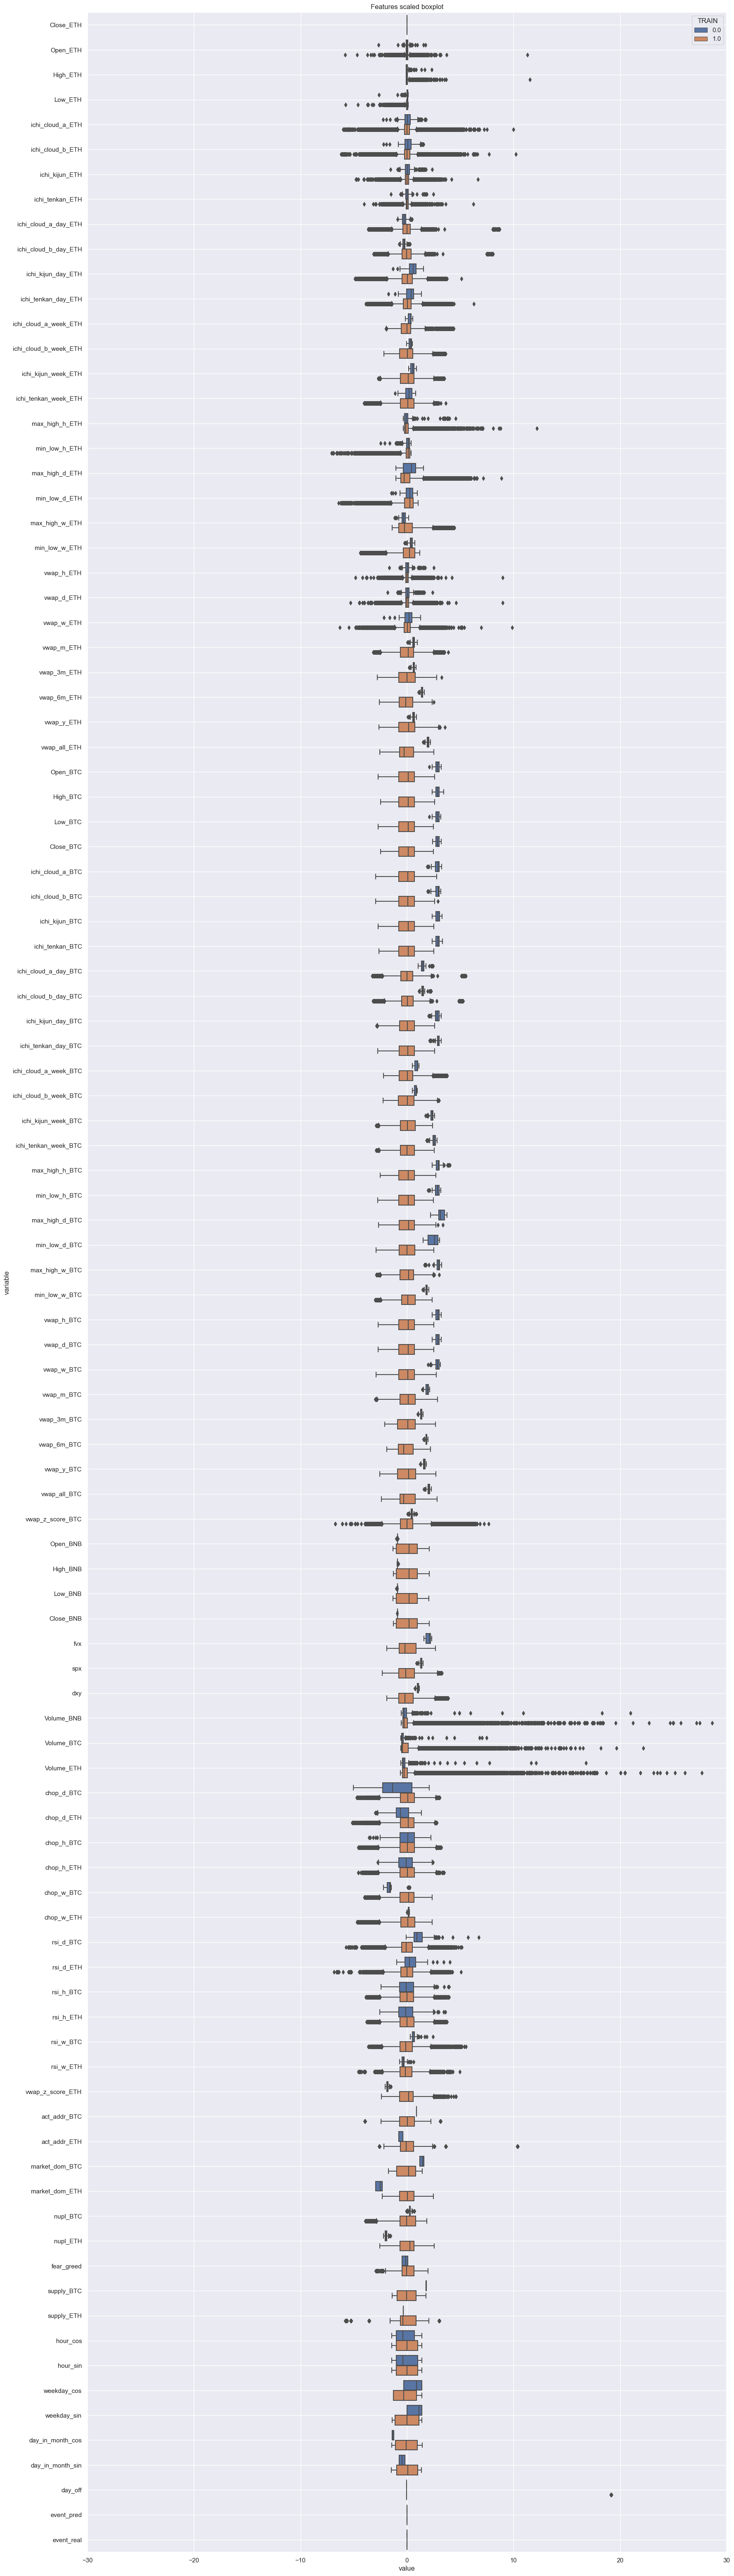

In [62]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<AxesSubplot: >

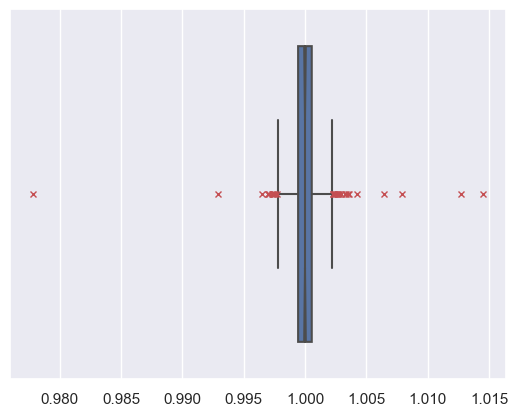

In [63]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


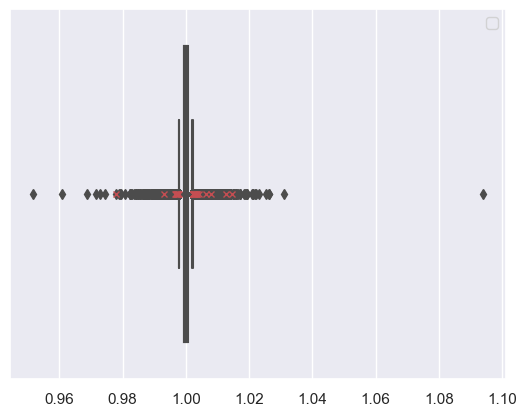

In [64]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

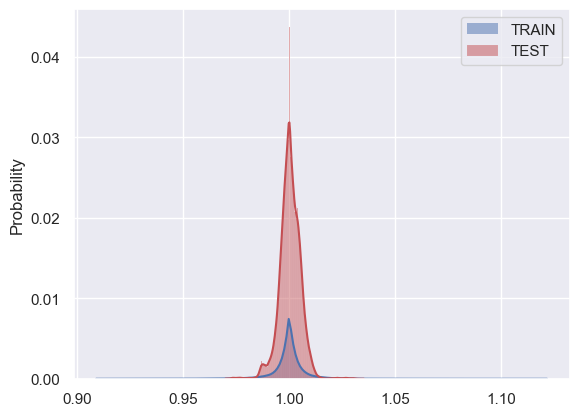

In [65]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [66]:
X_train_sca.shape

(82882, 72, 102)

In [67]:
X_train_sca[:,-1,:].shape

(82882, 102)

In [68]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.10854391],
       [-0.02764501],
       [-0.20208263],
       ...,
       [-0.22064359],
       [-0.22408724],
       [ 0.1549605 ]])

In [69]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(82882, 103)

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [72]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

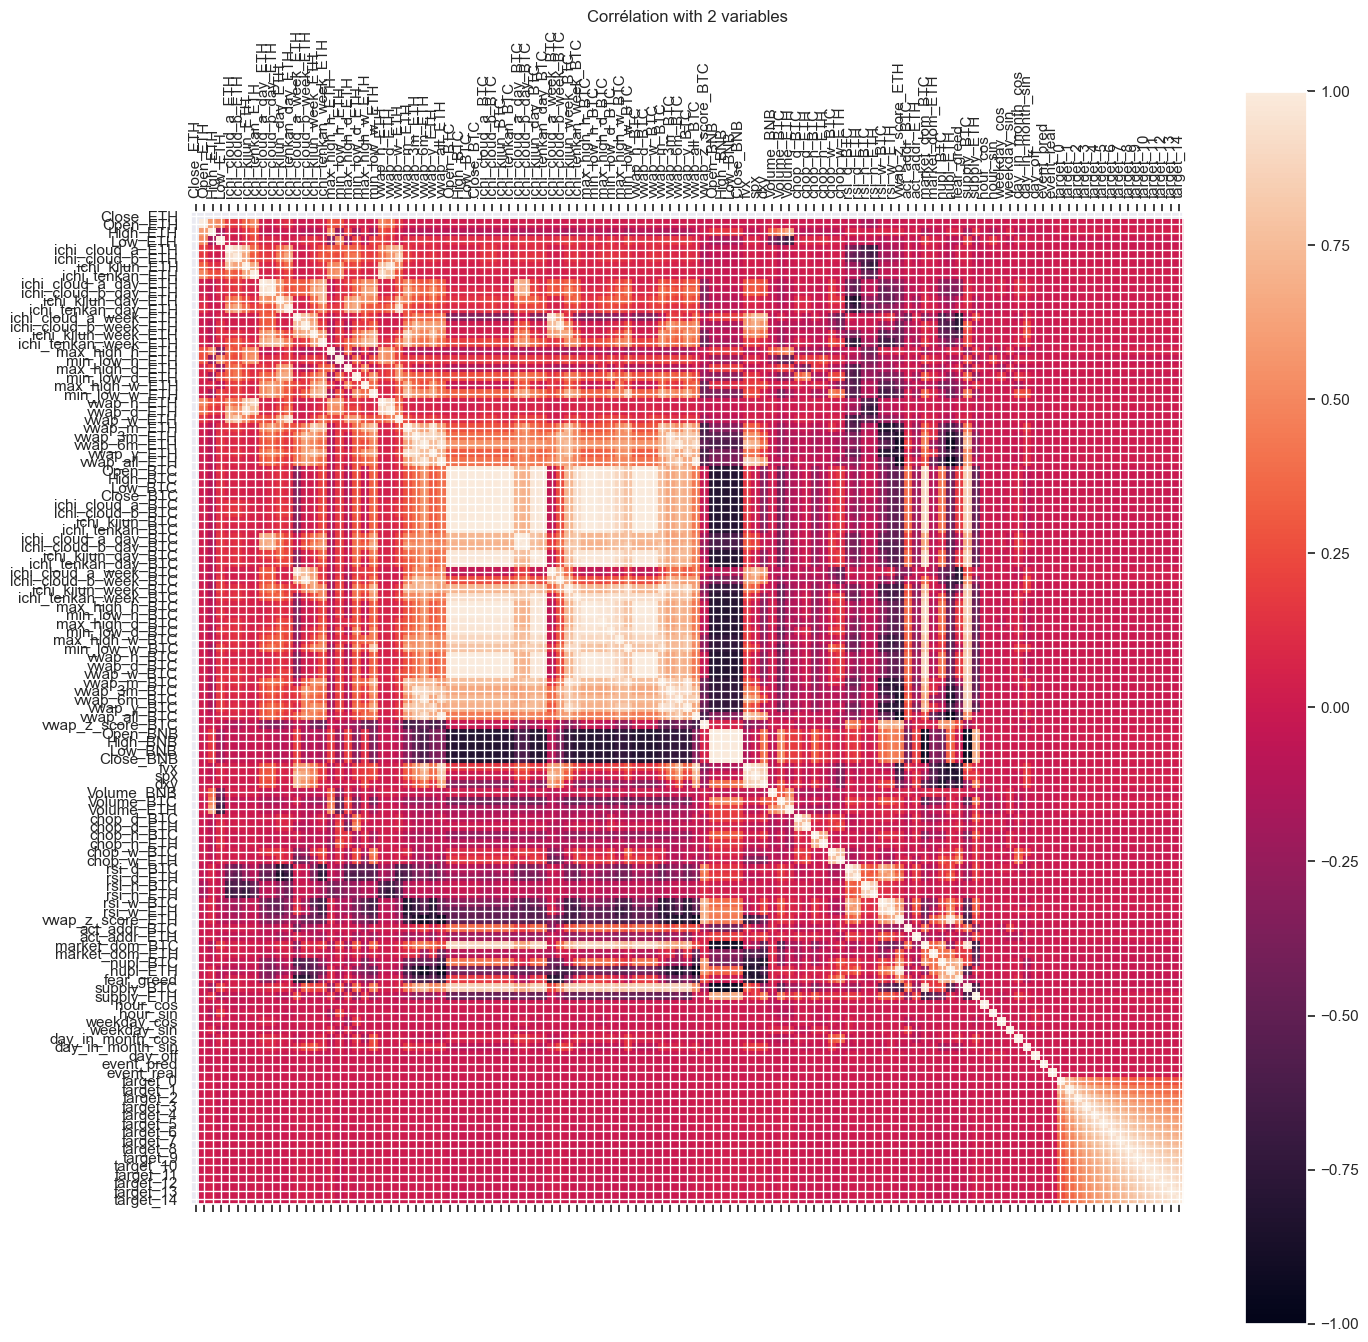

In [73]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


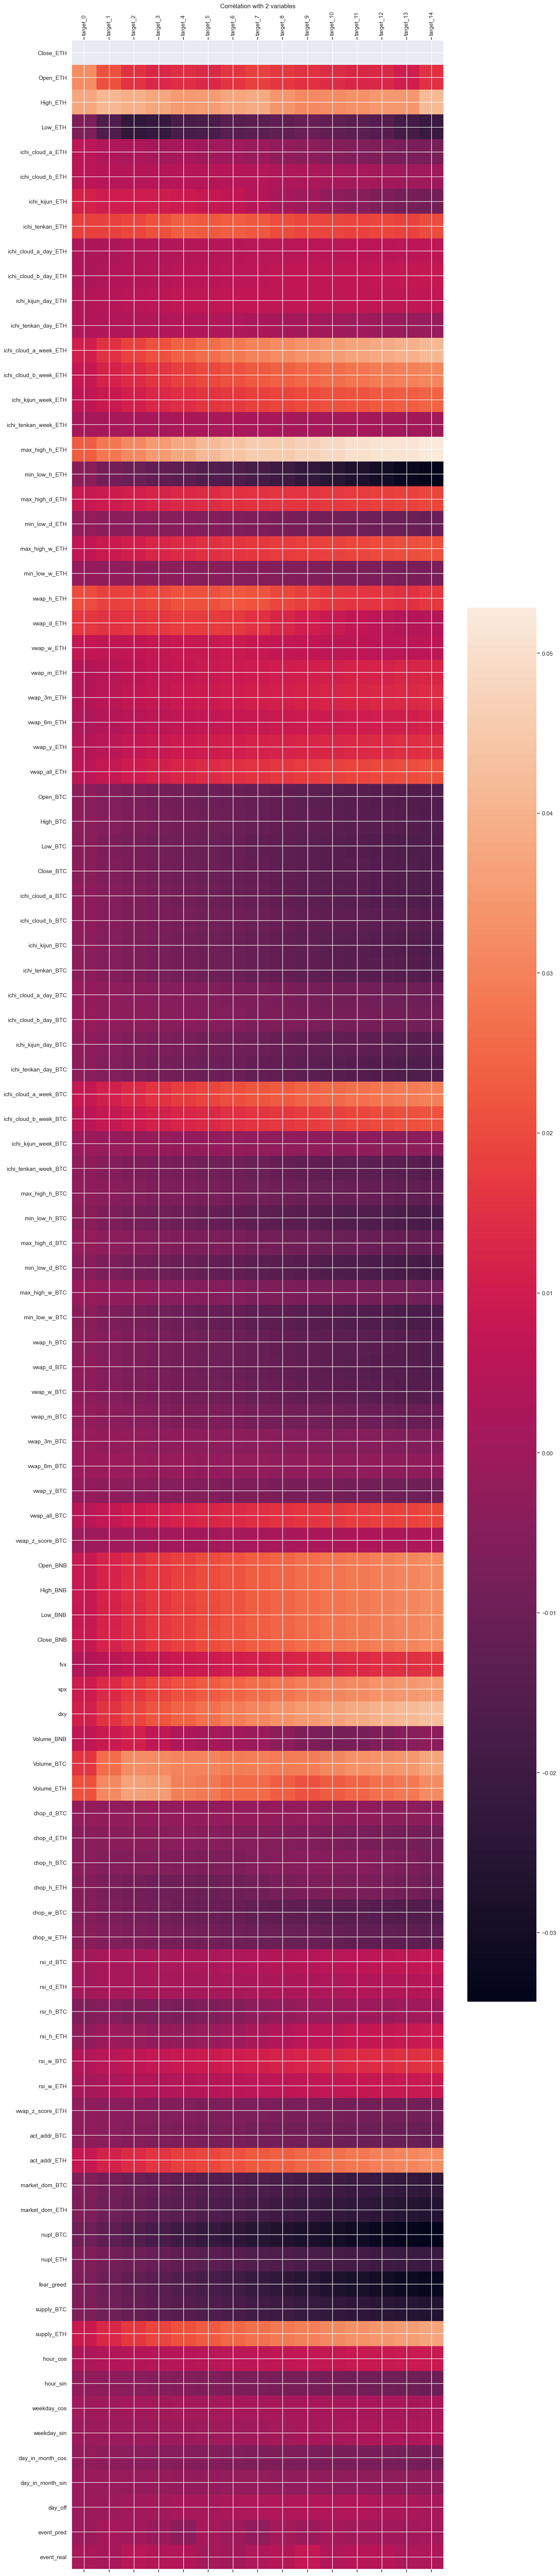

In [74]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


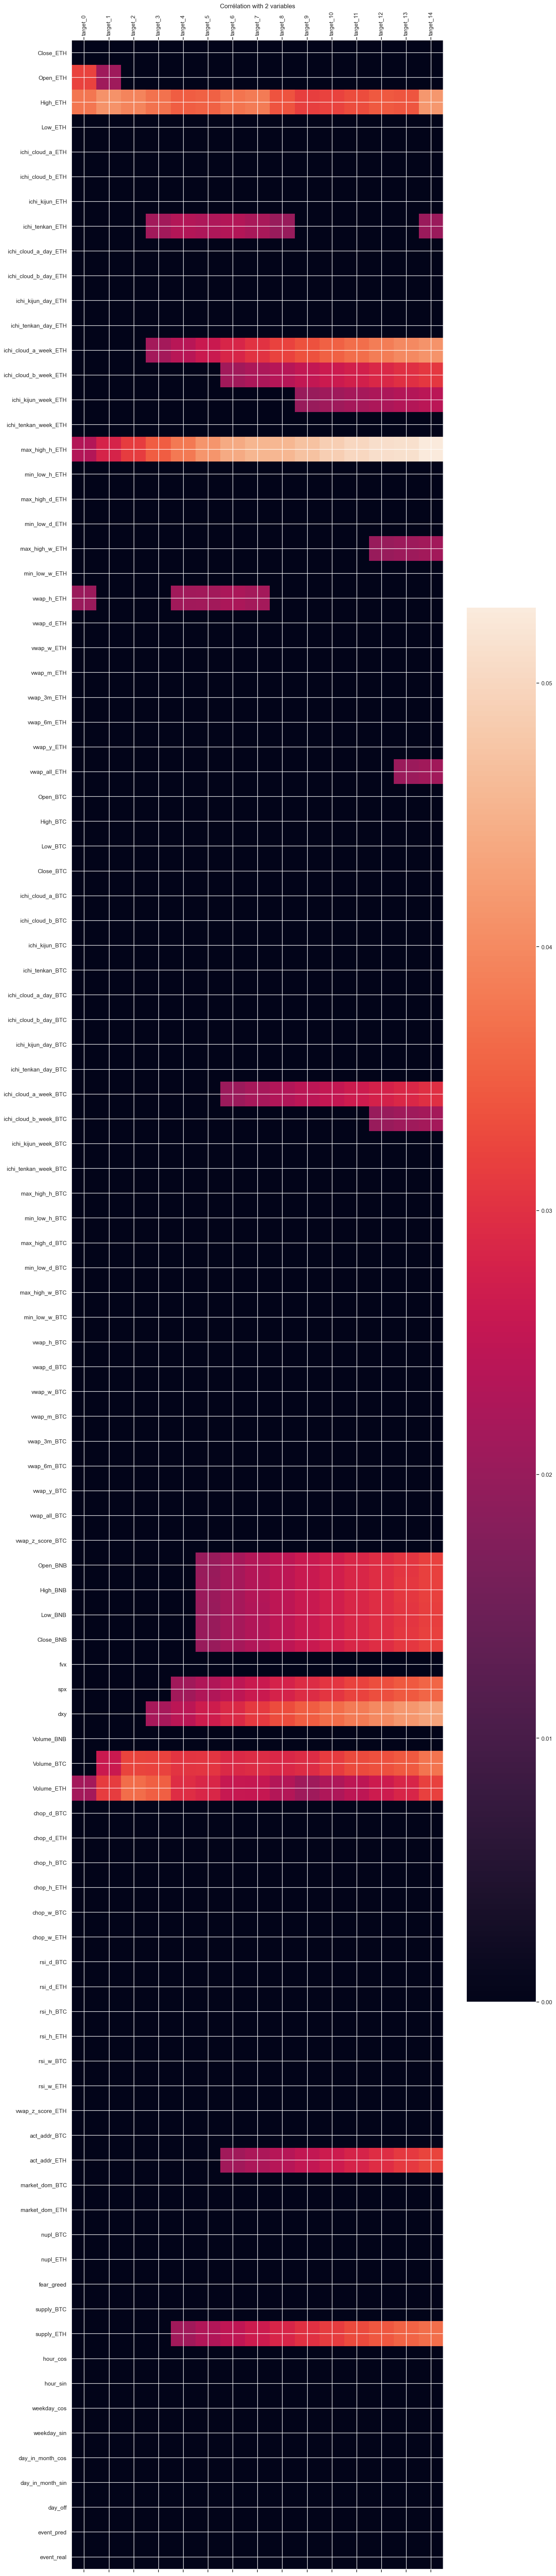

In [75]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [76]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

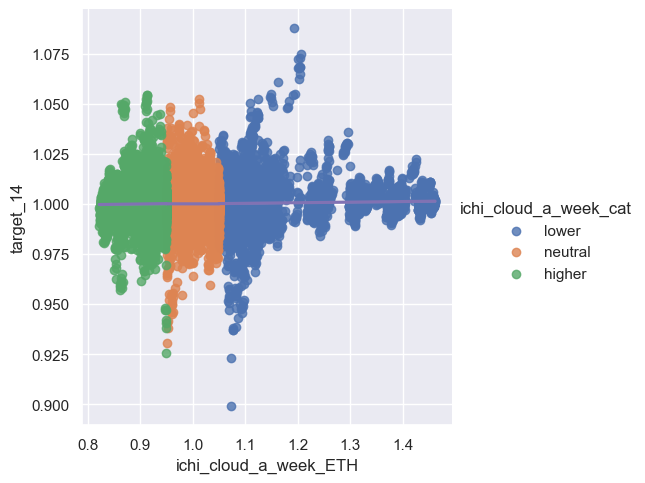

In [77]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

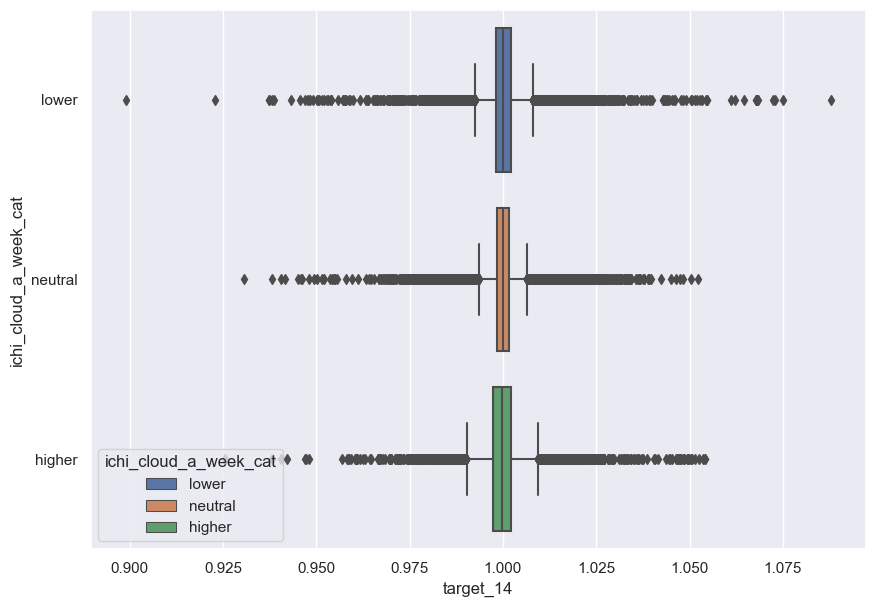

In [78]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [79]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


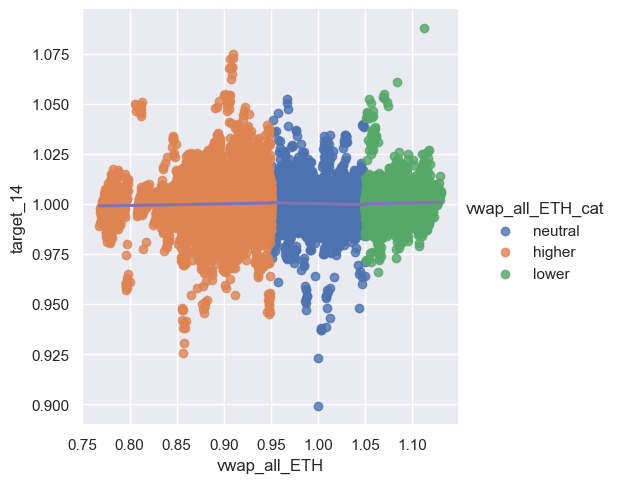

In [80]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

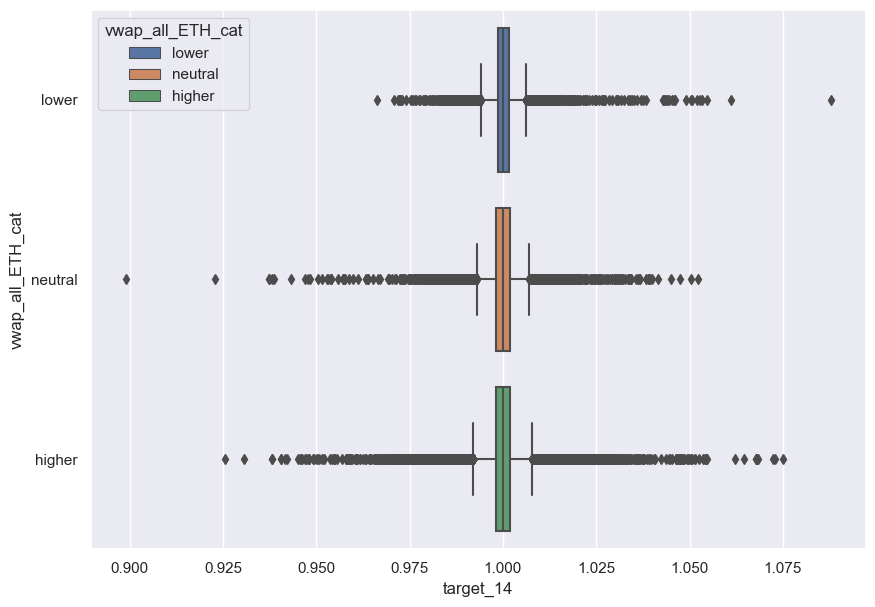

In [81]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

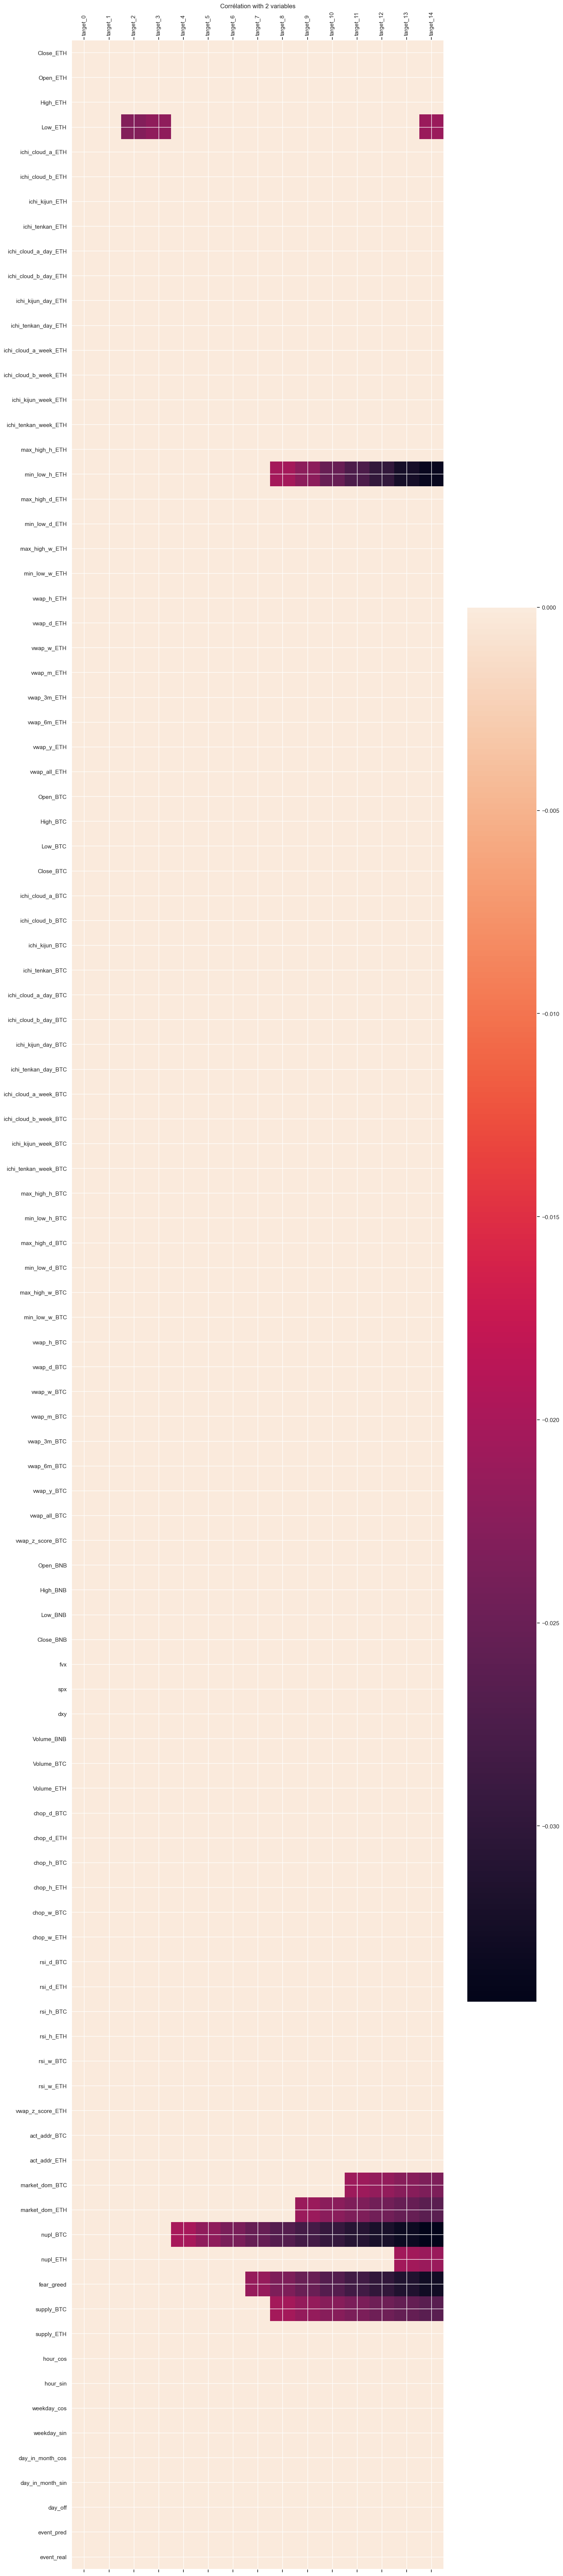

In [82]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

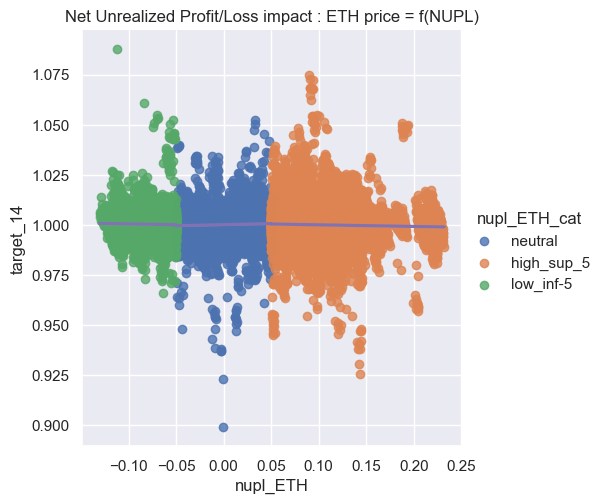

In [83]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

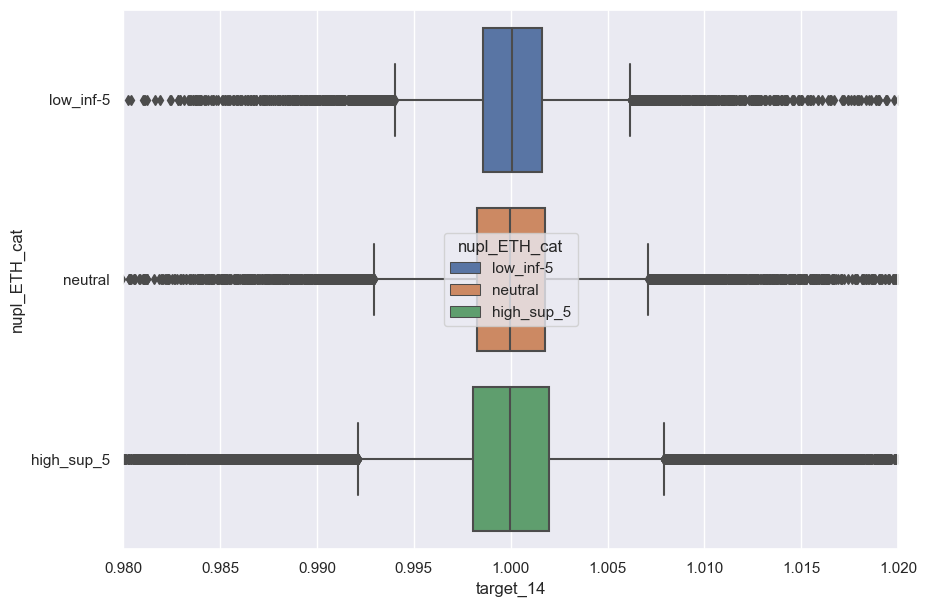

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [85]:
df["target_14"].describe()

count    82882.000000
mean         1.000063
std          0.005361
min          0.899006
25%          0.998172
50%          1.000005
75%          1.001874
max          1.087790
Name: target_14, dtype: float64

In [86]:
df["target_1"].describe()

count    82882.000000
mean         1.000008
std          0.001992
min          0.907143
25%          0.999291
50%          1.000000
75%          1.000724
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

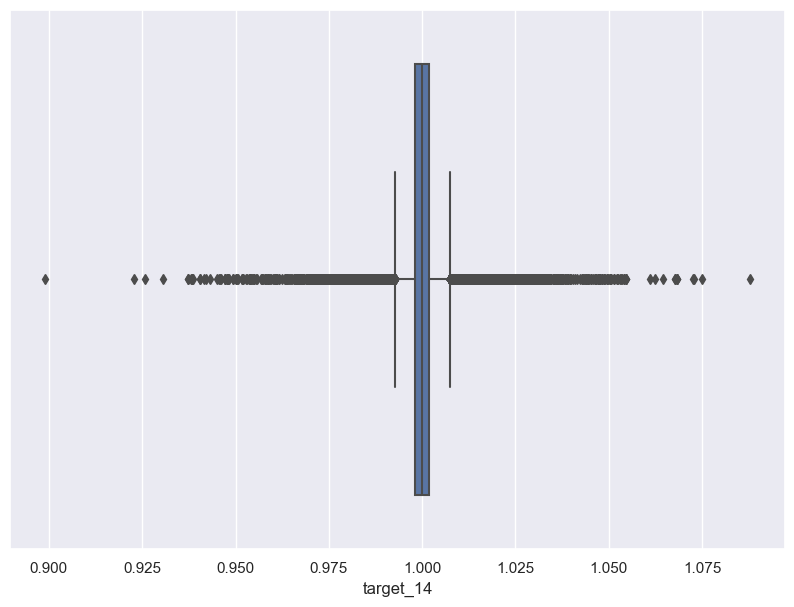

In [87]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [88]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99916548, 0.99831812, 0.99896006, ..., 1.00301069, 1.00352425,
        1.00392225],
       [0.99915193, 0.99979441, 1.00038549, ..., 1.00436241, 1.00476074,
        1.00501773],
       [1.00064302, 1.0012346 , 1.00090666, ..., 1.00561357, 1.00587078,
        1.00502842]])

In [89]:
y_train_sca

array([[ 0.10854391,  0.0893911 , -0.10426505, ..., -0.03616619,
         0.02980459, -0.04467854],
       [-0.02764501, -0.22121204, -0.05104322, ..., -0.0872041 ,
        -0.16165295, -0.31267778],
       [-0.20208263, -0.03190099, -0.15315541, ..., -0.14251906,
        -0.29355525, -0.36588245],
       ...,
       [-0.22064359, -0.4360499 , -0.2728633 , ...,  0.7568441 ,
         0.88739338,  0.98856907],
       [-0.22408724, -0.06076435,  0.08949271, ...,  1.1004614 ,
         1.2017216 ,  1.26705075],
       [ 0.1549605 ,  0.30534509,  0.22197972, ...,  1.41851802,
         1.48390263,  1.26976804]])

## Autoencoder

### Model creation

### Training

In [90]:
X_train_sca.shape

(82882, 72, 102)

In [91]:
3*3*3*10*35/3600

2.625

In [92]:
#tf.keras.optimizers.AdamW()

In [93]:
#tf.keras.optimizers.legacy.AdamW()

Training: TS 0.99 - units 128 - enc_dim 32 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         118272    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 32)          4128      
                                                                 
Total params: 122400 (478.12 KB)
Trainable params: 122400 (478.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer

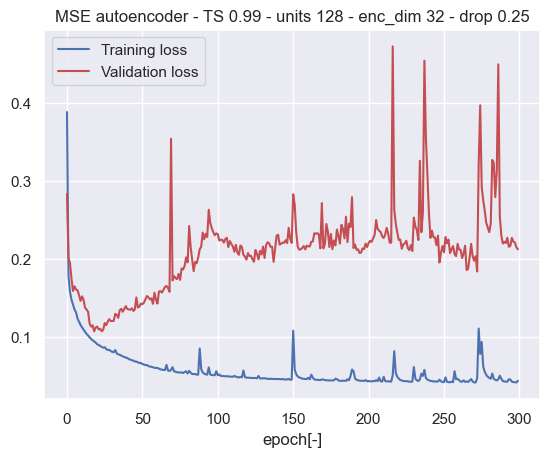

MSE TEST :  0.10669483244419098
Save autoencoder:  data/mdl_autoencoder
INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


Save encoder:  data/mdl_encoder


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


Load models...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 32)          122400    
                                                                 
 model_1 (Functional)        (None, None, 102)         95590     
                                                                 
Total params: 217990 (851.52 KB)
Trainable params: 217990 (851.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         118272    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 32)          4128      
                                                                 
Total params: 122400 (478.12 KB)
Trainable params: 122400 (478.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model : n_unit:128 / enc_dim: 32 / dropout: 0.25
Best model : seed:1 / n_unit:128 / enc_dim: 32 / dropout: 0.25


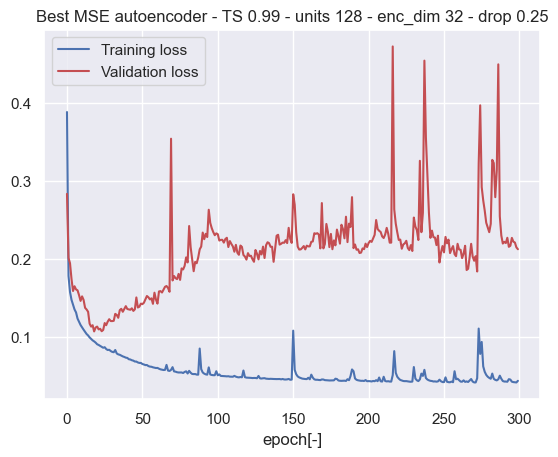

In [94]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5

epochs = 300 #100 #150 #6 #300
patience = 0 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in [128]: #[32, 64, 128]: #[104]: #
        for encoding_dim in [32]:#[16, 20, 32]:
            for dropout_autoenc in [0.25]: #[0.05, 0.15, 0.25]: #[0.25]:
                for seed in LIST_SEEDS:
                    # check already done ? 
                    #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                    plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                    path_jpg = os.path.join(path_data,
                        f"output_MSE autoencoder - {plt_name}.jpg")
                    if (MODE_TRAIN_AE == False):
                        print(f"BE CAREFUL ! training inactivated => no training done...")
                        continue
                    print(f"Training: {plt_name} ...")
                    # Init
                    tf.keras.backend.clear_session()
                    np.random.seed(seed)
                    random.seed(seed)
                    tf.random.set_seed(seed)
                    # Input dimension
                    input_dim = X_train.shape[-1]
                    # Reduced encoded input dimension
                    # 64/8/0.5
                    # Définir l'encodeur
                    encoder_inputs = keras.Input(shape=(None, input_dim))
                    encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                    #encoder = layers.LayerNormalization()(encoder)
                    #encoder = layers.Dense(encoding_dim, activation='relu')
                    encoder = layers.Dropout(dropout_autoenc)(encoder)
                    encoder_outputs = layers.Dense(encoding_dim)(encoder)
                    encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                    print(encoder_model.summary())
                    # Définir le décodeur
                    decoder_inputs = keras.Input(shape=(None, encoding_dim))
                    decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                    #decoder = layers.LayerNormalization()(decoder)
                    #decoder = layers.Dense(n_unit_enc, activation='relu')
                    decoder = layers.Dropout(dropout_autoenc)(decoder)
                    decoder_outputs = layers.Dense(input_dim)(decoder)
                    decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                    print(decoder_model.summary())
                    # Define complete autoencoder 
                    autoencoder_inputs = keras.Input(shape=(None, input_dim))
                    encoded = encoder_model(autoencoder_inputs)
                    decoded = decoder_model(encoded)
                    autoencoder = keras.Model(autoencoder_inputs, decoded)
                    # Compile : autoencoder
                    optim = tf.keras.optimizers.legacy.Adam()
                    #optim = tf.keras.optimizers.AdamW()
                    #optim = tf.keras.optimizers.Adam()
                    autoencoder.compile(optimizer=optim, loss="mse")
                    # earlystop 
                    es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                                    monitor='val_loss', mode='auto', restore_best_weights=True)
                    # Train
                    if patience == 0:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1)
                    else:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                            epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                            verbose=1, callbacks=[es])

                    plot_train_history(
                        autoenc_step_history,f"MSE autoencoder - {plt_name}",
                        saveFolder=path_data)
                    #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                    #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                                # save the best
                    mse_curr = np.min(autoenc_step_history.history['val_loss'])
                    print("MSE TEST : ", mse_curr)

                    if mse_curr_min == None:
                        seed_min = seed
                        autoenc_step_history_min = autoenc_step_history
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)
                    else:
                        if mse_curr < mse_curr_min:
                            seed_min = seed
                            autoenc_step_history_min = autoenc_step_history
                            mse_curr_min = mse_curr
                            n_unit_enc_min = n_unit_enc
                            encoding_dim_min = encoding_dim
                            dropout_autoenc_min = dropout_autoenc
                            print("Save autoencoder: ", path_mdl_autoencoder)
                            autoencoder.save(path_mdl_autoencoder)
                            print("Save encoder: ", path_mdl_encoder)
                            encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min

print("Load models...")
autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
print(autoencoder.summary())
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print(encoder_model.summary())
n_unit_enc = encoder_model.layers[1].units
dropout_autoenc = encoder_model.layers[2].rate
encoding_dim = encoder_model.layers[3].units
print(f"Model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

if MODE_TRAIN_AE:
    print(f"Best model : seed:{seed} / n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")
    plot_train_history(
        autoenc_step_history_min, 
        f"Best MSE autoencoder - {plt_name}",
        saveFolder=path_data,
    )

In [95]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [96]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [97]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2591/2591 [==============================] - 50s 19ms/step


(82882, 72, 102)

### Results

In [98]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

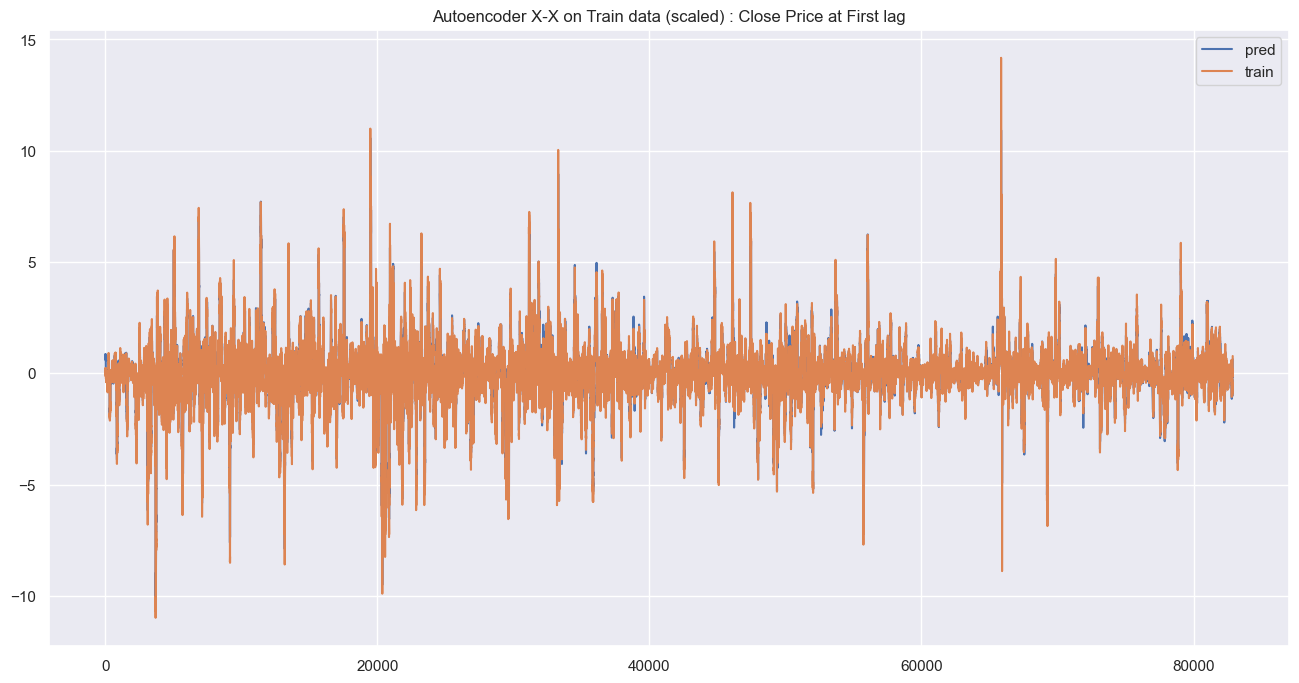

In [99]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [100]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(82882, 72, 102)
(82882, 72, 102)
(72, 102)
(1, 102)


In [101]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.133362  0.142742  0.135127  0.130938          0.216523   
lag_1    0.139268  0.134314  0.131125  0.135900          0.170628   
lag_2    0.149265  0.142941  0.140313  0.145919          0.159691   
lag_3    0.160616  0.154222  0.151805  0.157672          0.159735   
lag_4    0.166888  0.160253  0.158142  0.164042          0.158874   
...           ...       ...       ...       ...               ...   
lag_67   0.091218  0.099894  0.086409  0.094786          0.133652   
lag_68   0.088751  0.098105  0.084057  0.092612          0.133367   
lag_69   0.086281  0.096145  0.081640  0.090354          0.133092   
lag_70   0.083914  0.094106  0.079203  0.088097          0.132840   
lag_71   0.081191  0.092374  0.076567  0.085862          0.132591   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.218478        0.128672         0.129927   
lag_1           0.174171        0.126133         0.130819   
lag_2           0.164755        0.135132         0.139266   
lag_3           0.164452        0.145438         0.148967   
lag_4           0.162822        0.149451         0.153073   
...                  ...             ...              ...   
lag_67          0.149957        0.095003         0.088579   
lag_68          0.149814        0.093721         0.086913   
lag_69          0.149683        0.092390         0.085256   
lag_70          0.149537        0.091079         0.083551   
lag_71          0.149384        0.089642         0.081593   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.177581              0.141596  ...    0.185718  0.399694   
lag_1               0.146676              0.117929  ...    0.133979  0.369275   
lag_2               0.139928              0.113841  ...    0.101946  0.361099   
lag_3               0.137022              0.113692  ...    0.088904  0.356110   
lag_4               0.135370              0.113067  ...    0.082582  0.350436   
...                      ...                   ...  ...         ...       ...   
lag_67              0.126150              0.114101  ...    0.079099  0.342809   
lag_68              0.126132              0.114106  ...    0.079100  0.342772   
lag_69              0.126113              0.114108  ...    0.079103  0.342736   
lag_70              0.126092              0.114107  ...    0.079105  0.342705   
lag_71              0.126074              0.114108  ...    0.079107  0.342668   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.341749     0.391831     0.388204          0.248909   
lag_1   0.362880     0.366509     0.359082          0.154087   
lag_2   0.363341     0.347542     0.348117          0.138600   
lag_3   0.362398     0.340761     0.343141          0.136059   
lag_4   0.360877     0.335836     0.338962          0.134412   
...          ...          ...          ...               ...   
lag_67  0.354749     0.337110     0.338376          0.146323   
lag_68  0.354750     0.337112     0.338361          0.146464   
lag_69  0.354750     0.337115     0.338344          0.146603   
lag_70  0.354743     0.337112     0.338327          0.146738   
lag_71  0.354740     0.337113     0.338318          0.146870   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.242479  0.047619    0.108550    0.109368  
lag_1           0.181403  0.038070    0.055801    0.064162  
lag_2           0.174569  0.030567    0.036975    0.044926  
lag_3           0.175745  0.027388    0.031960    0.037894  
lag_4           0.176395  0.026013    0.028491    0.034216  
...                  ...       ...         ...         ...  
lag_67          0.186596  0.026741    0.022915    0.030798  
lag_68          0.186595  0.026747    0.022911    0.030791  
lag_69          0.186595  0.026747    0.022906    0.030787  
lag_70          0.186598  0.026750    0.022901    0.030779  
lag_71          0.186596  0.02674

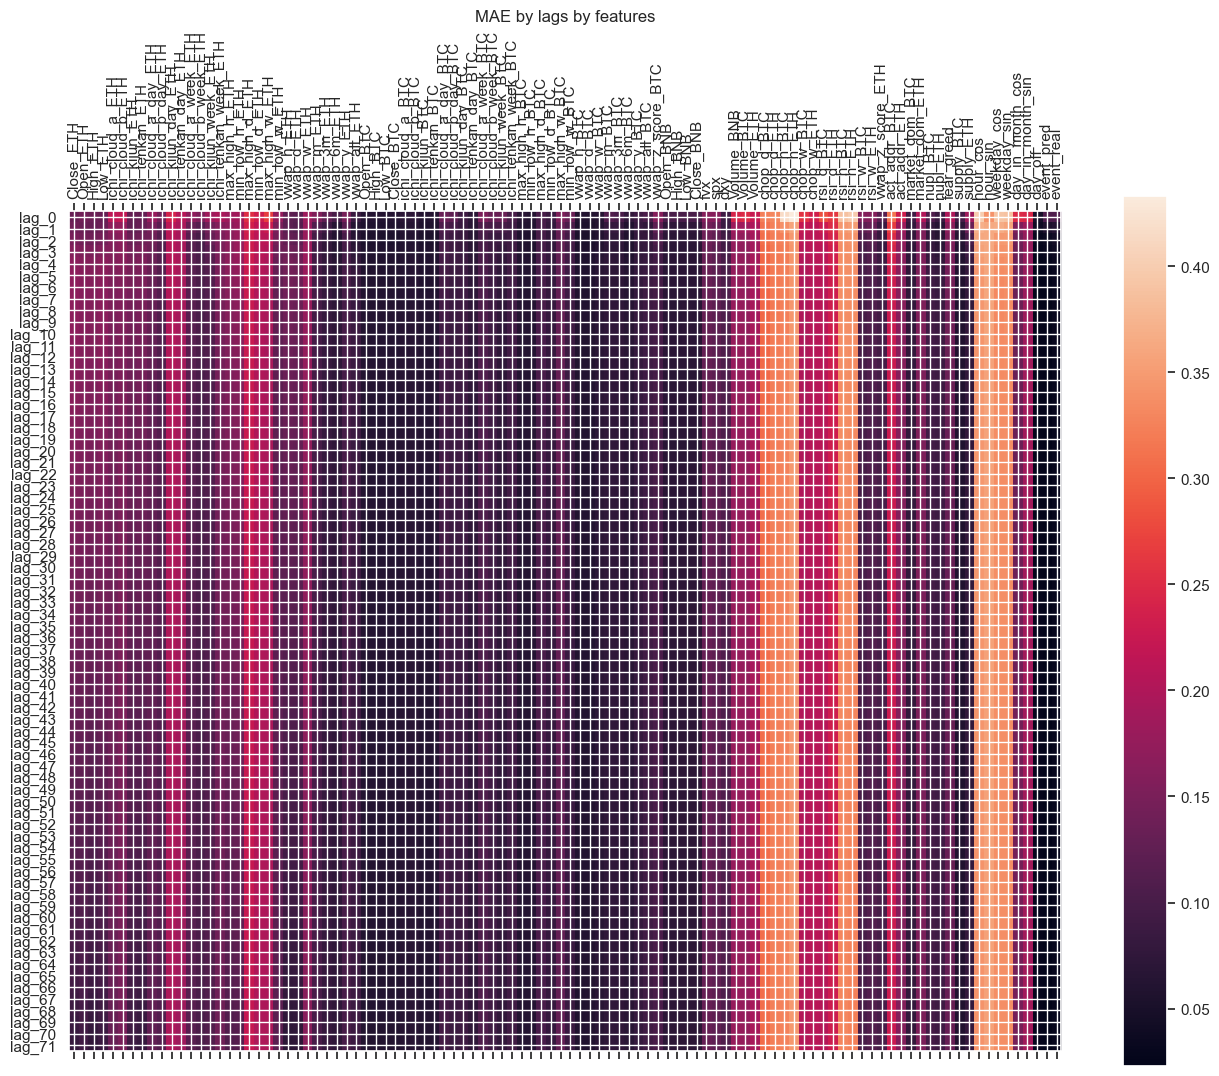

In [102]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

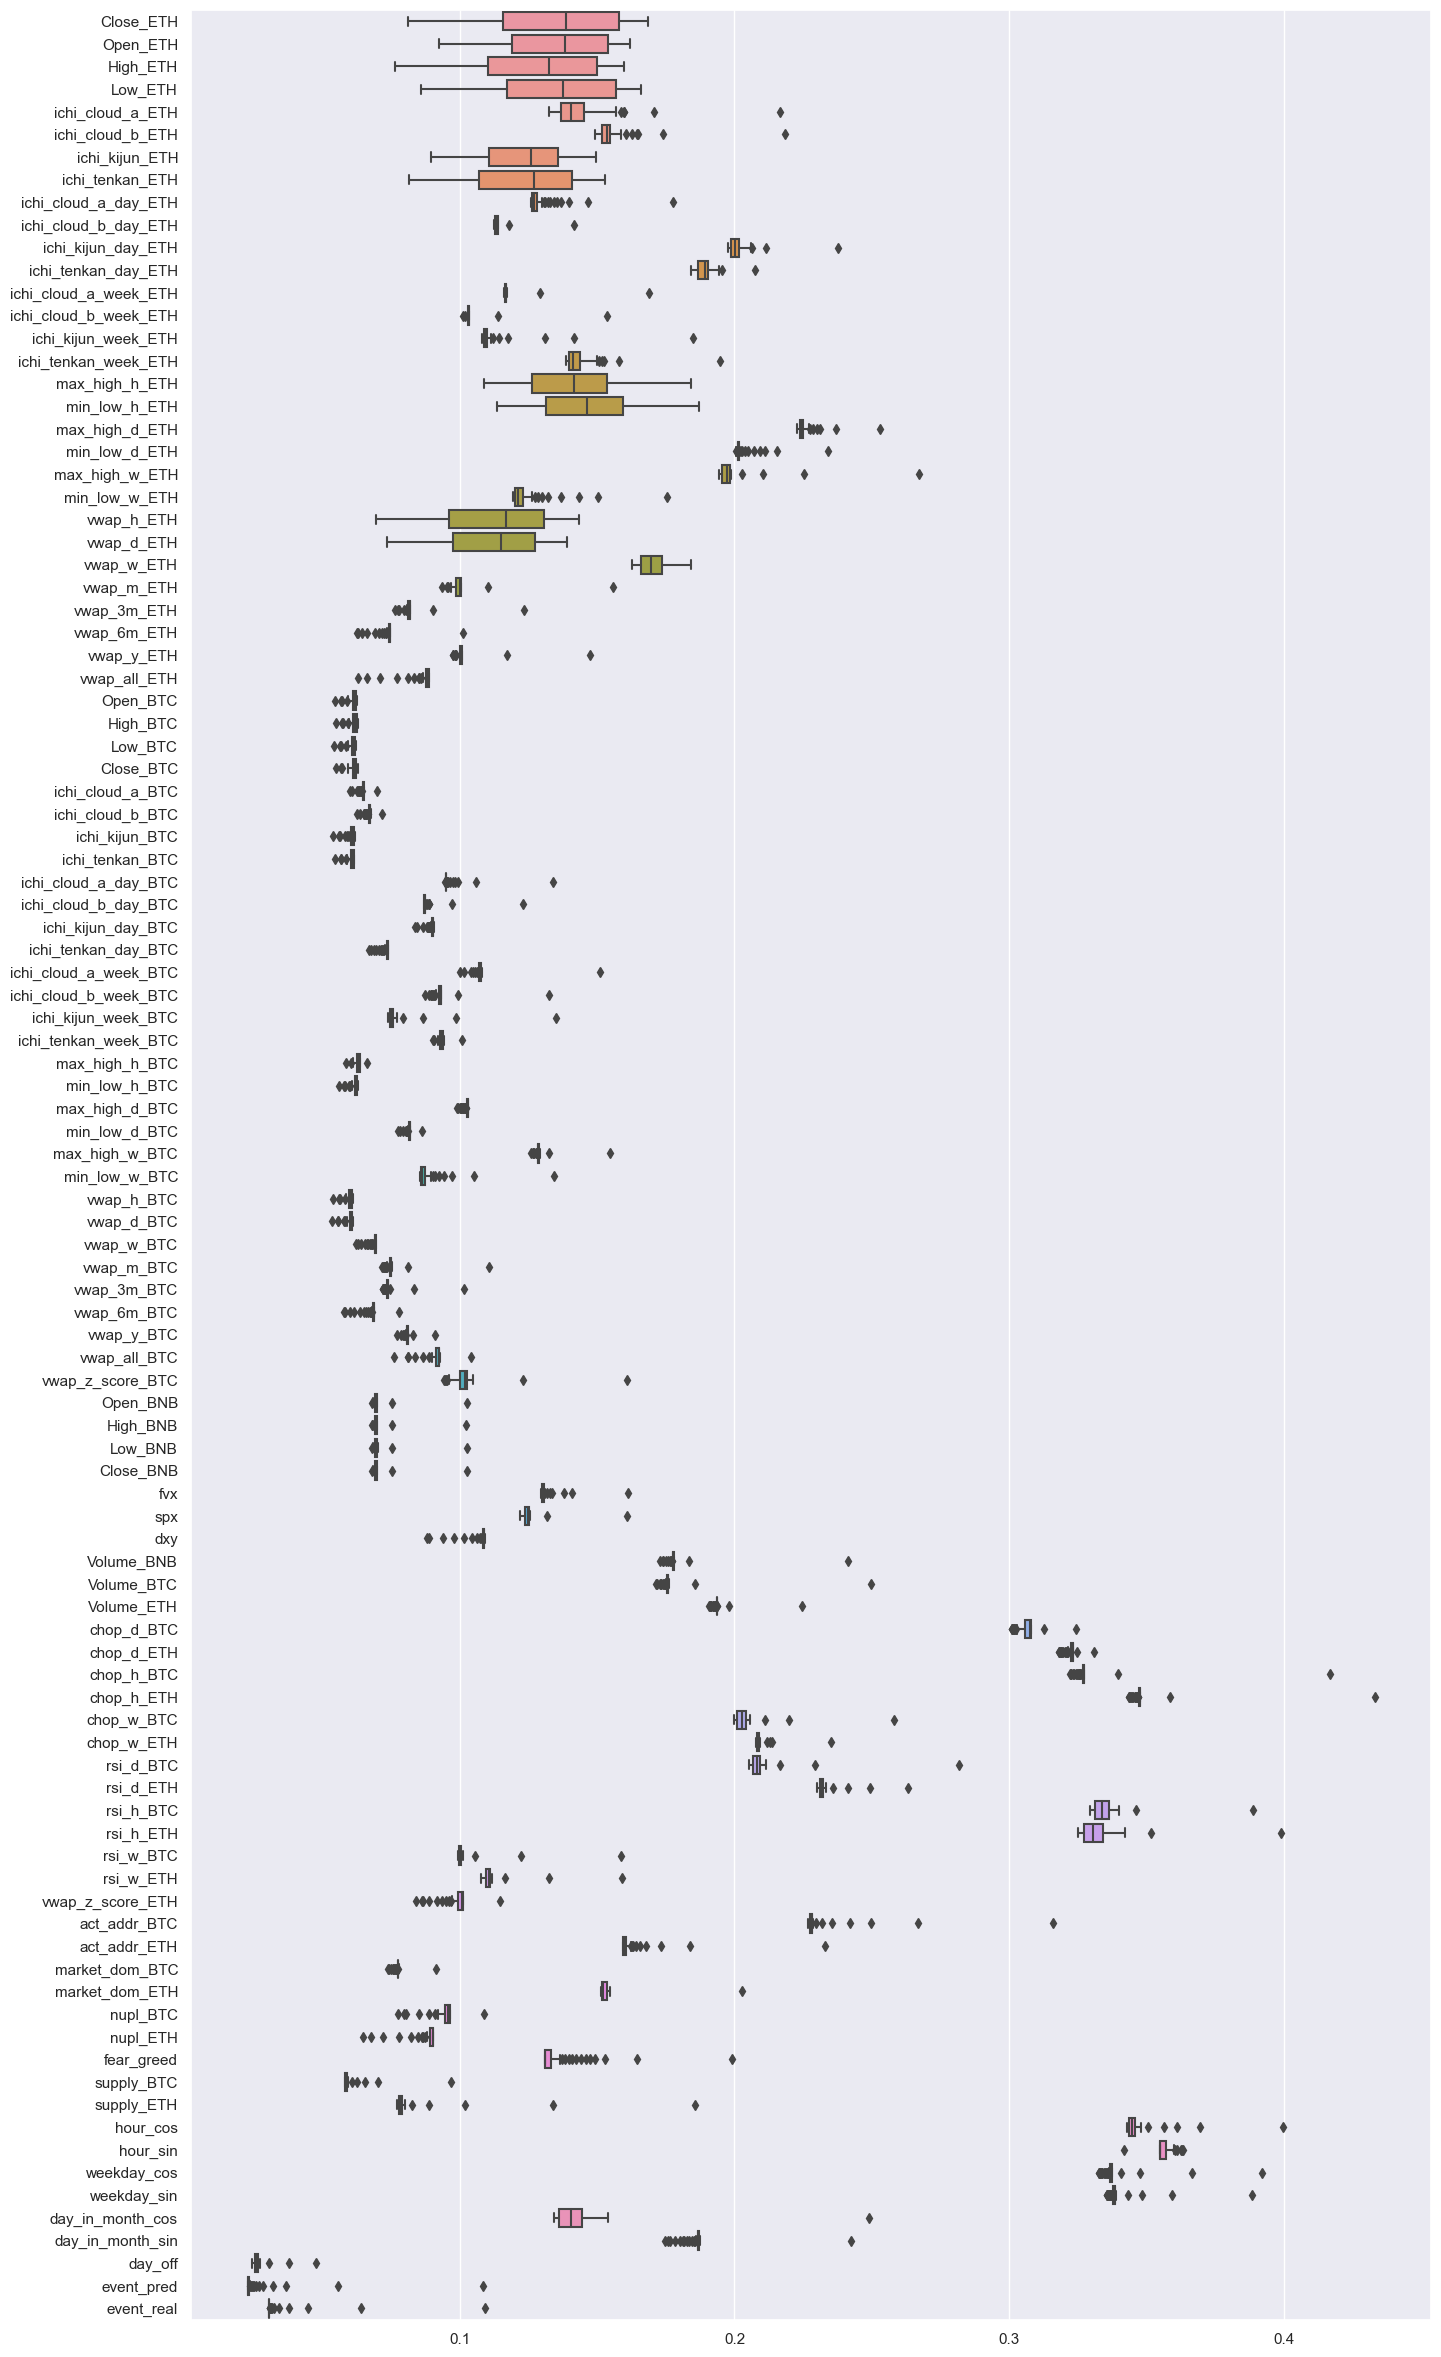

In [103]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [104]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0   0.135142  0.135233  0.128508  0.13518          0.143066          0.154789   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0        0.123051         0.123281              0.128781   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.113936  ...    0.081191  0.345994  0.355919     0.337895   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0      0.33914           0.14207          0.186613  0.026574    0.025297   

   event_real  
0    0.032742  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

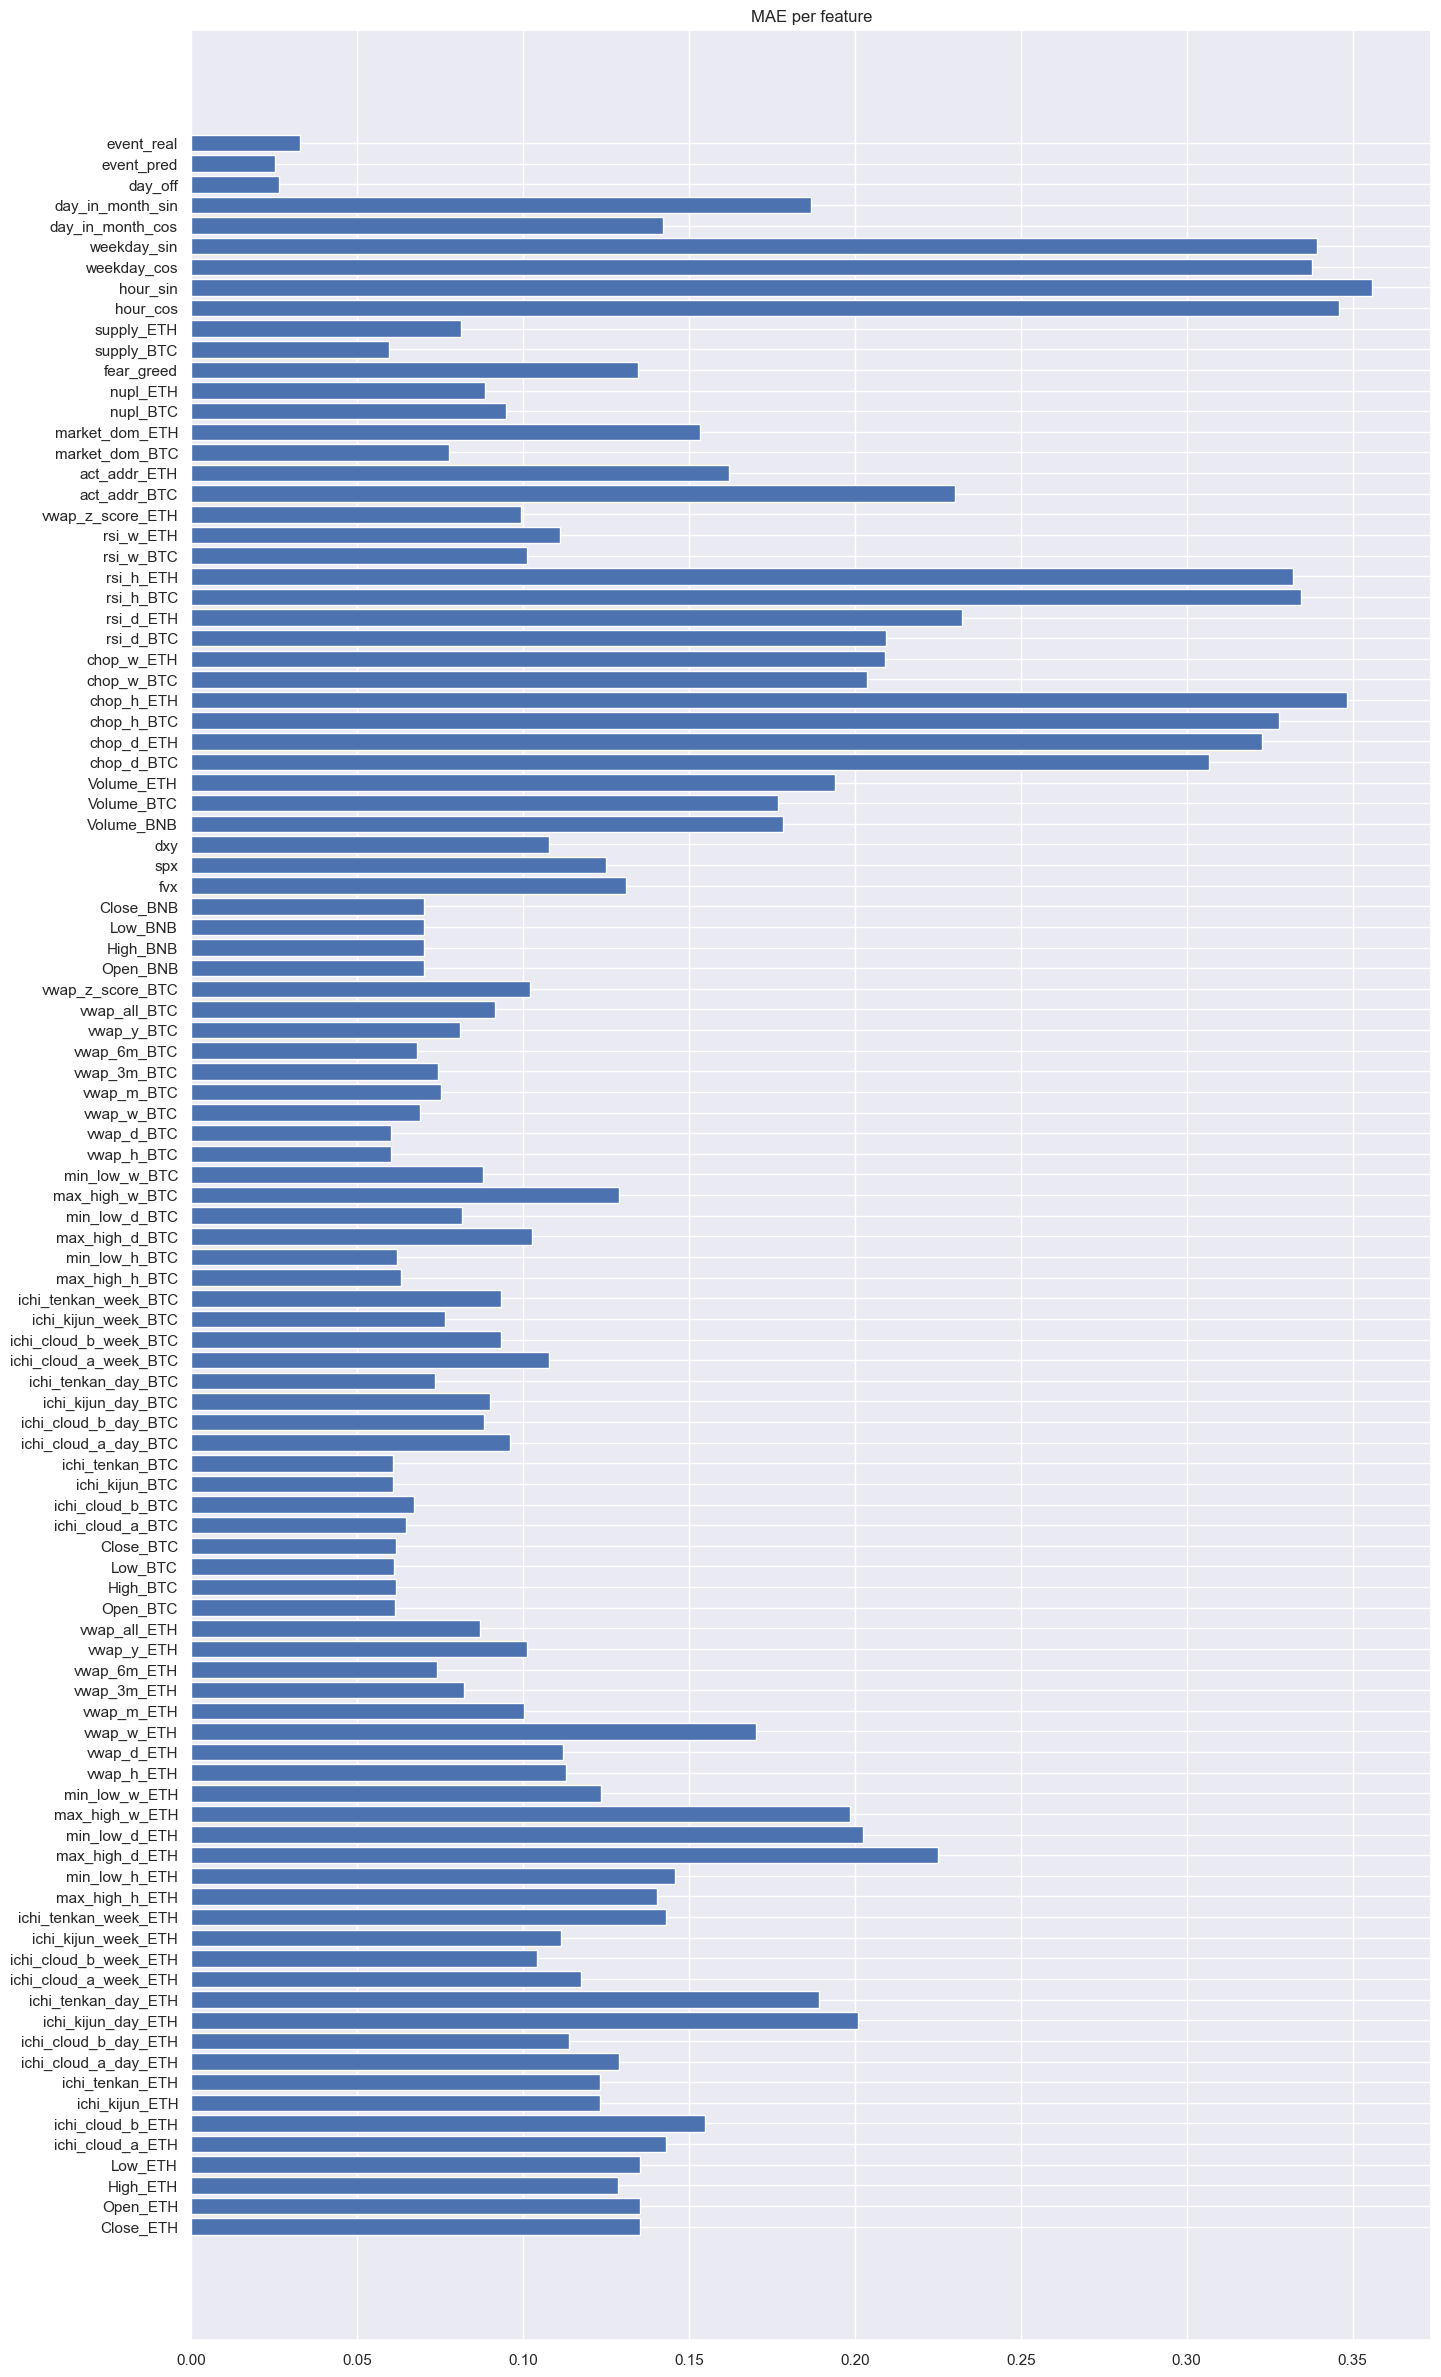

In [105]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [106]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(82882,)
(82882,)
[1196.32 1195.38 1194.55 ... 1560.87 1563.26 1564.97]
[1196.32 1195.38 1194.55]


In [107]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.9995543 , 0.9994977 , 0.9997958 , ..., 0.99985075, 1.0003713 ,
       1.0005746 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 1560.87 1563.26 1564.97]
[1202.86984589 1203.2393304  1202.88916349 ... 1560.78818422 1562.20857422
 1563.16604637]


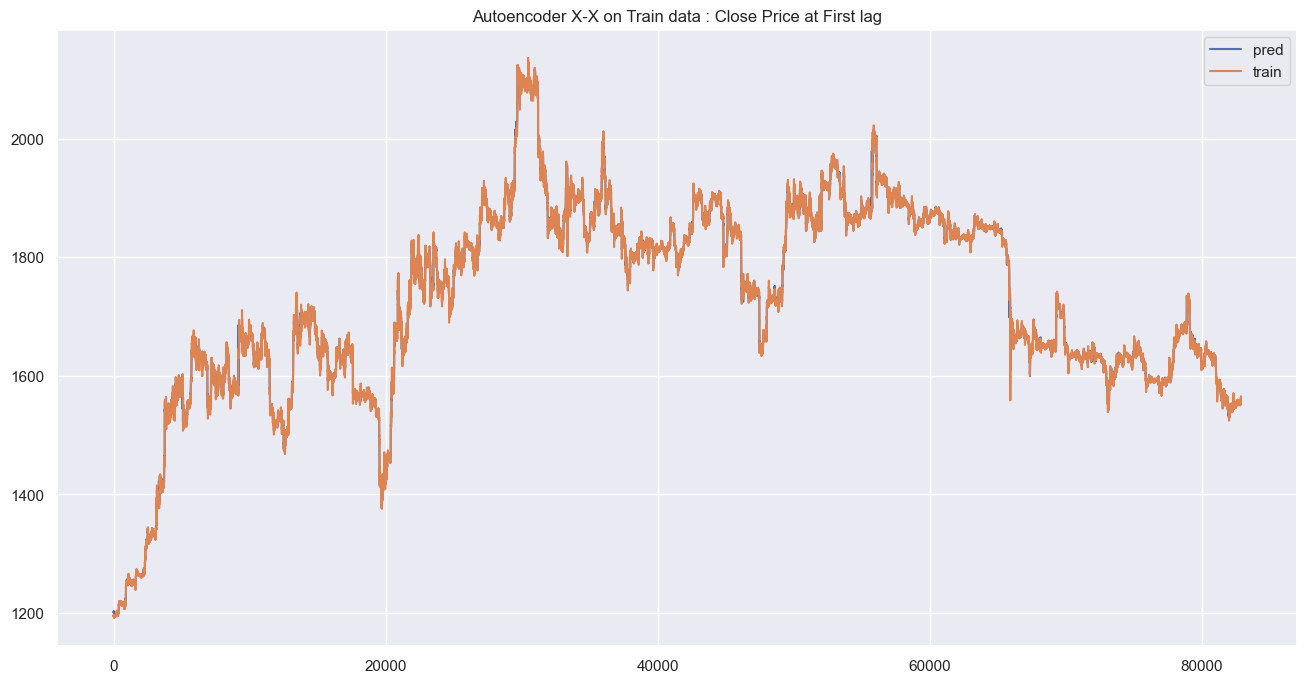

In [108]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [109]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

24/24 [==============================] - 1s 27ms/step


(750, 72, 102)

In [110]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-10-16 02:00:00'

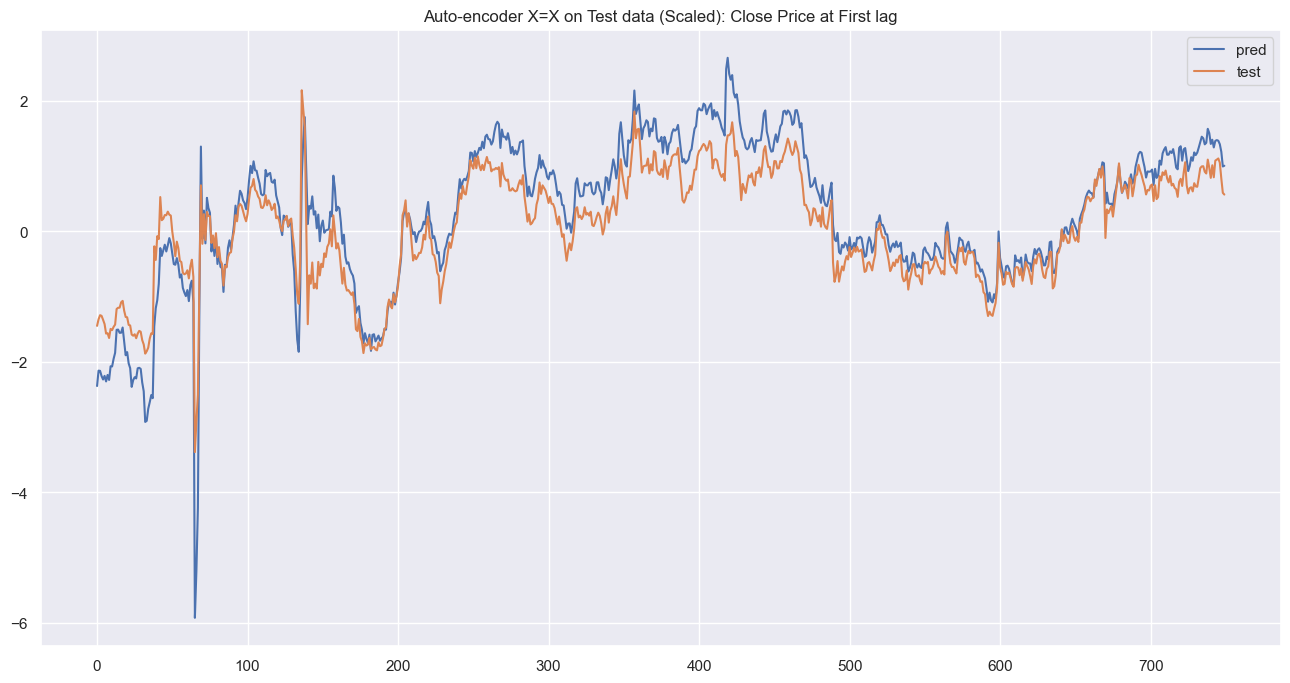

In [111]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [112]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1563.69 1563.99 1564.88 1565.83 1565.77 1564.35 1563.29 1562.51 1562.  ]
X test pred :  [1551.69207788 1553.75833706 1553.78185071 1553.81900446 1553.85653814
 1554.01863288 1553.74282527 1554.17420169 1553.62601108]


[1563.69 1563.99 1564.88 1565.83 1565.77 1564.35 1563.29 1562.51 1562.
 1562.21 1562.2  1561.62 1561.4  1561.35 1561.39 1561.62 1562.82 1562.54
 1562.32 1562.84 1562.54 1562.47 1563.   1563.33 1562.01 1562.18 1561.14
 1561.07 1561.68 1561.64 1561.24 1561.25 1562.32 1563.03 1562.24 1563.69
 1564.27 1564.53 1581.73 1578.93 1584.28 1582.59 1588.63 1584.56 1583.93
 1584.62 1585.27 1586.54 1584.43 1585.52 1582.34 1581.1  1578.58 1581.52
 1581.03 1579.64 1578.44 1577.49 1578.03 1578.79 1578.2  1578.01 1578.32
 1579.34 1580.12 1580.13 1581.24 1580.06 1579.77 1579.15 1578.73 1582.65
 1581.63 1581.7  1582.79 1583.53 1582.96 1583.81 1582.93 1583.39 1581.76
 1582.   1580.75 1580.08 1576.88 1576.68 1576.89 1577.03 1576.46 1578.19
 1579.99 1579.76 1581.21 1581.87 1584.03 1582.94 1582.82 1582.56 1581.56
 1581.63 1581.76 1583.04 1583.93 1586.88 1587.12 1585.6  1585.23 1584.75
 1585.13 1584.83 1584.75 1585.35 1584.24 1581.9  1582.44 1581.54 1581.48
 1582.16 1582.72 1581.21 1582.48 1582.54 1583.43 1583

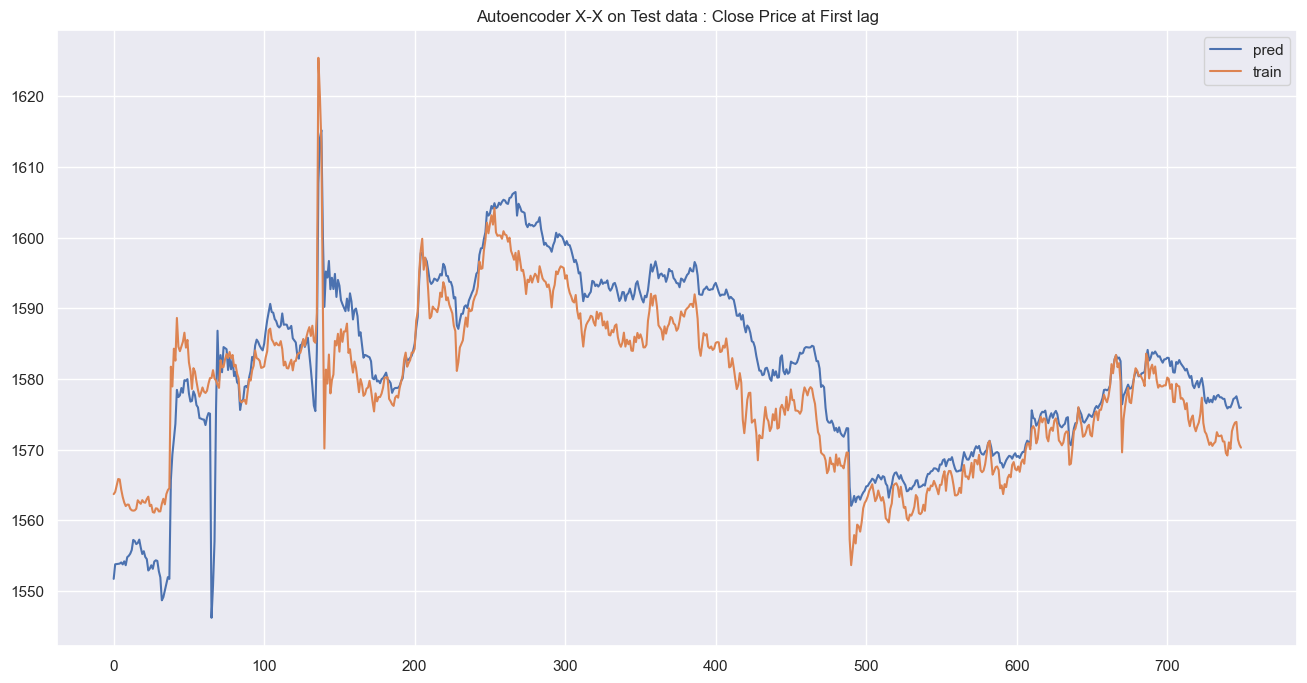

In [113]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [114]:
X_test_sca.shape

(750, 72, 102)

In [115]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.3366250466930133

In [116]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(750, 72, 102)
(750, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.133362  0.142742  0.135127  0.130938          0.216523   
lag_1    0.139268  0.134314  0.131125  0.135900          0.170628   
lag_2    0.149265  0.142941  0.140313  0.145919          0.159691   
lag_3    0.160616  0.154222  0.151805  0.157672          0.159735   
lag_4    0.166888  0.160253  0.158142  0.164042          0.158874   
...           ...       ...       ...       ...               ...   
lag_67   0.107408  0.107450  0.099163  0.108563          0.158261   
lag_68   0.105210  0.107255  0.097195  0.106473          0.157963   
lag_69   0.102369  0.105910  0.094902  0.104694          0.157831   
lag_70   0.098976  0.103982  0.091680  0.101436          0.157778   
lag_71   0.096757  0.100941  0.089170  0.099682          0.157689   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.218478        0.128672         0.129927   
lag_1           0.174171        0.126133         0.130819   
lag_2           0.164755        0.135132         0.139266   
lag_3           0.164452        0.145438         0.148967   
lag_4           0.162822        0.149451         0.153073   
...                  ...             ...              ...   
lag_67          0.146458        0.118962         0.097934   
lag_68          0.146290        0.117325         0.097299   
lag_69          0.146827        0.115167         0.095877   
lag_70          0.147144        0.113039         0.094374   
lag_71          0.147662        0.111574         0.092385   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.177581              0.141596  ...  0.399694  0.341749   
lag_1               0.146676              0.117929  ...  0.369275  0.362880   
lag_2               0.139928              0.113841  ...  0.361099  0.363341   
lag_3               0.137022              0.113692  ...  0.356110  0.362398   
lag_4               0.135370              0.113067  ...  0.350436  0.360877   
...                      ...                   ...  ...       ...       ...   
lag_67              0.107509              0.203054  ...  0.350310  0.349333   
lag_68              0.107423              0.202835  ...  0.350908  0.348905   
lag_69              0.107176              0.202370  ...  0.351315  0.348535   
lag_70              0.107148              0.202218  ...  0.351778  0.348251   
lag_71              0.107033              0.202036  ...  0.352202  0.347915   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.391831     0.388204          0.248909          0.242479   
lag_1      0.366509     0.359082          0.154087          0.181403   
lag_2      0.347542     0.348117          0.138600          0.174569   
lag_3      0.340761     0.343141          0.136059          0.175745   
lag_4      0.335836     0.338962          0.134412          0.176395   
...             ...          ...               ...               ...   
lag_67     0.320037     0.370664          0.358692          0.305078   
lag_68     0.319675     0.371234          0.358459          0.305557   
lag_69     0.319076     0.371807          0.358189          0.305967   
lag_70     0.318495     0.372458          0.357967          0.306487   
lag_71     0.317991     0.373115          0.357731          0.306937   

         day_off  event_pred  event_real  dataset  
lag_0   0.047619    0.108550    0.109368    TRAIN  
lag_1   0.038070    0.055801    0.064162    TRAIN  
lag_2   0.030567    0.036975    0.044926    TRAIN  
lag_3   0.027388    0.031960    0.037894    TRAIN  
lag_4   0.026013    0.028491    0.034216    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.015812    0.051791    0.043230     TEST  
lag_68  0.015795    0.051828    0.043253     TEST  
lag_69  0.015792    0.051837    0.043214     TEST  
lag_70  0.015804    0.051853    0.043308     TEST  
lag_71  0.015755    0.051880    0.043258     TEST  

[144 ro

In [117]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.134337  0.132013  0.125225  0.132888           0.16584   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.154853         0.13317         0.118893              0.103853   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.201685  ...    0.369887  0.348099  0.357004     0.343715   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.343997          0.348832          0.283035  0.016555    0.052358   

   event_real  
0    0.043647  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

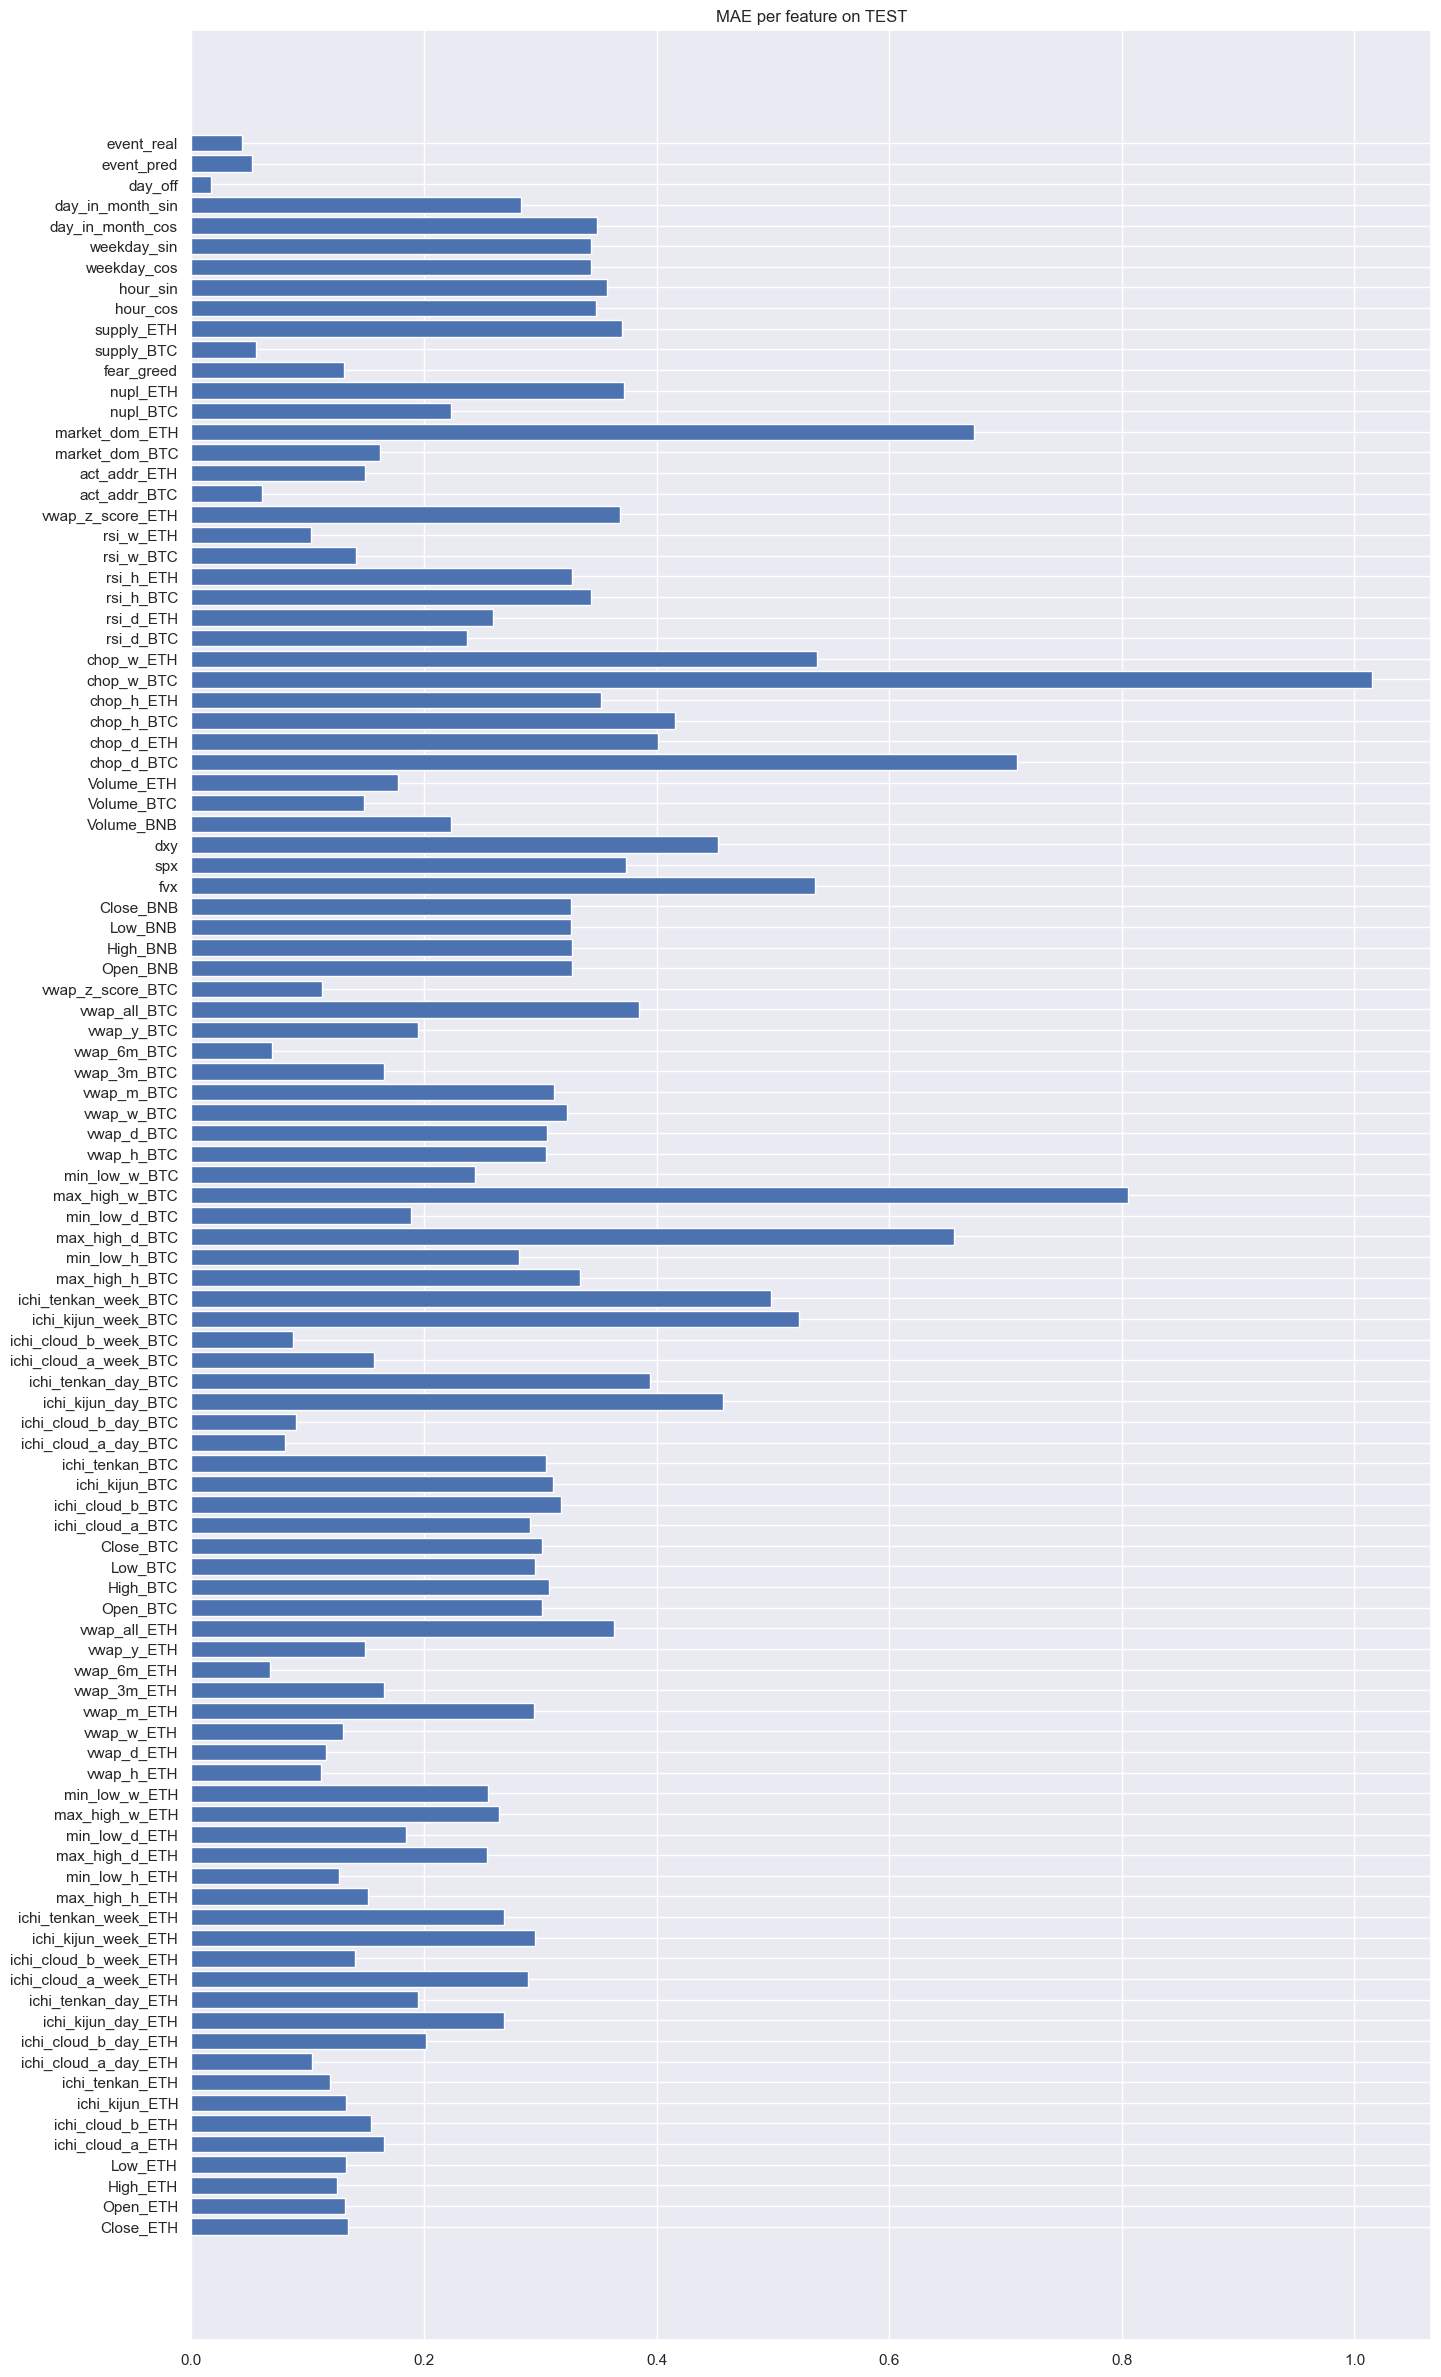

In [118]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [119]:
df_mae_ae_test_feat.values[0]

array([0.13433701, 0.13201329, 0.1252253 , 0.1328883 , 0.16584045,
       0.15485283, 0.1331703 , 0.11889336, 0.10385344, 0.20168456,
       0.26869618, 0.19509856, 0.28928384, 0.14048025, 0.29584442,
       0.26861496, 0.152151  , 0.12725226, 0.25390876, 0.18449159,
       0.26425284, 0.2552135 , 0.11158696, 0.11616437, 0.13034157,
       0.29427774, 0.16548968, 0.06789284, 0.14964772, 0.36331069,
       0.30169509, 0.30718208, 0.29556819, 0.3014526 , 0.29076874,
       0.31741241, 0.31076052, 0.30451021, 0.08056856, 0.09009229,
       0.457134  , 0.39398768, 0.15706774, 0.08730761, 0.52270742,
       0.49828944, 0.33392607, 0.28170636, 0.65552141, 0.18847937,
       0.8055008 , 0.24364714, 0.30470461, 0.30615688, 0.32261214,
       0.31221122, 0.16554923, 0.06973202, 0.19445952, 0.38457568,
       0.11258486, 0.32702227, 0.32687992, 0.32659783, 0.32664031,
       0.53641113, 0.37407787, 0.45292636, 0.22356907, 0.14805691,
       0.17760223, 0.7096355 , 0.40106831, 0.41626481, 0.35201

In [120]:
2/df_mae_ae_test_feat.values[0].sum()

0.07230812729155613

In [121]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.133362
1       TRAIN   Close_ETH  0.139268
2       TRAIN   Close_ETH  0.149265
3       TRAIN   Close_ETH  0.160616
4       TRAIN   Close_ETH  0.166888
...       ...         ...       ...
14683    TEST  event_real  0.043230
14684    TEST  event_real  0.043253
14685    TEST  event_real  0.043214
14686    TEST  event_real  0.043308
14687    TEST  event_real  0.043258

[14688 rows x 3 columns]

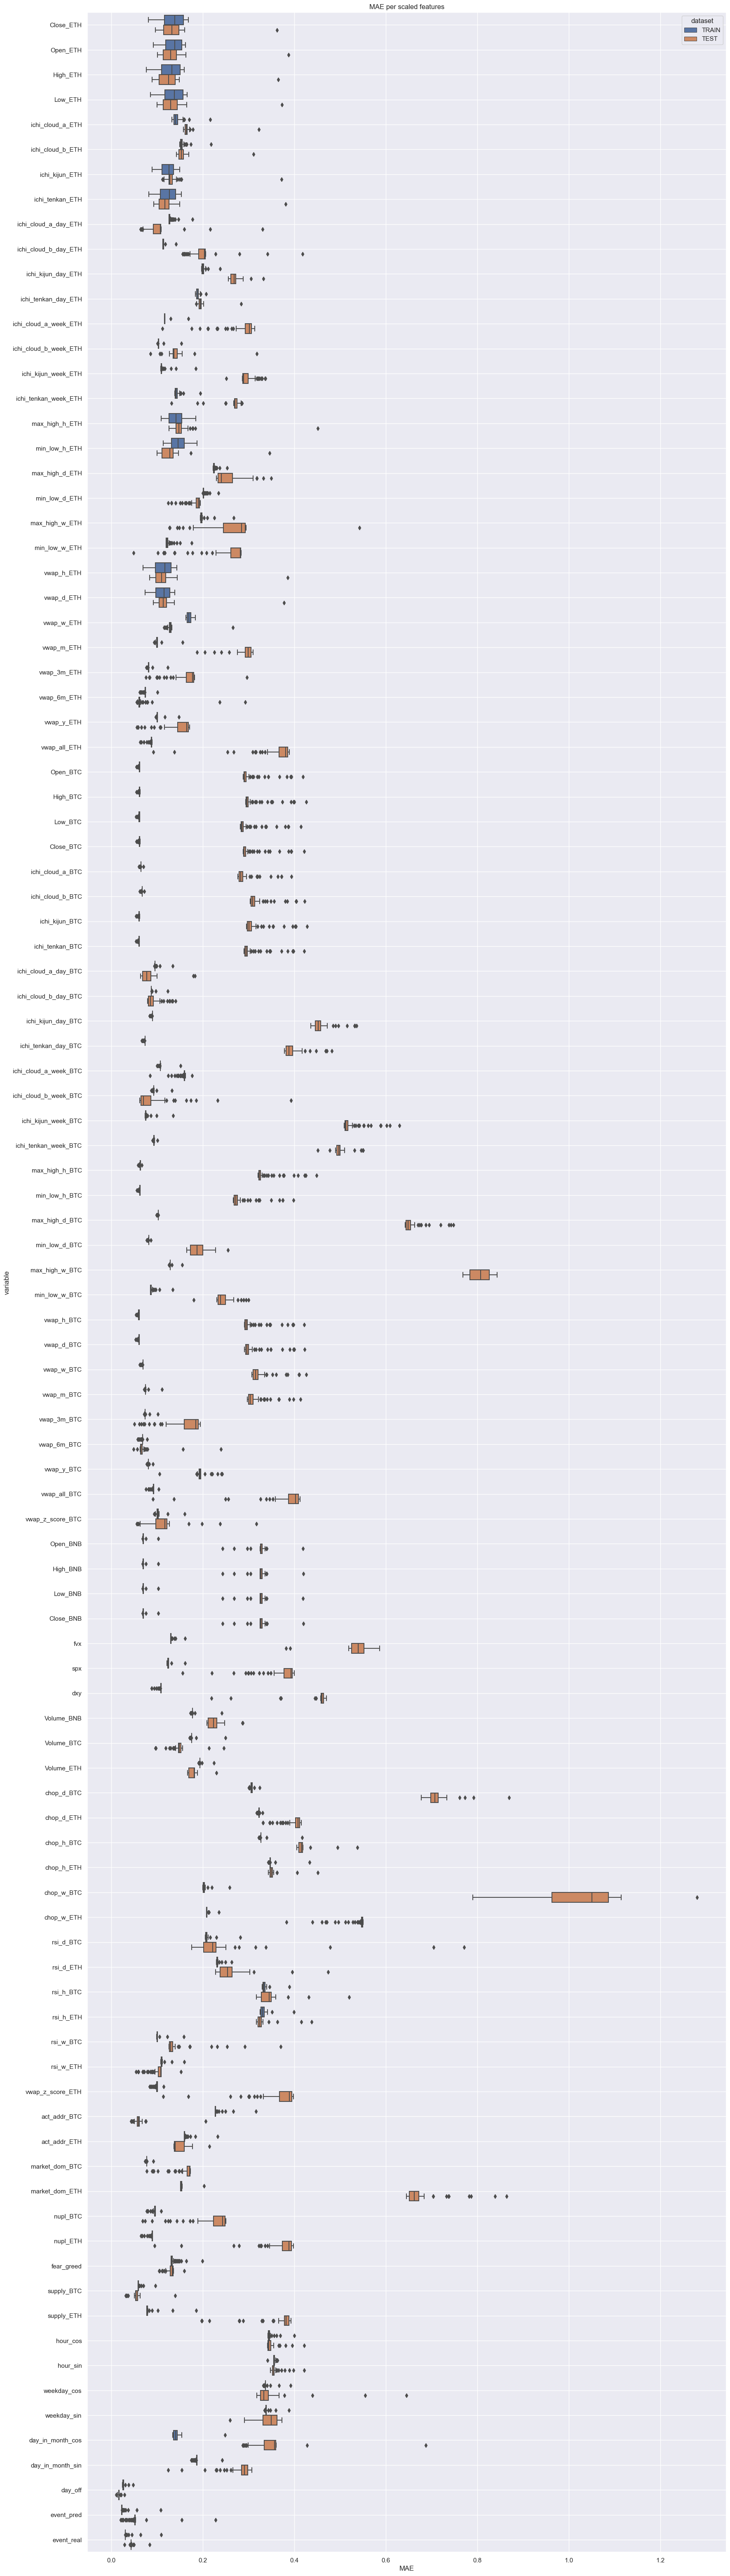

In [122]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [123]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(82882, 72, 102)
(82882, 72, 102)
(72, 102)
(750, 72, 102)
(750, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [124]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.042227  0.040605  0.038200  0.040805          0.046490   
0   0.039691  0.035775  0.032492  0.036910          0.047917   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.054228        0.033560         0.033454              0.033300   
0          0.040900        0.044053         0.030768              0.015509   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.025643  ...  0.147618  0.155981     0.142656     0.145880   
0              0.045098  ...  0.155314  0.158742     0.156156     0.151293   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.030333          0.060524  0.046683    0.005411    0.005625   
0          0.152995          0.101391  0.000412    0.004494    0.003337   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

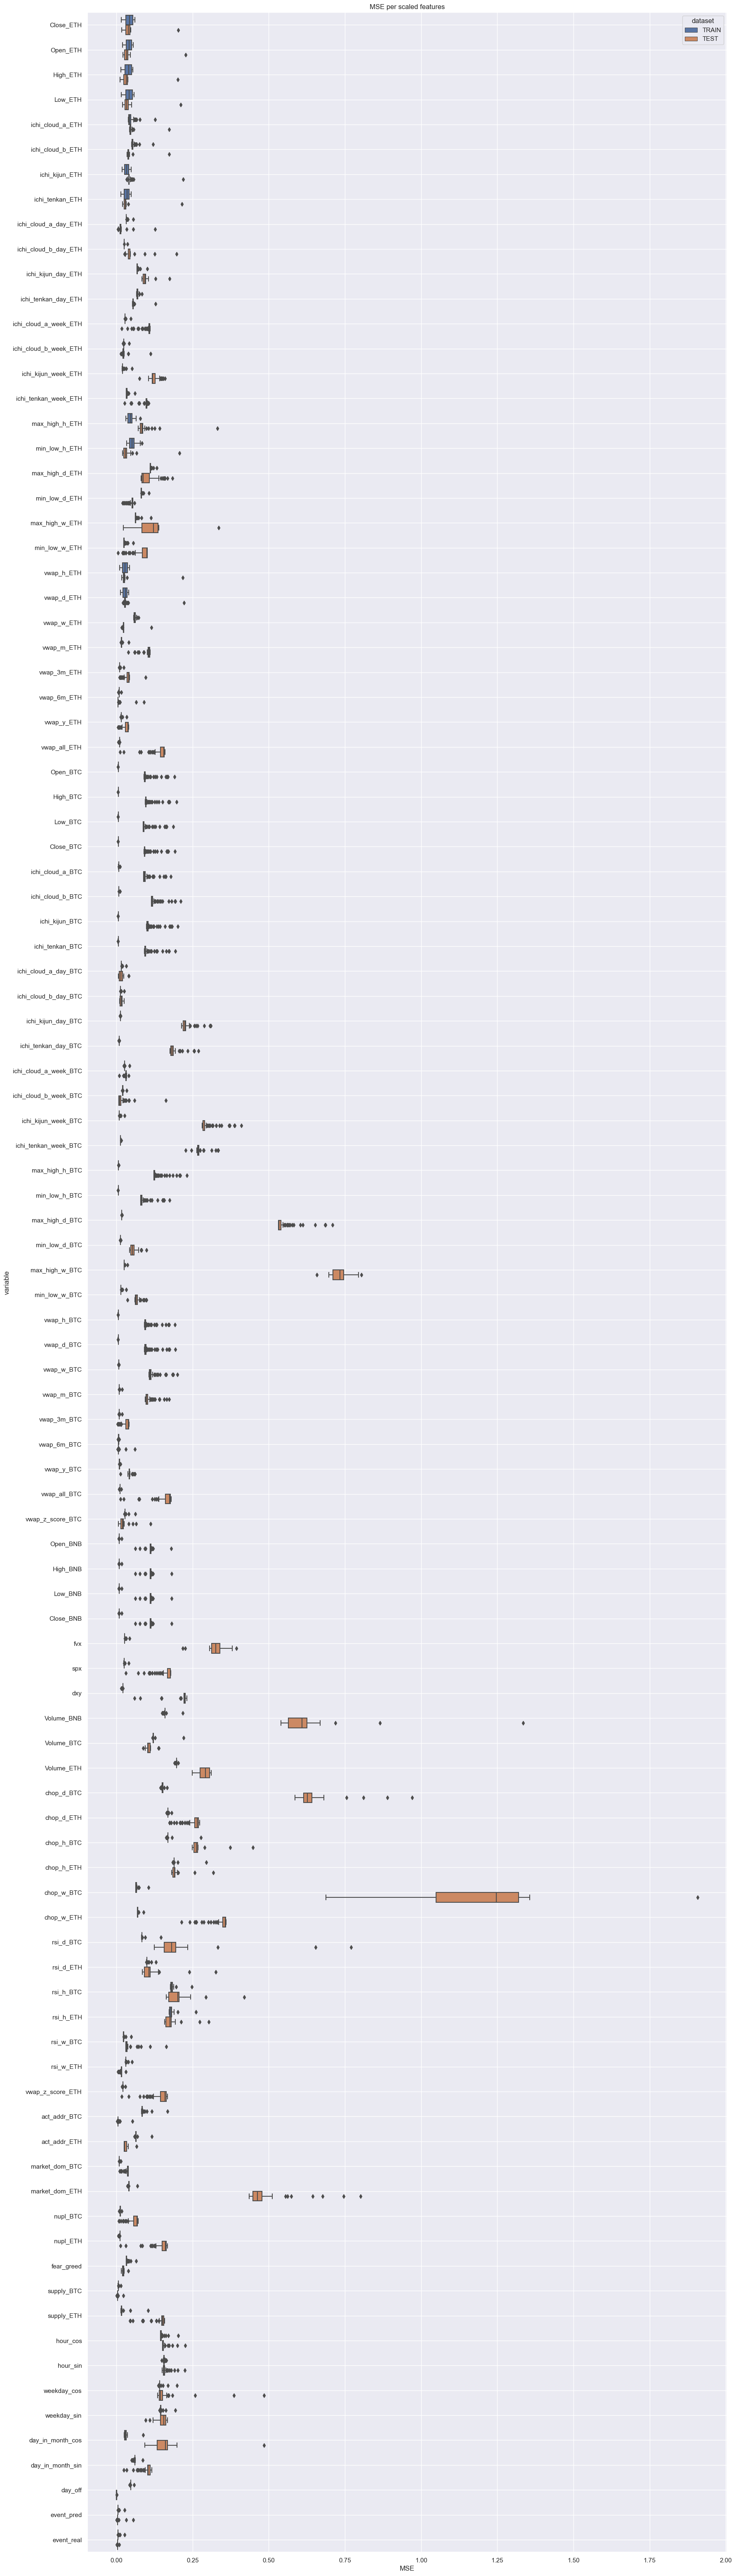

In [125]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

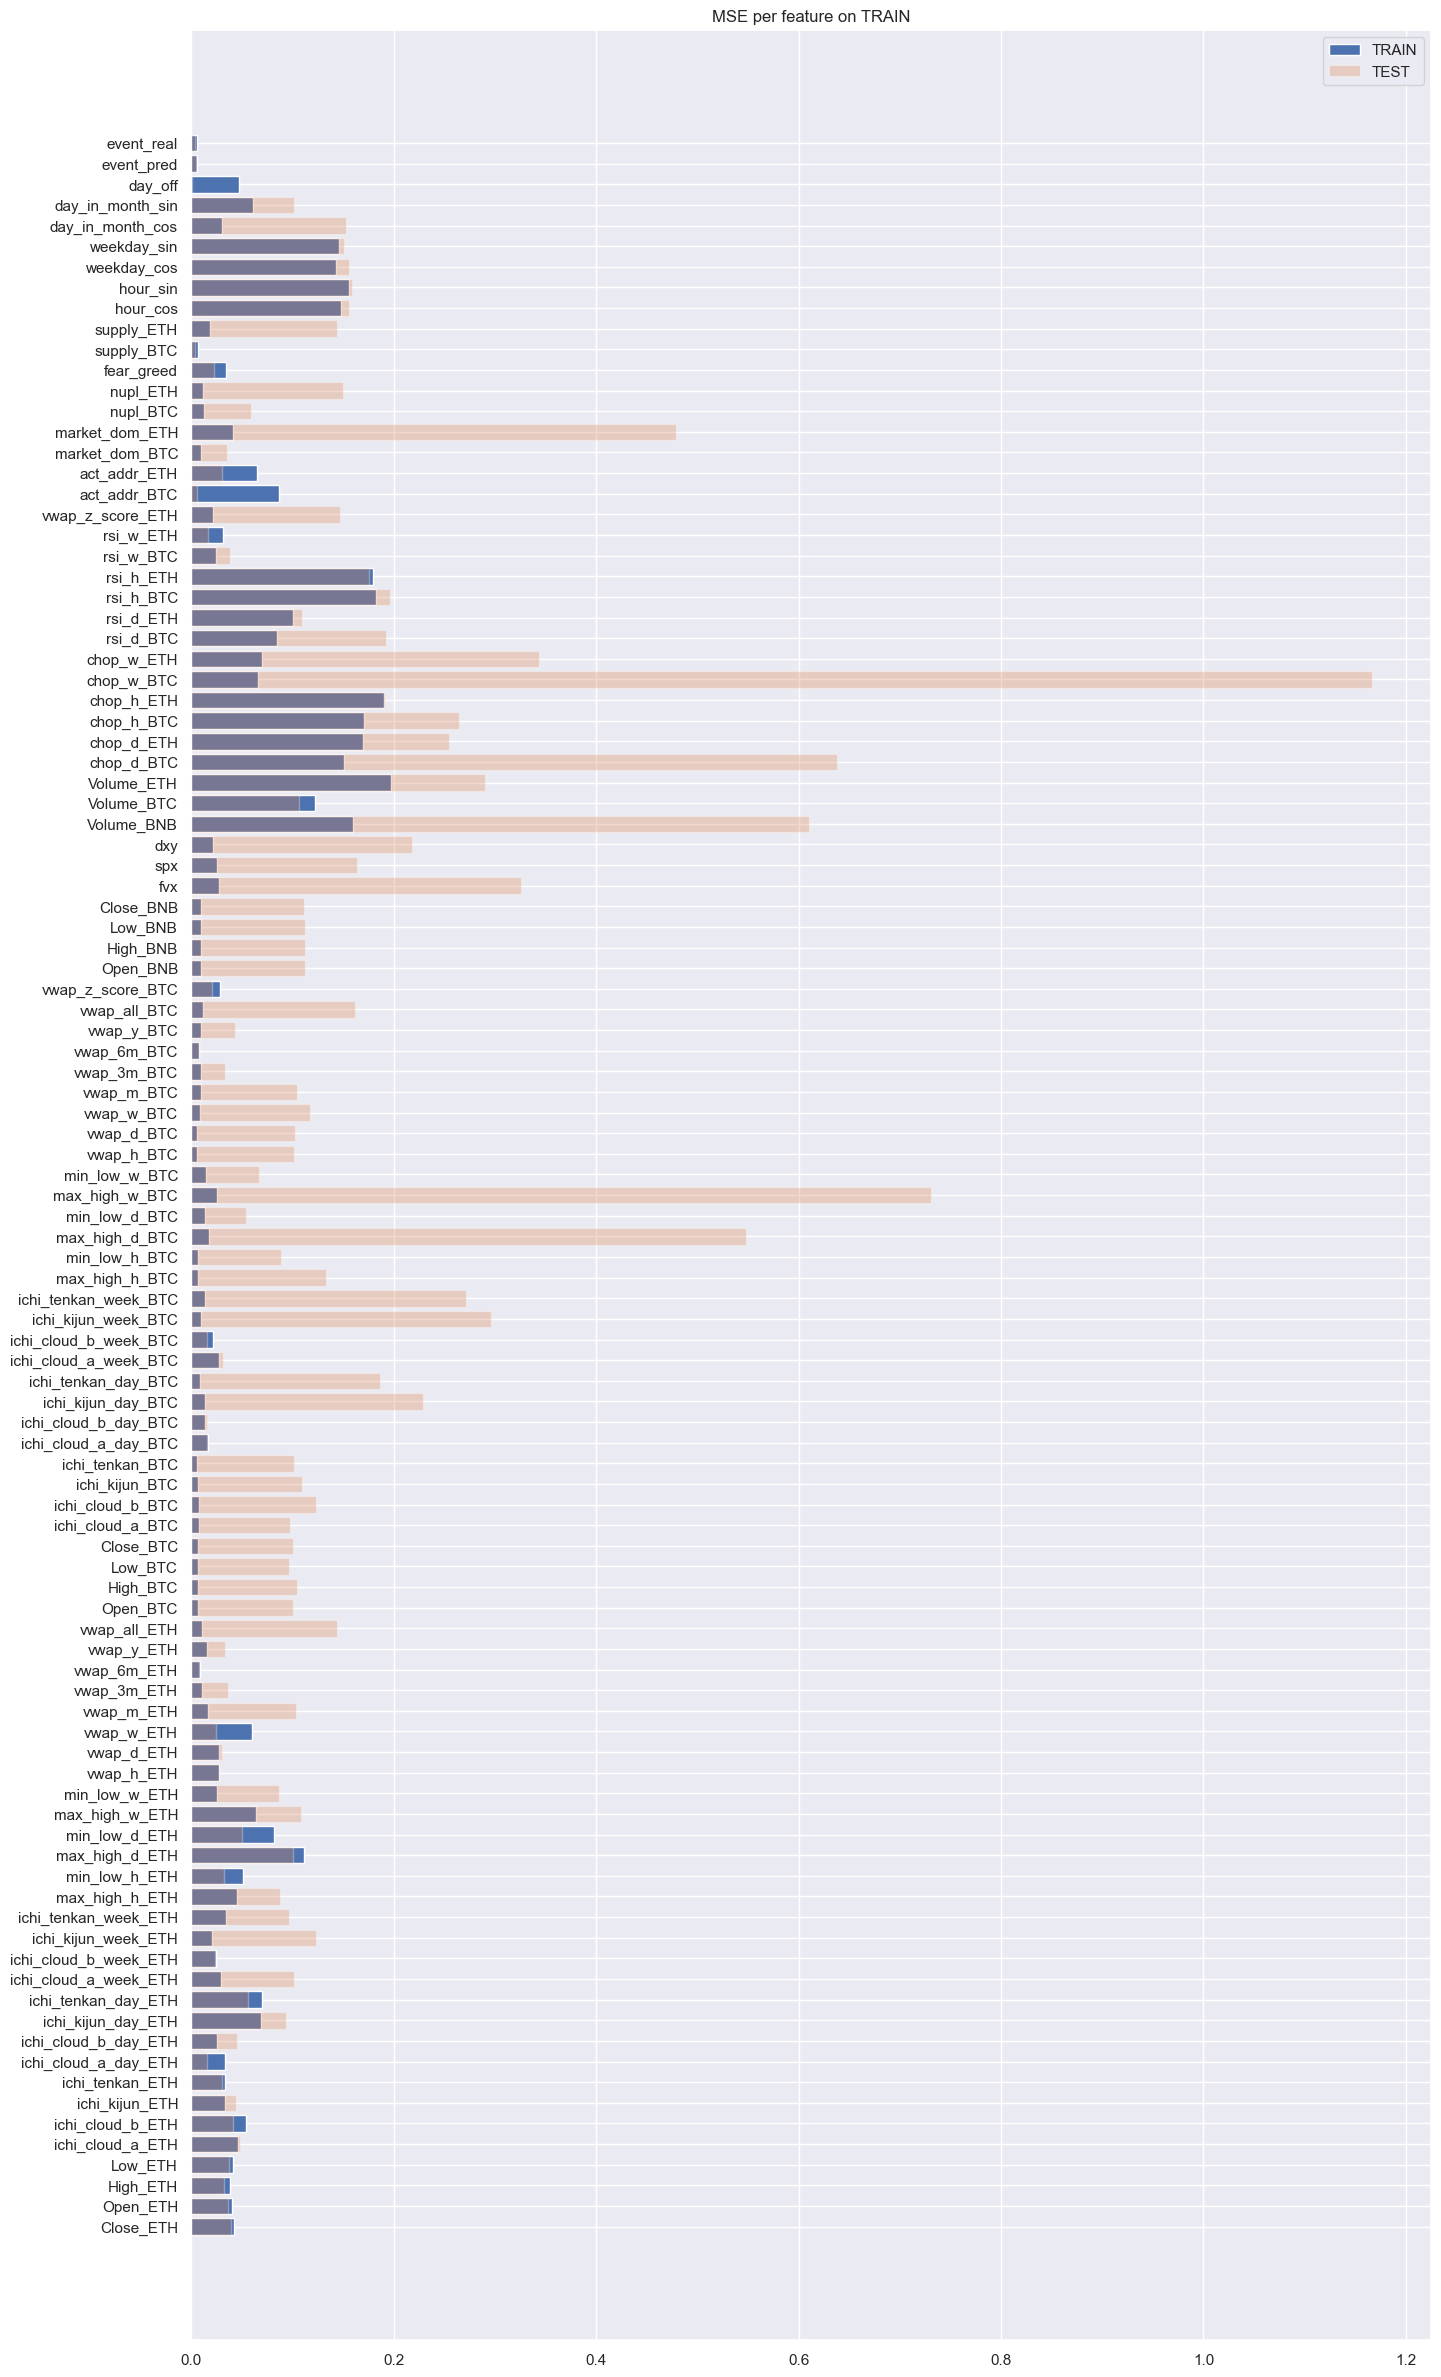

In [126]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [127]:
encoder_model.layers[3].get_weights()

[array([[ 0.20809746,  0.22014324, -0.30978248, ...,  0.14198245,
          0.04063762, -0.19372265],
        [-0.10013966,  0.22373559, -0.20488258, ..., -0.16634086,
         -0.4772873 , -0.55891585],
        [ 0.5015761 ,  0.04277281, -0.47076643, ..., -0.45437434,
         -0.1616357 , -1.5033718 ],
        ...,
        [ 0.27457076,  0.31612223,  0.01806612, ...,  0.48025256,
         -1.3478421 , -0.9029388 ],
        [-0.05034927,  0.06075922,  0.278333  , ..., -1.0298375 ,
          0.27426204, -0.4841736 ],
        [ 0.02021801,  0.00785925, -0.03138242, ..., -0.05250456,
          0.08180287, -0.04386216]], dtype=float32),
 array([ 0.2456733 ,  0.16132893, -0.29319206, -0.49590823,  0.12786907,
        -0.19193521,  0.30815706,  0.16126391,  0.10535993,  0.14666277,
         0.00743759,  0.02723436, -0.00992102,  0.16938455,  0.12125286,
        -0.11637697,  0.35772377, -0.18792826, -0.18246786, -0.01104486,
         0.20244712,  0.14975663,  0.31376985,  0.18473017, -0.294

## Prediction Models

### LSTM all features

In [128]:
X_train_sca.shape

(82882, 72, 102)

In [129]:
X_train_sca.shape[-1]

102

In [130]:
X_train_sca.shape[-2:]

(72, 102)

In [131]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [132]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [133]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

2591/2591 [==============================] - 26s 10ms/step


(82882, 72, 32)

In [134]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

24/24 [==============================] - 0s 13ms/step


(750, 72, 32)

In [135]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



In [136]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [137]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [138]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((82882, 72, 36), (750, 72, 36))

#### Correlations

In [139]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



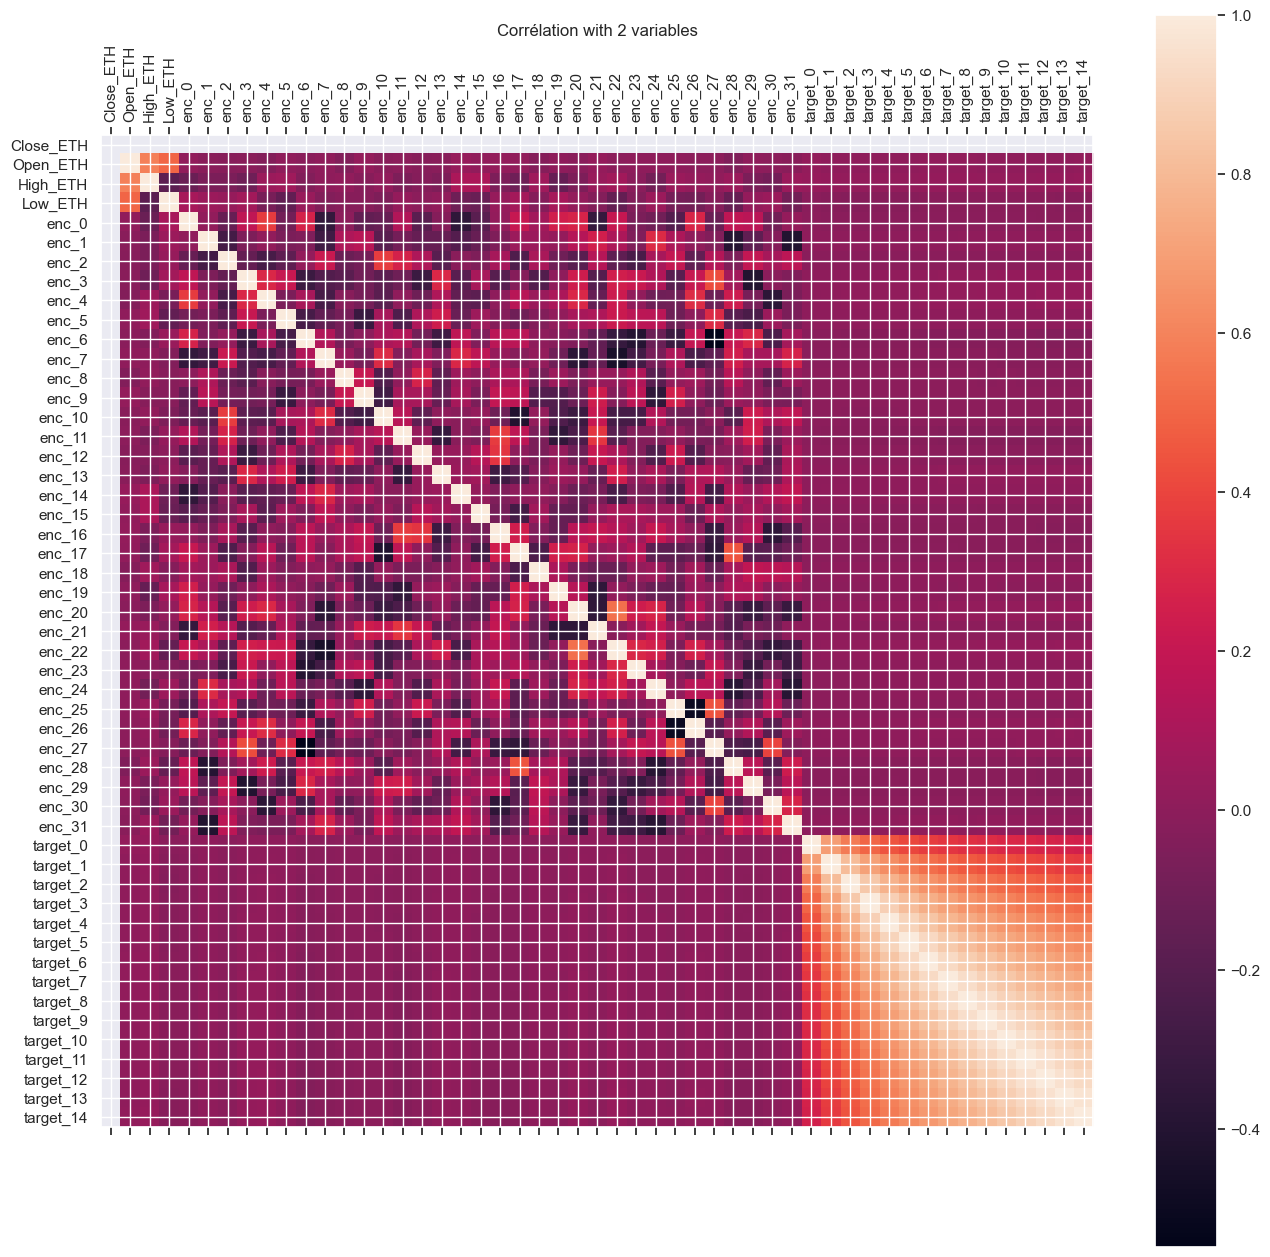

In [140]:
fig = plot_corr(corr_matrix_min)

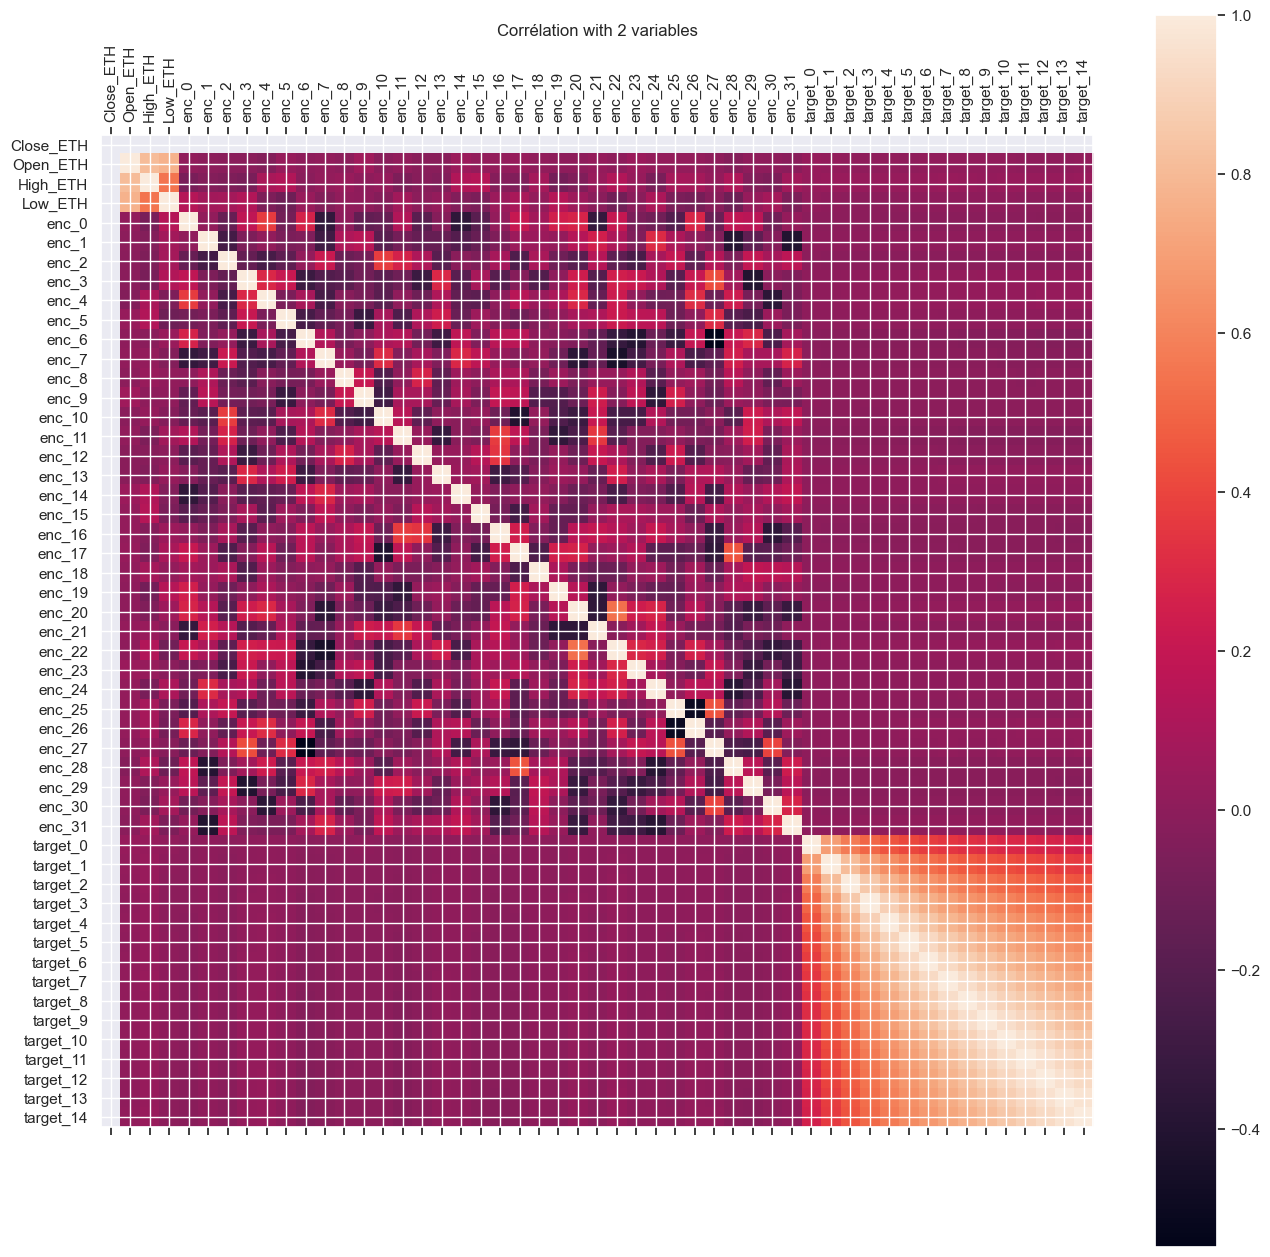

In [141]:
fig = plot_corr(corr_matrix_max) 

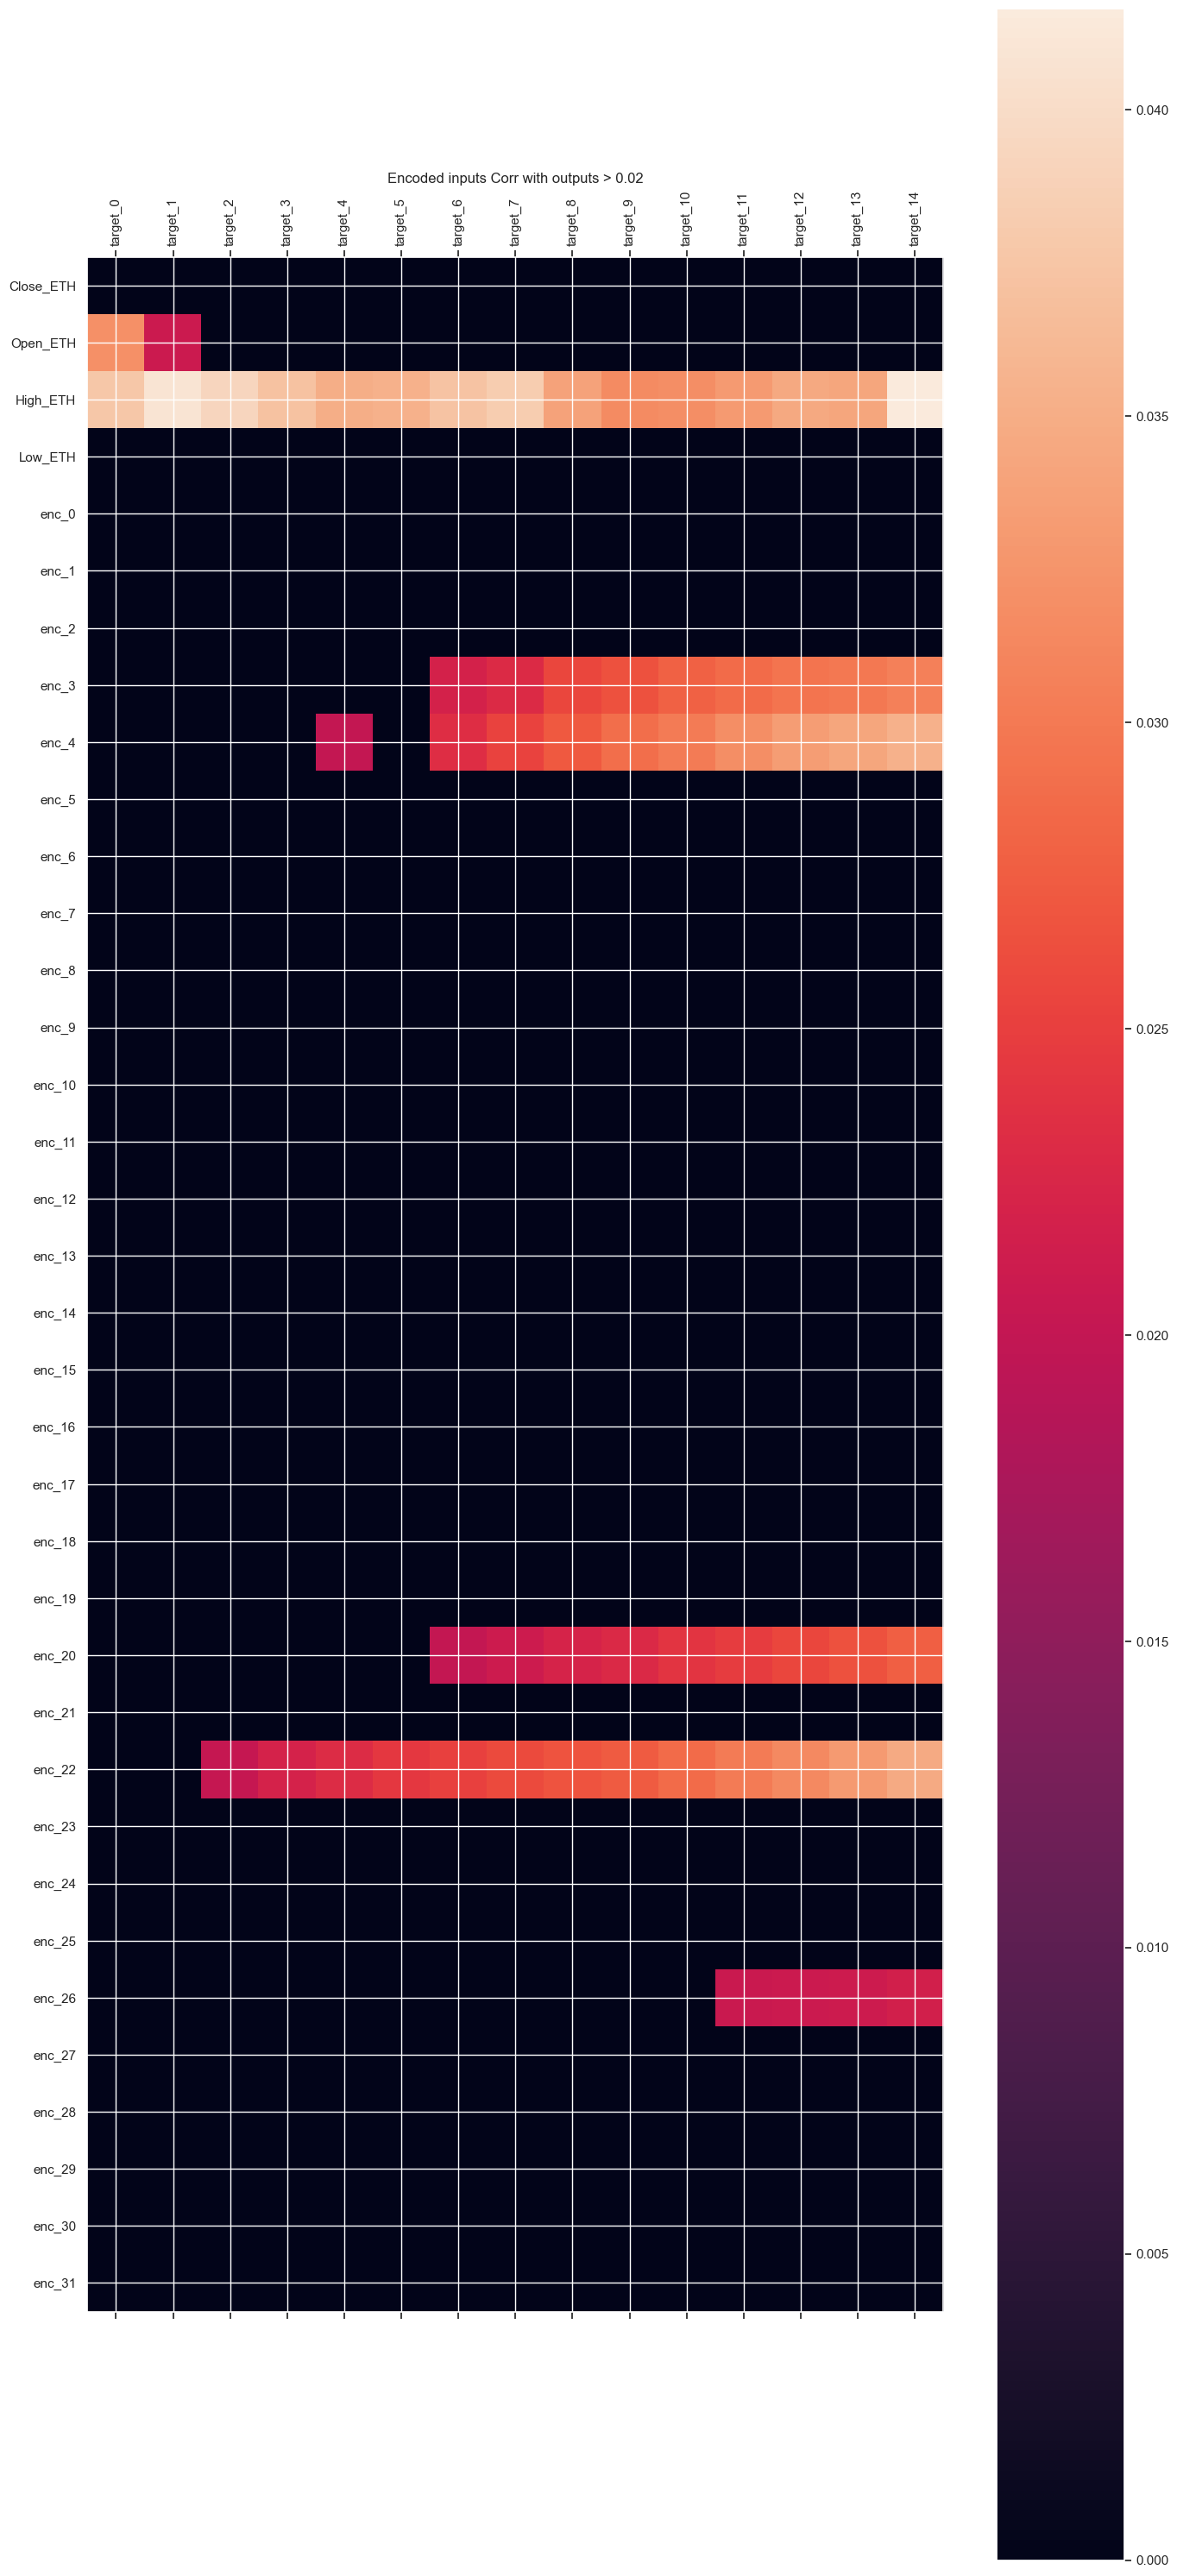

In [142]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

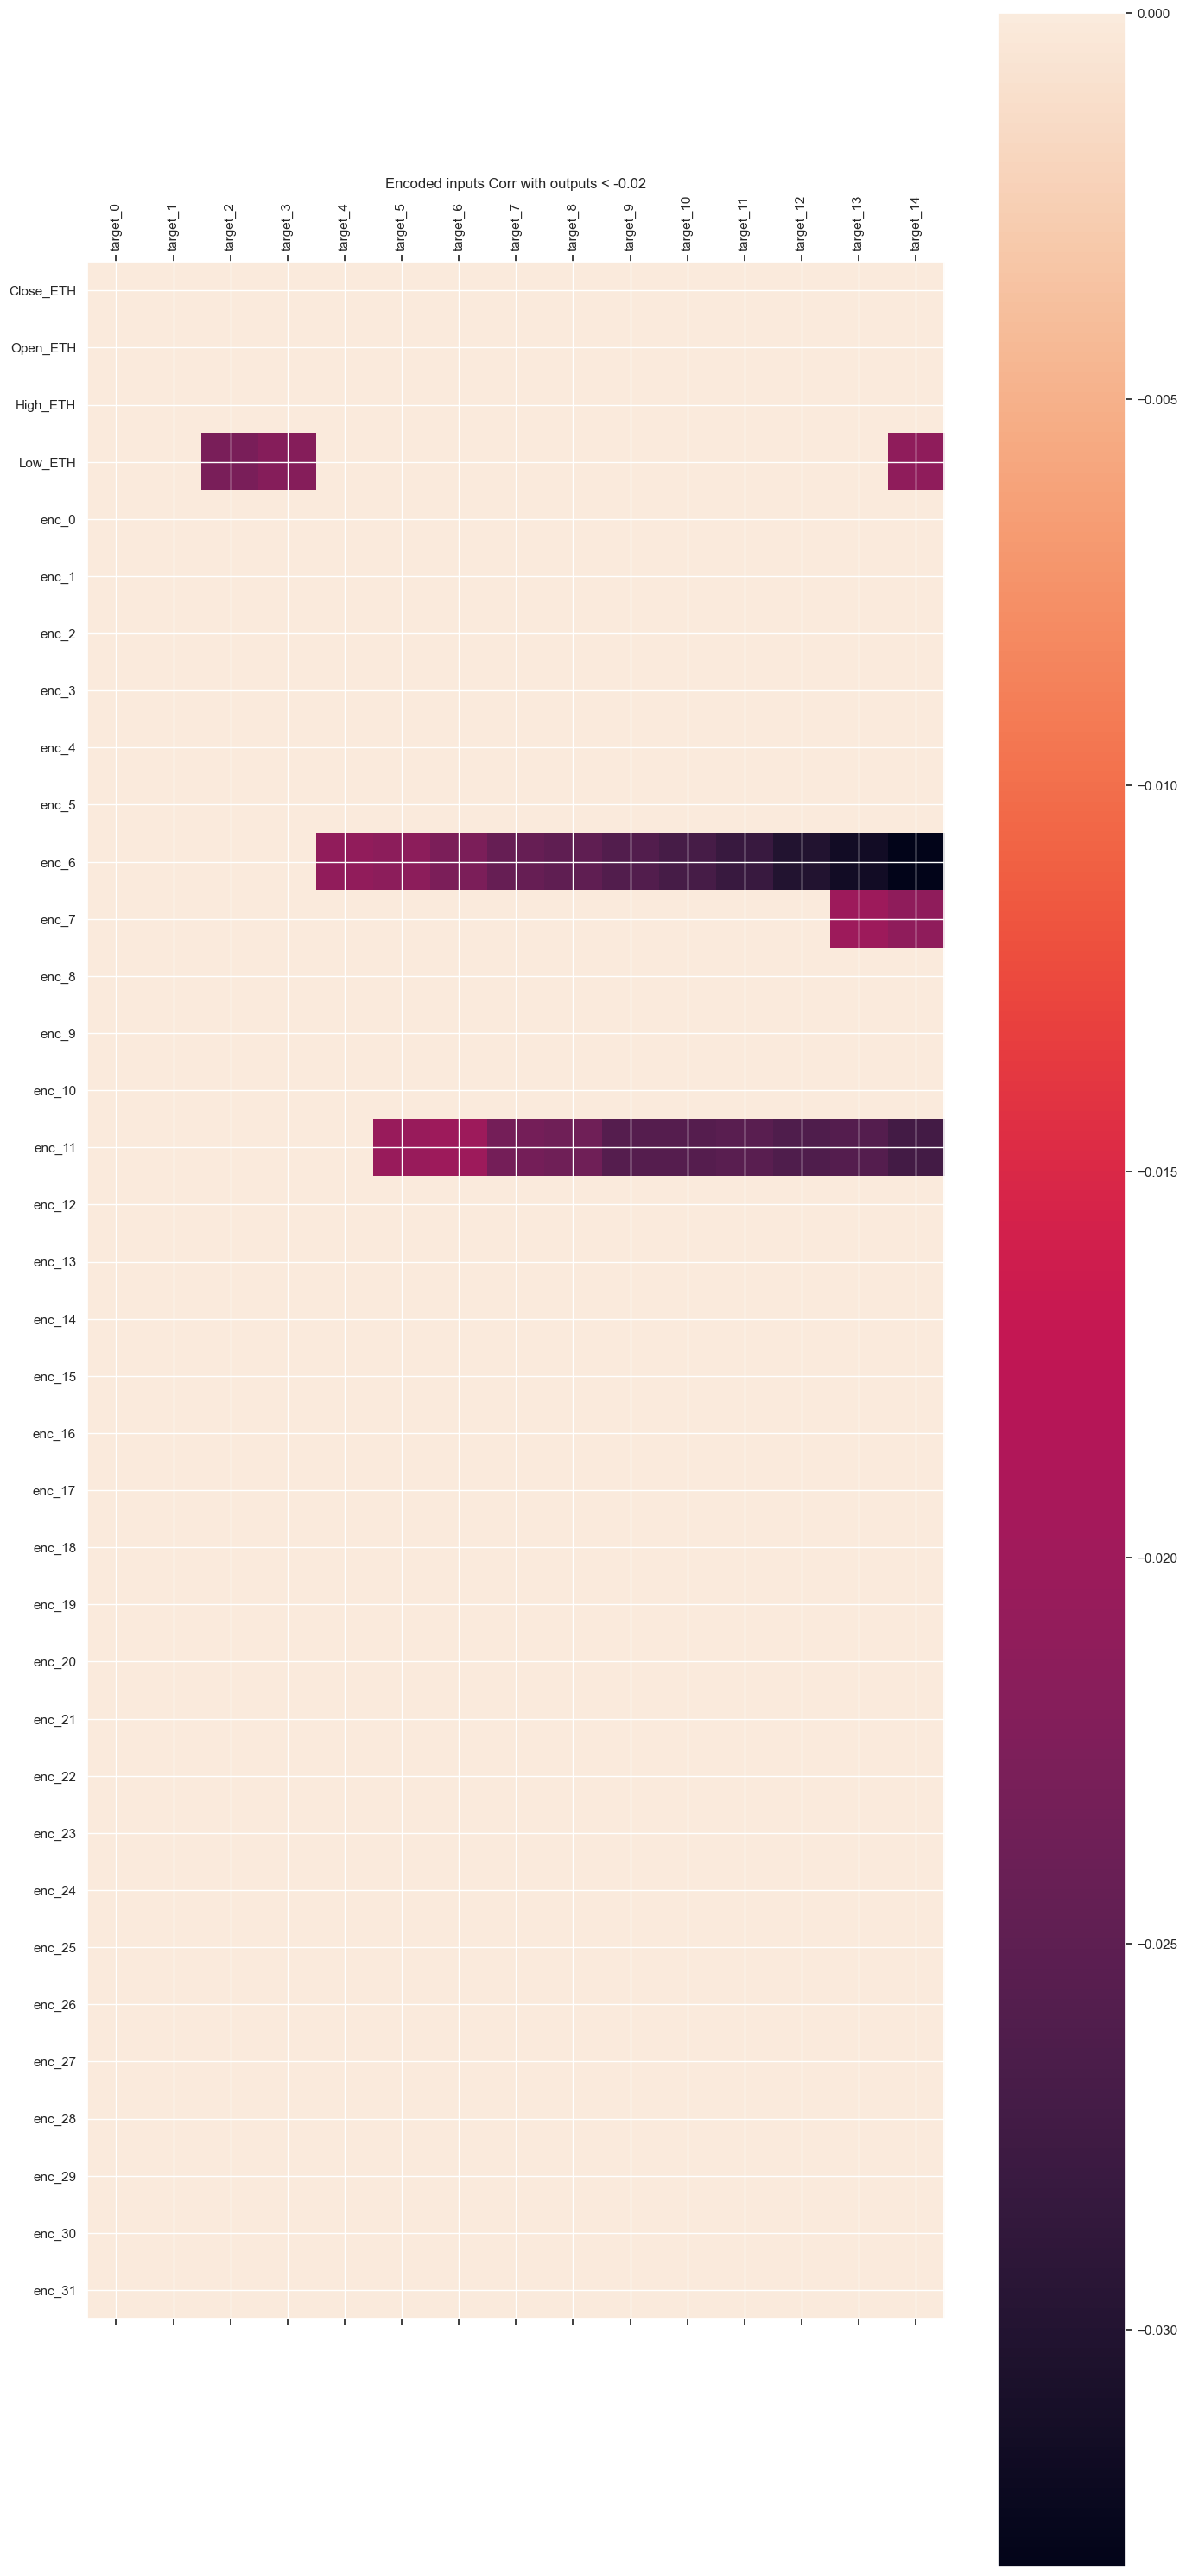

In [143]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [144]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [145]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [146]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [147]:
MODE_AUTO_SELECT

0

In [148]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
nb encoded features:  32


In [149]:
X_train_.shape

(82882, 72, 36)

In [150]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [151]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [152]:
X_train_.shape

(82882, 72, 36)

#### Train

Epoch 1/400
324/324 [==============================] - 10s 26ms/step - loss: 1.2172 - val_loss: 0.6697
Epoch 2/400
324/324 [==============================] - 8s 24ms/step - loss: 0.9547 - val_loss: 0.8260
Epoch 3/400
324/324 [==============================] - 7s 23ms/step - loss: 0.8939 - val_loss: 1.1347
Epoch 4/400
324/324 [==============================] - 7s 23ms/step - loss: 0.8348 - val_loss: 0.7188
Epoch 5/400
324/324 [==============================] - 7s 23ms/step - loss: 0.7680 - val_loss: 1.0075
Epoch 6/400
324/324 [==============================] - 7s 23ms/step - loss: 0.7148 - val_loss: 5.3069
Epoch 7/400
324/324 [==============================] - 8s 24ms/step - loss: 0.6597 - val_loss: 8.3837
Epoch 8/400
324/324 [==============================] - 7s 23ms/step - loss: 0.6173 - val_loss: 13.8377
Epoch 9/400
324/324 [==============================] - 8s 23ms/step - loss: 0.5889 - val_loss: 6.7833
Epoch 10/400
324/324 [==============================] - 8s 23ms/step - loss: 0.5

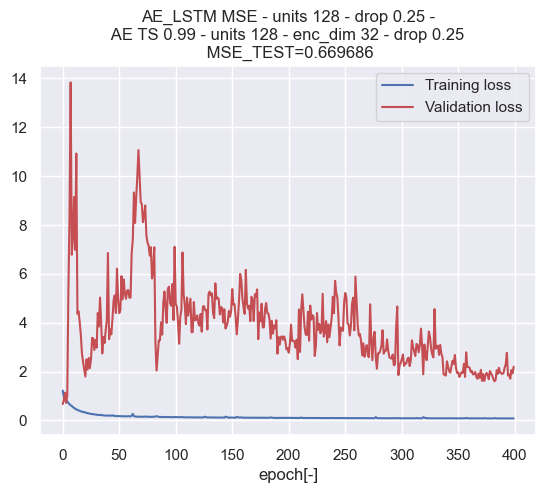

Save model:  data/mdl_predict_autoenc_lstm
INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


Load model:  data/mdl_predict_autoenc_lstm
Best model: n_units=128 / dropout= 0.25
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               84480     
                                                                 
 layer_normalization (Layer  (None, 128)               256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
Total params: 86671 (338.56 KB)
Trainable params: 86671 (338.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
N

In [153]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 400#30
patience = 0#10
#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)

mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in [128]: #[32, 64, 128]: #[128]: #
        for dropout_rate in  [0.25]: #[0.05, 0.15, 0.25]: #[0.1]:
            for seed in LIST_SEEDS:
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.AdamW()
                if patience is not None:
                    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                    verbose=1, patience=patience,
                                                    restore_best_weights=True)
                # create model
                multi_step_model = tf.keras.models.Sequential()
                multi_step_model.add(
                    tf.keras.layers.LSTM(
                        n_units,
                        return_sequences=False,
                        input_shape=X_train_.shape[-2:],
                        #kernel_regularizer=reg,
                        #bias_regularizer=reg,
                    )
                )
                multi_step_model.add(tf.keras.layers.LayerNormalization())
                multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
                #multi_step_model.add(tf.keras.layers.BatchNormalization())
                multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
                # compile
                multi_step_model.compile(optimizer=optim, loss='mse')
                # fitting
                if patience == 0:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1,
                    )
                else:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1, 
                        callbacks=[es],
                    )
                # eval
                if patience !=0:
                    # mode min val loss
                    i_epoch = np.argmin(multi_step_history.history['val_loss'])
                    mse_curr_train = multi_step_history.history['loss'][i_epoch]
                    mse_curr = multi_step_history.history['val_loss'][i_epoch]
                else:
                    # mode last
                    mse_curr_train = multi_step_history.history['loss'][-1]
                    mse_curr = multi_step_history.history['val_loss'][-1]

                print("MSE TRAIN : ", mse_curr_train)
                print("MSE TEST : ", mse_curr)
                    
                # plot MSE
                name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                plot_train_history(
                    multi_step_history,
                    f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                    saveFolder="data",
                )

                # save the best
                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate

                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_units_min = n_units
                        dropout_rate_min = dropout_rate
                        print("Save model: ", path_mdl_predict_autoenc_lstm)
                        multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

    
print("Load model: ", path_mdl_predict_autoenc_lstm)
multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
n_units = multi_step_model.layers[0].units#32
dropout_rate = multi_step_model.layers[2].rate#0.25
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
print(multi_step_model.summary())

In [154]:
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=128 / dropout= 0.25


In [155]:
np.min(y_train)

0.8990060972444147

In [156]:
np.max(y_train)

1.087790104524251

#### Results

##### Save mdl

In [214]:
X_train_.shape

(82882, 72, 36)

##### Predict

In [215]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

24/24 [==============================] - 0s 11ms/step


##### Plots

In [216]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(82890,)
(82890,)


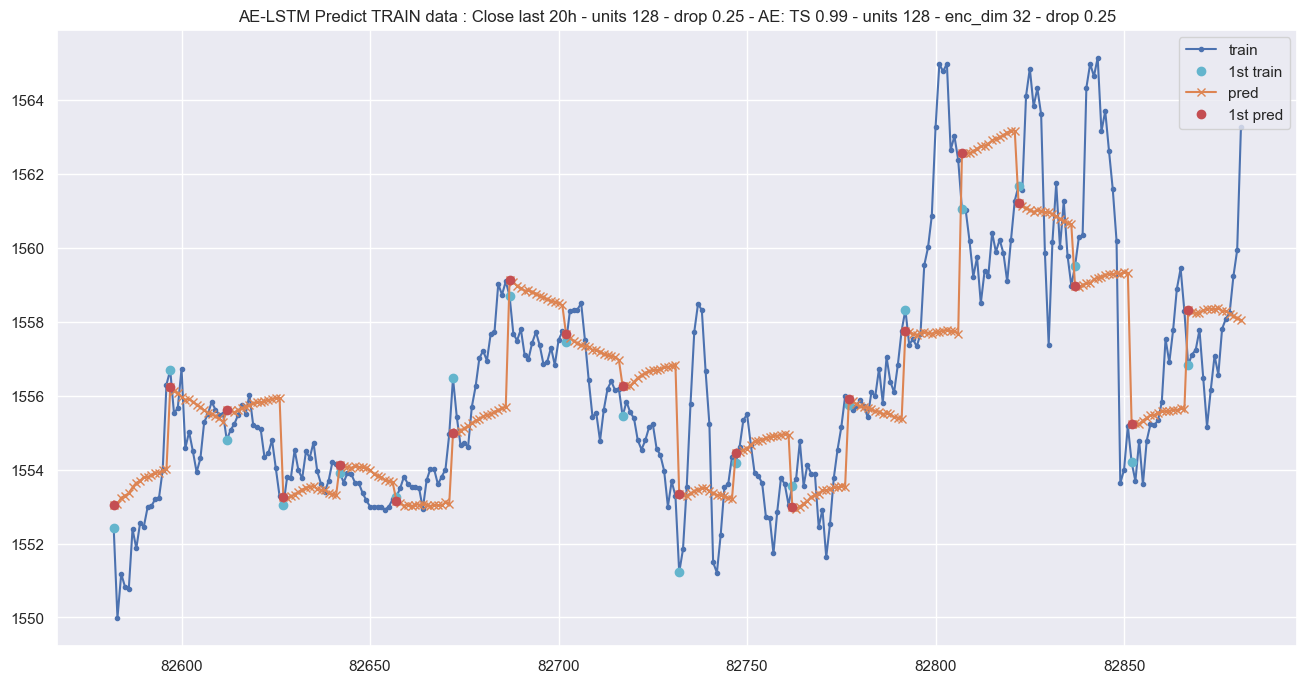

In [217]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

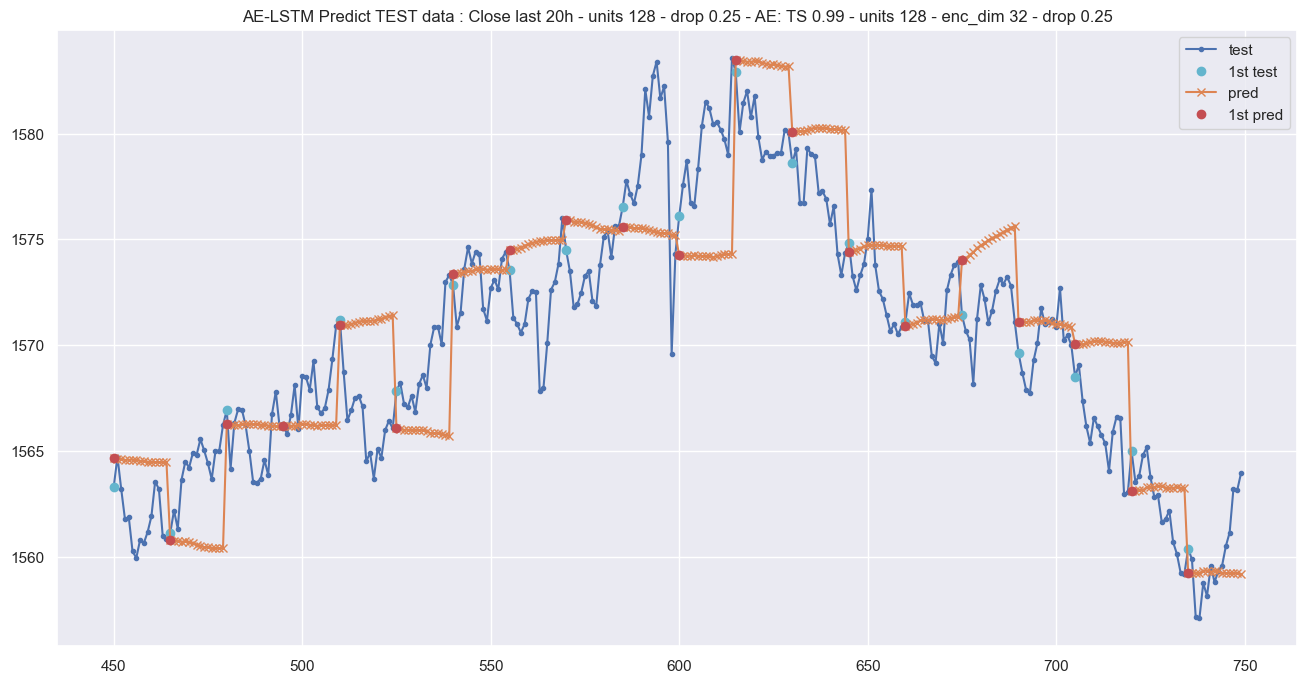

In [218]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

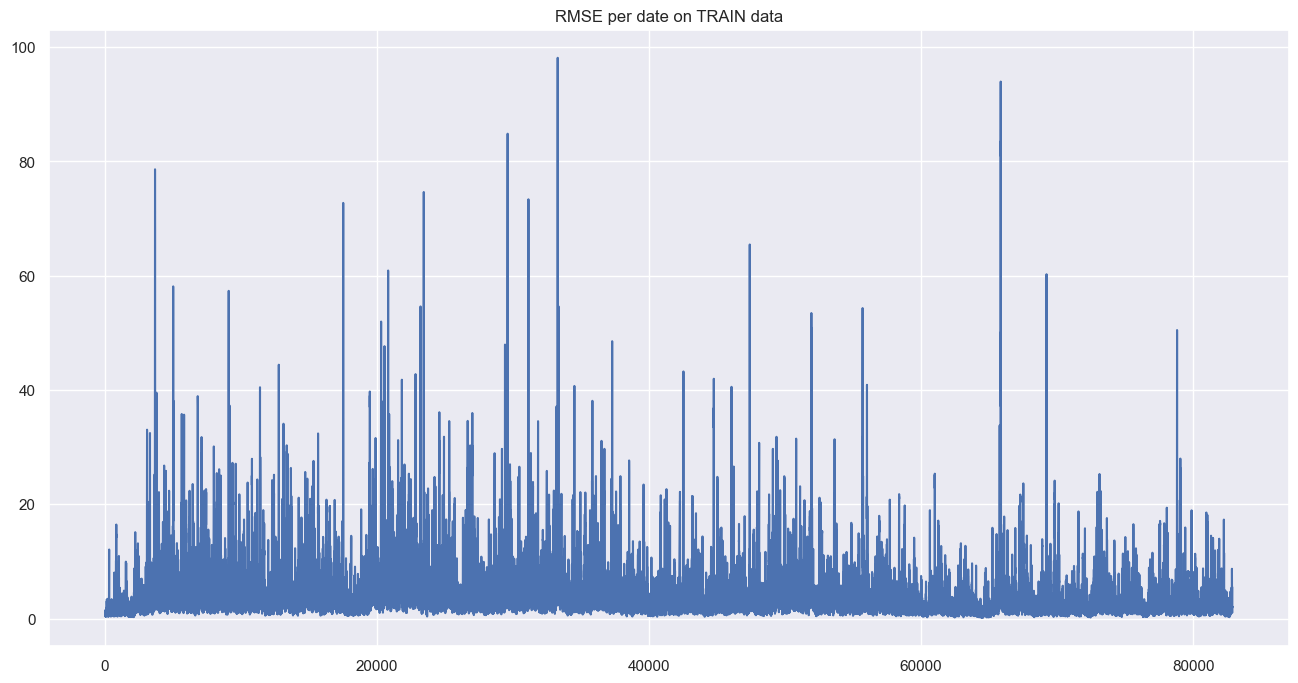

In [219]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

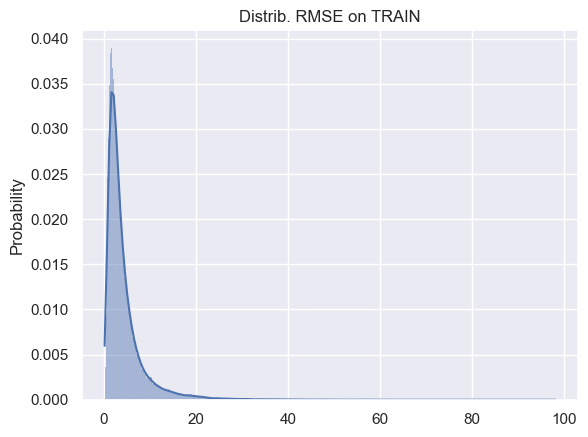

In [220]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 4.42')

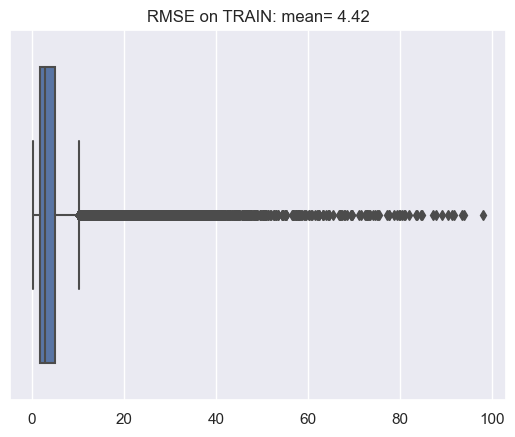

In [221]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

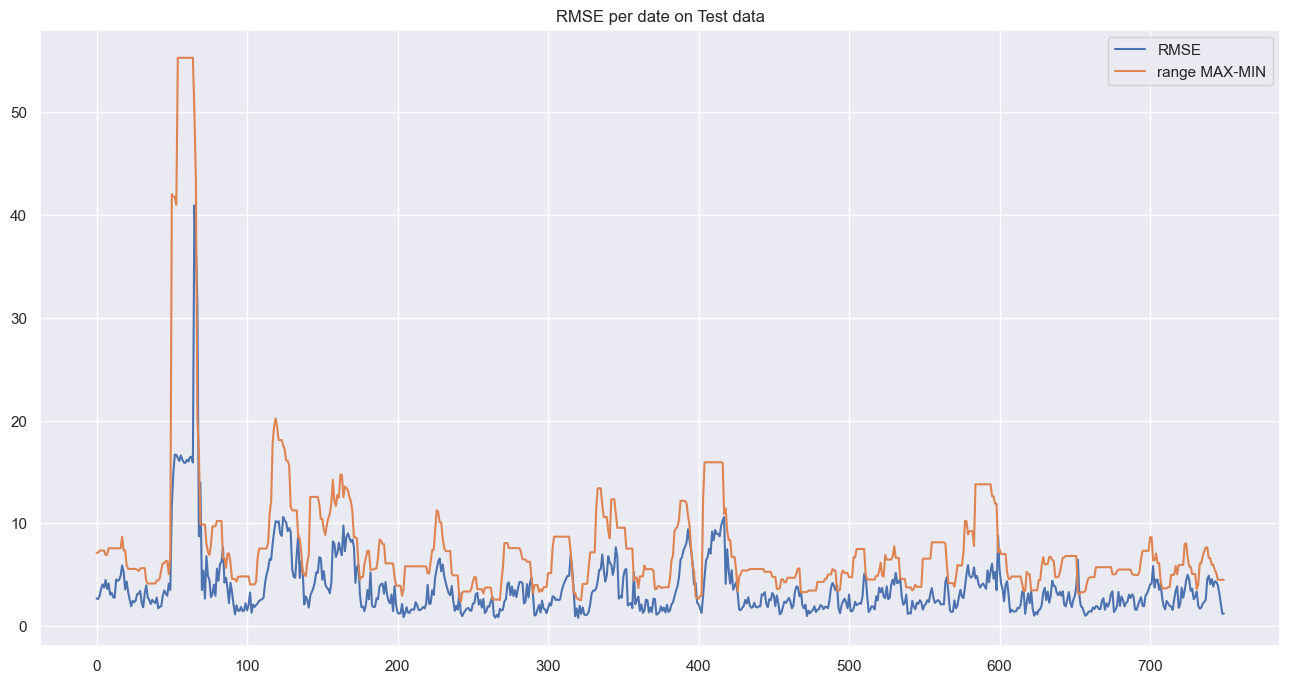

In [222]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [223]:
np.mean(arr_range)

7.814093333333324

<AxesSubplot: ylabel='Probability'>

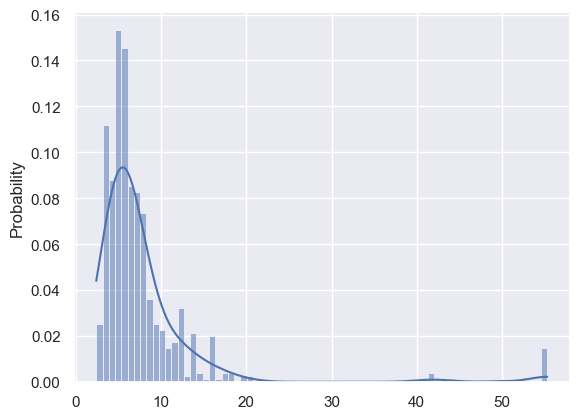

In [224]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [225]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

6.819343424317395

<AxesSubplot: ylabel='Probability'>

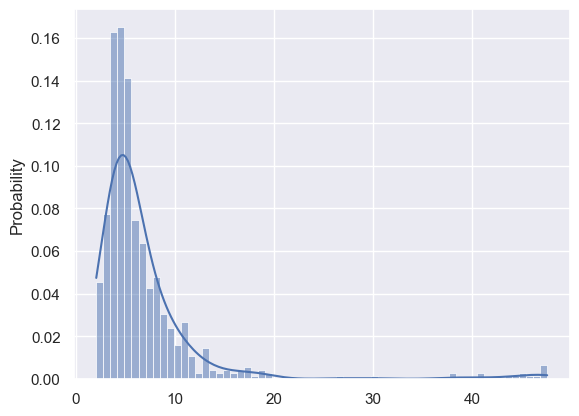

In [226]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

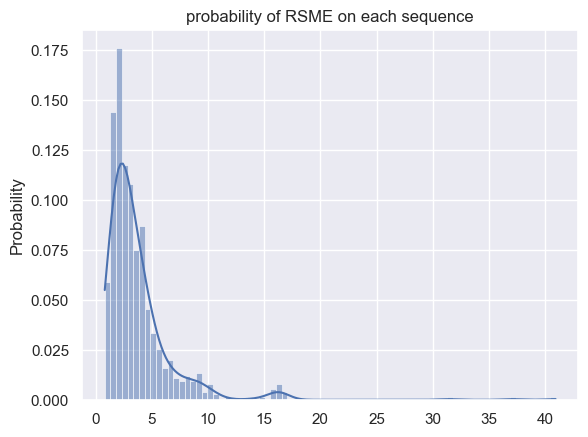

In [227]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 39.07046666666662)

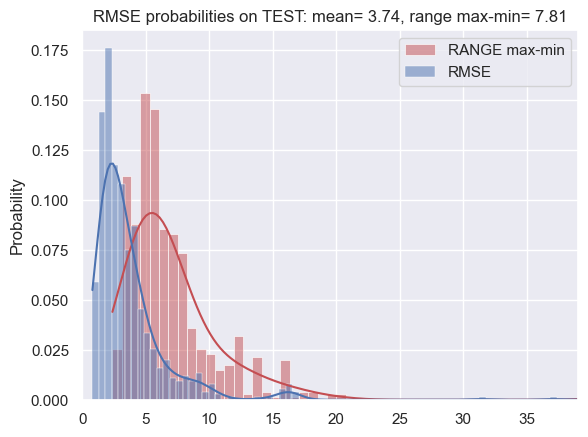

In [228]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 18.703382840977987)

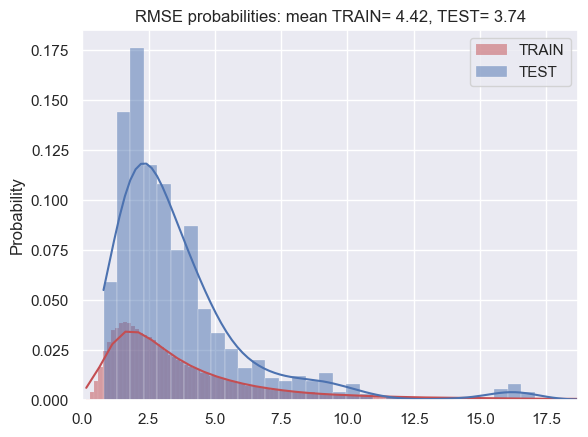

In [229]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 3.74')

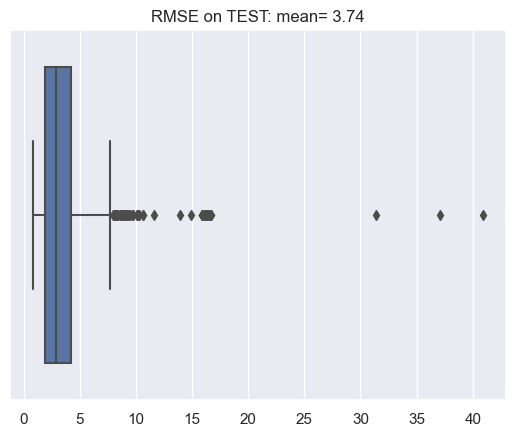

In [230]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [231]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1563.21 1563.14 1563.94 1564.39 1564.77 1564.17 1563.73 1564.61 1563.61
 1563.52 1563.86 1560.27 1561.39 1561.93 1563.03]
[1561.22351092 1561.24621555 1561.28101692 1561.34410604 1561.46507336
 1561.58343524 1561.5864129  1561.6176783  1561.63386931 1561.60260391
 1561.64764098 1561.67071782 1561.70030829 1561.67555652 1561.65824888]


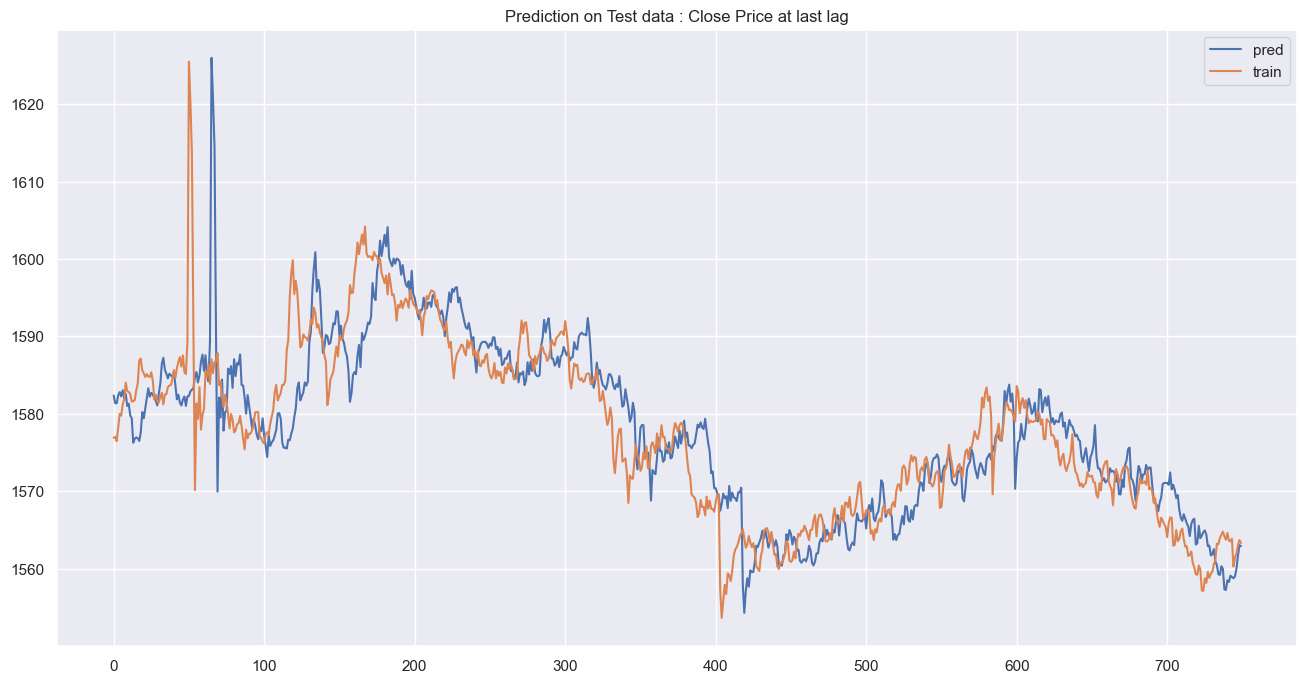

In [232]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

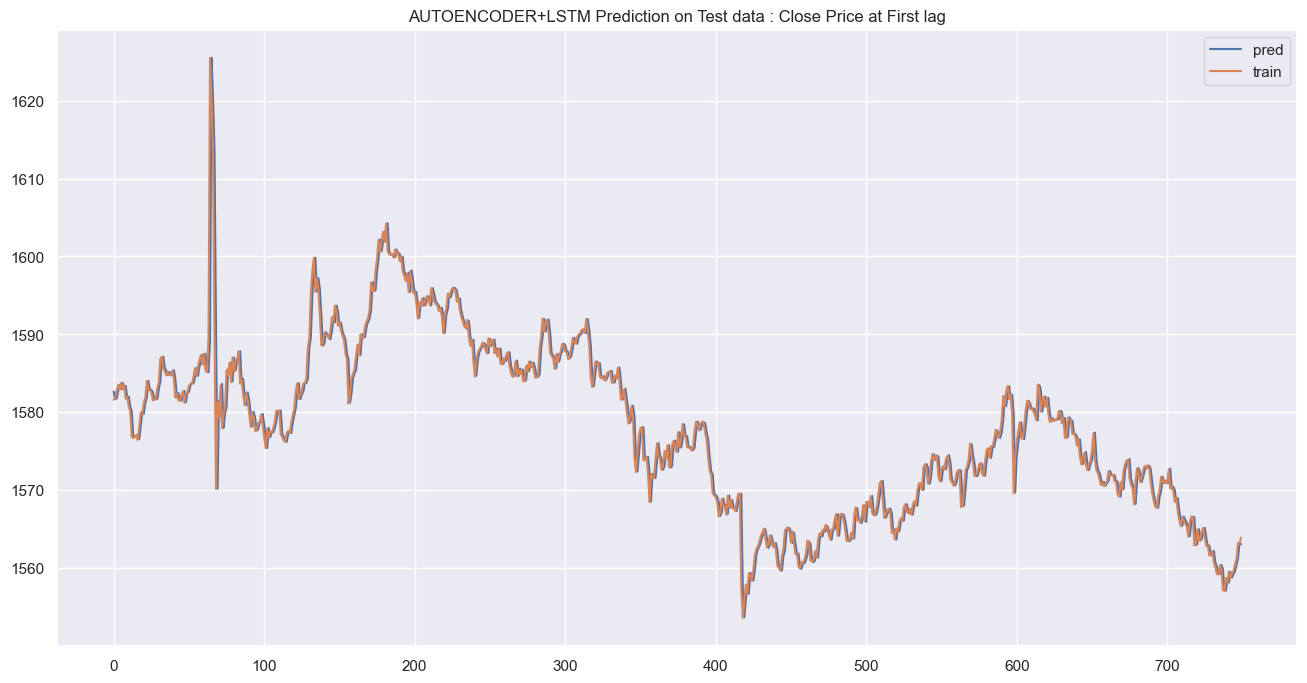

In [233]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

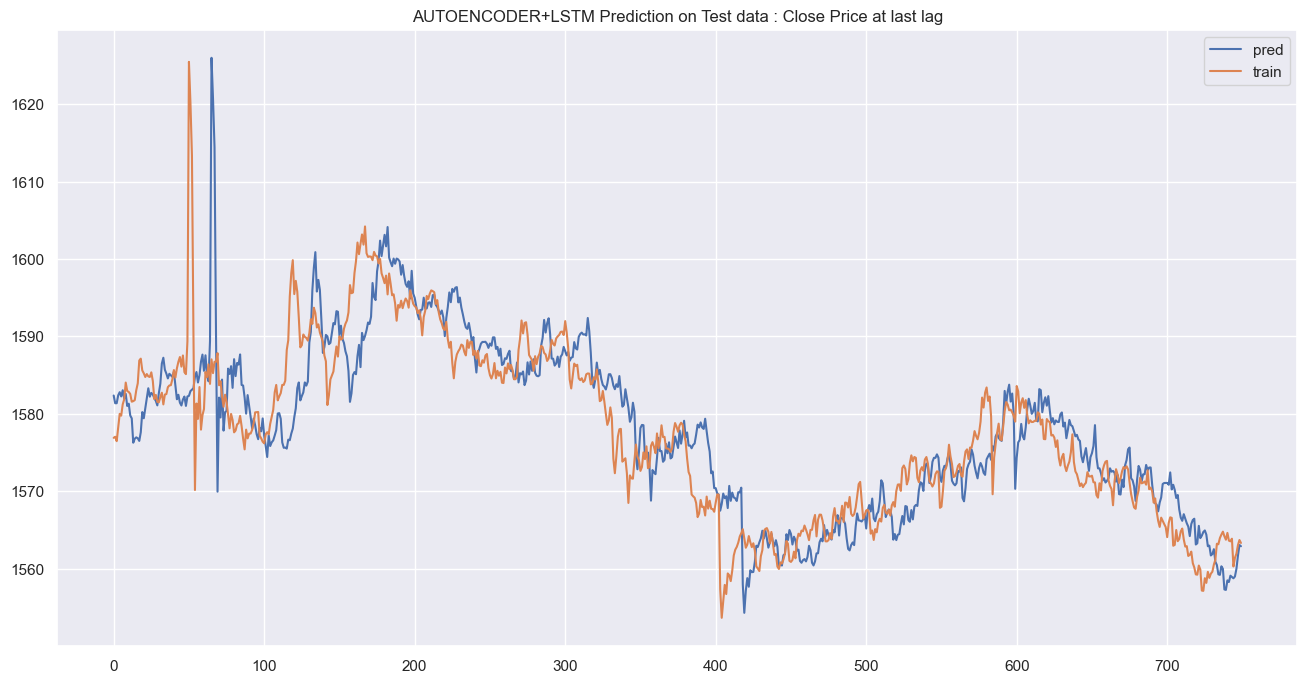

In [234]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [235]:
X_test_sca.shape

(750, 72, 102)

In [236]:
df_feat["Close_ETH"].iloc[-1]

1563.1

In [237]:
df_feat["Close_ETH"].iloc[-1]

1563.1

In [238]:
len(list_i_enc_select)

32

In [239]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1567.72 1569.28 1570.09 1571.75 1571.01 1571.09 1571.25 1570.84 1572.7
 1570.25 1570.46 1570.01 1568.51 1569.07 1567.37 1566.16 1565.38 1566.58
 1566.16 1565.75 1565.36 1564.06 1565.9  1566.62 1566.55 1562.95 1563.06
 1564.98 1563.54 1563.82 1564.8  1565.17 1563.77 1562.84 1562.9  1561.63
 1561.78 1562.19 1560.7  1560.14 1559.25 1559.21 1560.39 1559.88 1557.16
 1557.12 1558.76 1558.15 1559.58 1558.8  1559.34 1559.59 1560.51 1561.15
 1563.21 1563.14 1563.94 1564.39 1564.77 1564.17 1563.73 1564.61 1563.61
 1563.52 1563.86 1560.27 1561.39 1561.93 1563.03 1563.69 1563.31 1563.1 ]
X_last[0,:,0] after divide by price:
[1.00295567 1.00395368 1.00447188 1.00553387 1.00506046 1.00511164
 1.005214   1.0049517  1.00614164 1.00457424 1.00470859 1.0044207
 1.00346107 1.00381933 1.00273175 1.00195765 1.00145864 1.00222635
 1.00195765 1.00169535 1.00144584 1.00061416 1.00179131 1.00225194
 1.00220715 0.99990404 0.99997441 1.00120274 1.00028149 1.00046062
 1.001

In [240]:
X_last_encoded_sca.shape

(1, 72, 32)

In [241]:
list_i_enc_select

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [242]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 32)

In [243]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [244]:
X_train_.shape

(82882, 72, 36)

In [245]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
83801  1697671500000   1561.39   1561.94  1561.39    1561.93    162.0133   
83802  1697671800000   1561.93   1563.90  1561.93    1563.03    602.5837   
83803  1697672100000   1563.02   1563.78  1563.02    1563.69    208.0754   
83804  1697672400000   1563.69   1563.91  1563.09    1563.31    148.5234   
83805  1697672700000   1563.32   1563.32  1563.10    1563.10      9.3439   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00        1726.96463        1726.56758   
1      2023-01-01 00:05:00        1726.96463        1726.56758   
2      2023-01-01 00:10:00        1726.96463        1726.56758   
3      2023-01-01 00:15:00        1726.96463        1726.56758   
4      2023-01-01 00:20:00        1726.96463        1726.56758   
...                    ...               ...               ...   
83801  2023-10-18 23:25:00        1561.49750        1565.52500   
83802  2023-10-18 23:30:00        1561.36500        1565.52500   
83803  2023-10-18 23:35:00        1561.24250        1565.52500   
83804  2023-10-18 23:40:00        1561.00000        1565.35500   
83805  2023-10-18 23:45:00        1560.36500        1564.72000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
83801        1560.875  ...         NaN            NaN           NaN   
83802        1560.875  ...         NaN            NaN           NaN   
83803        1560.875  ...         NaN            NaN           NaN   
83804        1560.875  ...         NaN            NaN           NaN   
83805        1561.105  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
83801               NaN         0.0               NaN         0.0      0.0   
83802               NaN         0.0               NaN         0.0      0.0   
83803               NaN         0.0               NaN         0.0      0.0   
83804               NaN         0.0               NaN         0.0      0.0   
83805               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
83801                  NaN  False  
83802                  NaN  False  
83803                  NaN  False  
83804                  NaN  False  
83805                  NaN  False  

[83806 rows x 136 columns]

In [246]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [247]:
y_last_pred_unscaled

array([[1.0000288, 1.000031 , 1.0000325, 1.0000463, 1.0000973, 1.0001459,
        1.0001423, 1.0001748, 1.0001918, 1.0001744, 1.0001794, 1.0001539,
        1.0001737, 1.0001546, 1.0001477]], dtype=float32)

In [248]:
df_feat["Close_ETH"].iloc[-1]

1563.1

In [249]:
y_last_pred_raw

array([[1563.145 , 1563.1484, 1563.1509, 1563.1722, 1563.2521, 1563.328 ,
        1563.3225, 1563.3732, 1563.3998, 1563.3726, 1563.3804, 1563.3406,
        1563.3715, 1563.3417, 1563.3308]], dtype=float32)

In [250]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [251]:
list_pred

[1563.1722,
 1563.2521,
 1563.328,
 1563.3225,
 1563.3732,
 1563.3998,
 1563.3726,
 1563.3804,
 1563.3406,
 1563.3715,
 1563.3417,
 1563.3308]

In [252]:
save_list(list_pred, path_save_pred_vals)

In [253]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [254]:
list_pred_reload

[1563.1722,
 1563.2521,
 1563.328,
 1563.3225,
 1563.3732,
 1563.3998,
 1563.3726,
 1563.3804,
 1563.3406,
 1563.3715,
 1563.3417,
 1563.3308]